In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu(first_level=1, last_level=4, header="SOMMAIRE")

In [4]:
!pip install jyquickhelper
!pip install geopy
!pip install folium

# Libraries

In [2]:
#librairies classiques :

import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import datetime
import json
import random as rnd

# Visualisation avec Folium :
import folium
from folium.plugins import FastMarkerCluster, HeatMap

# Calcul de distance :
from geopy.distance import geodesic, great_circle

# Démarche

Dans un premier temps, je veux effectuer un prétraitement des données afin de ne conserver que les trajets :
- je scan les positions dans le temps
- pour chaque position, je conserve la 1ère, la dernière, et une ligne indiquant le temps passé dans cette position (facultatif)

# Chargement du dataset

In [6]:
# On charge notre dataset json dans un fichier raw :

datafile_path="Takeout/Historique des positions/Historique des positions.json"

with open(datafile_path, 'r') as fh:
    raw = json.loads(fh.read())

# Exploration du dataset 

In [7]:
# On visualise ce qu'il y a dans notre fichier raw :

raw

{'locations': [{'timestampMs': '1416441128736',
   'latitudeE7': 488997453,
   'longitudeE7': 23061019,
   'accuracy': 30,
   'activity': [{'timestampMs': '1416441072130',
     'activity': [{'type': 'STILL', 'confidence': 54},
      {'type': 'IN_VEHICLE', 'confidence': 46}]}]},
  {'timestampMs': '1416441186567',
   'latitudeE7': 488997671,
   'longitudeE7': 23060855,
   'accuracy': 30},
  {'timestampMs': '1416441263834',
   'latitudeE7': 488997696,
   'longitudeE7': 23060784,
   'accuracy': 30,
   'activity': [{'timestampMs': '1416441202401',
     'activity': [{'type': 'UNKNOWN', 'confidence': 50},
      {'type': 'STILL', 'confidence': 31},
      {'type': 'IN_VEHICLE', 'confidence': 20}]},
    {'timestampMs': '1416441284201',
     'activity': [{'type': 'STILL', 'confidence': 52},
      {'type': 'UNKNOWN', 'confidence': 25},
      {'type': 'IN_VEHICLE', 'confidence': 13},
      {'type': 'ON_FOOT', 'confidence': 10},
      {'type': 'UNKNOWN', 'confidence': 10}]}]},
  {'timestampMs': '141

In [8]:
# On définit notre DataFrame, et on supprime le raw qui prend de l'espace mémoire :

location_data = pd.DataFrame(raw['locations'])

del raw

print("\nShape du dataset initial : {}\n".format(location_data.shape))


Shape du dataset initial : (853918, 9)



In [8]:
location_data.sample(10)

accuracy                                           activity  altitude  \
331080        20                                                NaN       NaN   
3314          26  [{'timestampMs': '1417181518247', 'activity': ...       NaN   
122209        20                                                NaN       NaN   
783945         3                                                NaN     679.0   
256675      1069                                                NaN       NaN   
653134        23  [{'timestampMs': '1540764052233', 'activity': ...      93.0   
74446         29  [{'timestampMs': '1432310944286', 'activity': ...       NaN   
630135        13  [{'timestampMs': '1536567625736', 'activity': ...       NaN   
253837       600  [{'timestampMs': '1470659296312', 'activity': ...       NaN   
305866        17                                                NaN       NaN   

        heading  latitudeE7  longitudeE7    timestampMs  velocity  \
331080      NaN   489052940     23230129  1483103707709       NaN   
3314        NaN   489023394     23211717  1417181503850       NaN   
122209      NaN   488997927     23060476  1440637080030       NaN   
783945    346.0   467628306     94230014  1564943344000      18.0   
256675      NaN   488857769     23268219  1471023055062       NaN   
653134      NaN   326509960   -169103652  1540764054870       NaN   
74446       NaN   489183939     23624068  1432311048773       NaN   
630135      NaN   489016615     23010478  1536567625626       NaN   
253837      NaN   488485287     21327184  1470659291158       NaN   
305866      NaN   488997660     23061689  1478643221867       NaN   

        verticalAccuracy  
331080               NaN  
3314                 NaN  
122209               NaN  
783945               6.0  
256675               NaN  
653134               2.0  
74446                NaN  
630135               NaN  
253837               NaN  
305866               NaN

In [6]:
# On visualise un exemple de ce qu'il y a dans 'activity' :

location_data.activity[2]

[{'timestampMs': '1416441202401',
  'activity': [{'type': 'UNKNOWN', 'confidence': 50},
   {'type': 'STILL', 'confidence': 31},
   {'type': 'IN_VEHICLE', 'confidence': 20}]},
 {'timestampMs': '1416441284201',
  'activity': [{'type': 'STILL', 'confidence': 52},
   {'type': 'UNKNOWN', 'confidence': 25},
   {'type': 'IN_VEHICLE', 'confidence': 13},
   {'type': 'ON_FOOT', 'confidence': 10},
   {'type': 'UNKNOWN', 'confidence': 10}]}]

# Prétraitement : 

#### Conversion des données

In [9]:
# conversion dans les unités internationales

location_data['latitudeE7'] = location_data['latitudeE7']/float(1e7) 
location_data['longitudeE7'] = location_data['longitudeE7']/float(1e7)
location_data['timestampMs'] = location_data['timestampMs'].map(lambda x: float(x)/1000) #(conversion en secondes)
location_data['Datetime'] = location_data.timestampMs.map(datetime.datetime.fromtimestamp)

#### Noms de colonnes

In [10]:
# On renomme nos colonnes :

location_data.rename(columns={'latitudeE7':'Latitude', 
                              'longitudeE7':'Longitude', 
                              'timestampMs':'Timestamp'}, 
                     inplace=True)

#### Suppression des positions peu précises

In [11]:
# On supprime les lignes dont la précision de la position est < 400m :

location_data = location_data[location_data.accuracy < 400]

#### Réinitialisation des index

In [12]:
# On ré-initialise les index :

location_data.reset_index(drop=True, inplace=True)

#### Stockage de l'historique des index

In [13]:
# Je créé une colonne 'Index' pour conserver un historique de mes lignes :

location_data['index_ini'] = location_data.reset_index().index
location_data.head(5)

accuracy                                           activity  altitude  \
0        30  [{'timestampMs': '1416441072130', 'activity': ...       NaN   
1        30                                                NaN       NaN   
2        30  [{'timestampMs': '1416441202401', 'activity': ...       NaN   
3        30  [{'timestampMs': '1416441355393', 'activity': ...       NaN   
4        20                                                NaN       NaN   

   heading   Latitude  Longitude     Timestamp  velocity  verticalAccuracy  \
0      NaN  48.899745   2.306102  1.416441e+09       NaN               NaN   
1      NaN  48.899767   2.306086  1.416441e+09       NaN               NaN   
2      NaN  48.899770   2.306078  1.416441e+09       NaN               NaN   
3      NaN  48.899763   2.306077  1.416441e+09       NaN               NaN   
4      NaN  48.899756   2.306080  1.416441e+09       NaN               NaN   

                 Datetime  index_ini  
0 2014-11-20 00:52:08.736          0  
1 2014-11-20 00:53:06.567          1  
2 2014-11-20 00:54:23.834          2  
3 2014-11-20 00:55:29.798          3  
4 2014-11-20 00:56:33.983          4

In [14]:
# Visualisation du nombre de ligne :

print("\nLe dataset des données de position présente {} lignes.\n".format(location_data.shape[0]))


Le dataset des données de position présente 764352 lignes.



#### Fin pré-traitement. Création d'une copie du dataset

In [16]:
df = location_data.copy()

In [17]:
df["year"] = df["Datetime"].dt.year

In [12]:
import numpy as np 


In [ ]:

#Pour réduire le jeu de données au hasard
df2 = df.iloc[[i for i in np.random.randint(low = 0, high = df.shape[0], size = 10000)]]

In [21]:

#Pour faciliter le traitement, on ne prendra que les données de 2019
df19 = df[df["year"] == 2019]

df19.shape

(151125, 12)

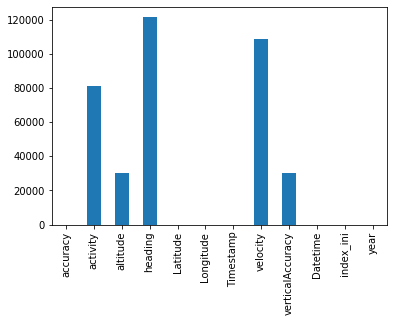

In [25]:
df19.isnull().sum().plot.bar()

In [ ]:
# On sauvegarde le dataframe au format pkl pour y accéder plus rapidement 
df19.to_pickle("df19_save.pkl")

In [24]:
# Pour récupérer le df19...
df19 = pd.read_pickle("df19_save.pkl")

# Visualisation des positions avec FOLIUM

#### 1ère visualisation

In [13]:
# Enregistrement de la date/heure actuelle
time_now = dt.datetime.now()

# Coordonnées du centre de la carte (à adapter selon les besoins)
centre = [48.8534, 2.3488]  # Correspond aux coordonnées de Paris

# On définit les coordonnées à afficher
coordinates = df2[['Latitude', 'Longitude']]

# On construit notre ma carte Folium 
map_initial = folium.Map(location=centre, 
                       zoom_start=11, 
                       tiles='cartodbpositron', 
                       width=864, height=600)

# On ajoute les points de nos positions sur la carte Folium, avec HeatMap 
map_initial.add_child(FastMarkerCluster(coordinates))
HeatMap(coordinates).add_to(map_initial)

# Display map in Jupyter
map_initial

#### Calcul des distances entre 2 positions

In [21]:
# On créé une nouvelle colonne contenant les distances entre positions

def distance_cal(index_pos):
    coord_1 = (df.Latitude[index_pos],df.Longitude[index_pos])
    coord_2 = (df.Latitude[index_pos+1],df.Longitude[index_pos+1])
    return geodesic(coord_1,coord_2).m

df['distance(m)'] = [distance_cal(x) if x in range(len(df)-1) else 0 for x in range(len(df))]
df.head(5)

accuracy                                           activity  altitude  \
0        30  [{'timestampMs': '1416441072130', 'activity': ...       NaN   
1        30                                                NaN       NaN   
2        30  [{'timestampMs': '1416441202401', 'activity': ...       NaN   
3        30  [{'timestampMs': '1416441355393', 'activity': ...       NaN   
4        20                                                NaN       NaN   

   heading   Latitude  Longitude     Timestamp  velocity  verticalAccuracy  \
0      NaN  48.899745   2.306102  1.416441e+09       NaN               NaN   
1      NaN  48.899767   2.306086  1.416441e+09       NaN               NaN   
2      NaN  48.899770   2.306078  1.416441e+09       NaN               NaN   
3      NaN  48.899763   2.306077  1.416441e+09       NaN               NaN   
4      NaN  48.899756   2.306080  1.416441e+09       NaN               NaN   

                 Datetime  index_ini  distance(m)  
0 2014-11-20 00:52:08.736          0     2.706141  
1 2014-11-20 00:53:06.567          1     0.590152  
2 2014-11-20 00:54:23.834          2     0.790821  
3 2014-11-20 00:55:29.798          3     0.821985  
4 2014-11-20 00:56:33.983          4     0.707705

In [19]:
df

accuracy                                           activity  altitude  \
0          13  [{'timestampMs': '1575706133217', 'activity': ...     106.0   
1          16  [{'timestampMs': '1575706156057', 'activity': ...     106.0   
2          13  [{'timestampMs': '1575706216281', 'activity': ...     106.0   
3          13  [{'timestampMs': '1575706313426', 'activity': ...     106.0   
4          13  [{'timestampMs': '1575706446915', 'activity': ...     106.0   
5          13  [{'timestampMs': '1575706574615', 'activity': ...     106.0   
6          13  [{'timestampMs': '1575706708899', 'activity': ...     106.0   
7          13  [{'timestampMs': '1575706835725', 'activity': ...     106.0   
8          13                                                NaN     106.0   
9          13  [{'timestampMs': '1575707105358', 'activity': ...     106.0   
10         13                                                NaN     106.0   
11         13  [{'timestampMs': '1575707361328', 'activity': ...     106.0   
12         13  [{'timestampMs': '1575707429445', 'activity': ...       NaN   
13         13  [{'timestampMs': '1575707497410', 'activity': ...       NaN   
14         16                                                NaN     106.0   
15         65  [{'timestampMs': '1575707590758', 'activity': ...     106.0   
16         29  [{'timestampMs': '1575707673191', 'activity': ...     109.0   
17         11                                                NaN     107.0   
18          3  [{'timestampMs': '1575707706128', 'activity': ...     105.0   
19          2                                                NaN     107.0   
20          3                                                NaN     110.0   
21          3                                                NaN     106.0   
22          3                                                NaN     106.0   
23         21                                                NaN     115.0   
24          4                                                NaN     115.0   
25          4  [{'timestampMs': '1575707823135', 'activity': ...     111.0   
26          3                                                NaN     117.0   
27          3                                                NaN     113.0   
28          3  [{'timestampMs': '1575707883796', 'activity': ...     113.0   
29          3                                                NaN     113.0   
..        ...                                                ...       ...   
701         4                                                NaN     161.0   
702         7                                                NaN     161.0   
703         5                                                NaN     159.0   
704         4  [{'timestampMs': '1575827072903', 'activity': ...     159.0   
705         3                                                NaN     159.0   
706         5                                                NaN     157.0   
707         4                                                NaN     155.0   
708         8  [{'timestampMs': '1575827133950', 'activity': ...     155.0   
709         8                                                NaN     155.0   
710         5                                                NaN     150.0   
711         5  [{'timestampMs': '1575827194996', 'activity': ...     146.0   
712         4                                                NaN     144.0   
713         4                                                NaN     132.0   
714         6                                                NaN     121.0   
715         8  [{'timestampMs': '1575827256035', 'activity': ...     121.0   
716         7                                                NaN     121.0   
717         7                                                NaN     116.0   
718        10                                                NaN     132.0   
719         9  [{'timestampMs': '1575827317083', 'activity': ...     132.0   
720         6              

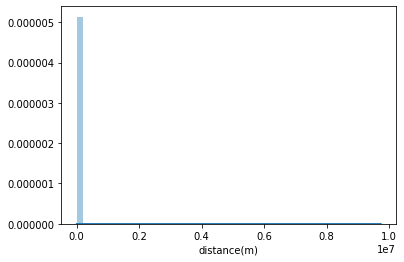

In [22]:
_ = sns.distplot(df['distance(m)'])

In [32]:
i = 3
df['distance(m)'][i]

0.0

In [36]:
# Visualisation du nombre de ligne avant suppression :
print("\nLe dataset des données de position présente {} lignes avant suppression des positions fixes.\n".format(df.shape[0]))

delta_long = 0.1

# Je supprime les lignes où ma position n'a pas changé significativement :
for i in range(1, len(df)) :
    if df['distance(m)'][i] <= delta_long & df['distance(m)'][i+1] <= delta_long :
        df.drop([i], inplace=True)
        print("Ligne {} supprimée. On incrémente i".format(i))

        
# Visualisation du nombre de ligne après suppression :
print("\nLe dataset des données de position présente {} lignes après suppression des positions fixes.\n".format(df.shape[0]))


######
###### Ca ne marche pas comme ça. Il faudrait essayer avec une boucle WHILE
######

rows_to_delete = []
while df['distance(m)'][i] <= delta_long :
    rows_to_delete.append(i+j-1)
    i+=1
    





Le dataset des données de position présente 731 lignes avant suppression des positions fixes.

Ligne 2 supprimée. On incrémente i
Ligne 3 supprimée. On incrémente i
Ligne 4 supprimée. On incrémente i
Ligne 5 supprimée. On incrémente i
Ligne 6 supprimée. On incrémente i
Ligne 7 supprimée. On incrémente i
Ligne 10 supprimée. On incrémente i
Ligne 12 supprimée. On incrémente i
Ligne 25 supprimée. On incrémente i
Ligne 36 supprimée. On incrémente i
Ligne 41 supprimée. On incrémente i
Ligne 42 supprimée. On incrémente i
Ligne 56 supprimée. On incrémente i
Ligne 66 supprimée. On incrémente i
Ligne 70 supprimée. On incrémente i
Ligne 71 supprimée. On incrémente i
Ligne 141 supprimée. On incrémente i
Ligne 142 supprimée. On incrémente i
Ligne 143 supprimée. On incrémente i
Ligne 144 supprimée. On incrémente i
Ligne 147 supprimée. On incrémente i
Ligne 159 supprimée. On incrémente i
Ligne 166 supprimée. On incrémente i
Ligne 167 supprimée. On incrémente i
Ligne 181 supprimée. On incrémente i
L

' \nwhile i < length-2:\n    print("boucle WHILE_ON_i : i={}".format(i))\n    \n    if (abs(df.Latitude[i+1] - df.Latitude[i]) < dist) & (abs(df.Longitude[i+1] - df.Longitude[i]) < dist) :\n        j=2 \n        rows_to_delete = []\n        \n        while (i+j<length-1) & (abs(df.Latitude[i+j] - df.Latitude[i]) < dist) & (abs(df.Longitude[i+j] - df.Longitude[i]) < dist) :\n            rows_to_delete.append(i+j-1)\n            j+=1\n        \n        print("Fin d\'une boucle WHILE_ON_j. j={}".format(j))\n        print("On supprime les lignes dont les index sont : {}".format(rows_to_delete))\n        df.drop(rows_to_delete, inplace=True)\n        df.reset_index(drop=True, inplace=True)\n        length = df.shape[0]\n        print("La nouvelle longueur du dataset est de : {} lignes".format(length))\n        \n    i+=1\n    print("Lignes supprimées. On incrémente i")\n    \nprint()\nprint(df.head(3))\nprint()\nprint("le dataset des données de position présente {} lignes.".format(df.shape[

In [23]:
# Je supprime les lignes où ma position n'a pas changé significativement :

i = 0
length = df.shape[0]
dist = 0.1

while i < length-2:
    print("boucle WHILE_ON_i : i={}".format(i))
    
    if (abs(df.Latitude[i+1] - df.Latitude[i]) < dist) & (abs(df.Longitude[i+1] - df.Longitude[i]) < dist) :
        j=2 
        rows_to_delete = []
        
        while (i+j<length-1) & (abs(df.Latitude[i+j] - df.Latitude[i]) < dist) & (abs(df.Longitude[i+j] - df.Longitude[i]) < dist) :
            rows_to_delete.append(i+j-1)
            j+=1
        
        print("Fin d'une boucle WHILE_ON_j. j={}".format(j))
        print("On supprime les lignes dont les index sont : {}".format(rows_to_delete))
        df.drop(rows_to_delete, inplace=True)
        df.reset_index(drop=True, inplace=True)
        length = df.shape[0]
        print("La nouvelle longueur du dataset est de : {} lignes".format(length))
        
    i+=1
    print("Lignes supprimées. On incrémente i")
    
print()
print(df.head(3))
print()
print("le dataset des données de position présente {} lignes.".format(df.shape[0]))

boucle WHILE_ON_i : i=0
Fin d'une boucle WHILE_ON_j. j=3899
On supprime les lignes dont les index sont : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 20

La nouvelle longueur du dataset est de : 754471 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1
Fin d'une boucle WHILE_ON_j. j=467
On supprime les lignes dont les index sont : [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 1

La nouvelle longueur du dataset est de : 751932 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=4
Fin d'une boucle WHILE_ON_j. j=577
On supprime les lignes dont les index sont : [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 1

La nouvelle longueur du dataset est de : 748946 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=9
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=10
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=11
Fin d'une boucle WHILE_ON_j. j=423
On supprime les lignes dont les index sont : [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166

La nouvelle longueur du dataset est de : 747998 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=36
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=37
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 747998 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=38
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=39
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 747998 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=40
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=41
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=42
Fin d'une boucle WHILE_ON_j. j=1211
On supprime les lignes dont les index sont : [43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,

La nouvelle longueur du dataset est de : 746088 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=44
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=45
Fin d'une boucle WHILE_ON_j. j=11
On supprime les lignes dont les index sont : [46, 47, 48, 49, 50, 51, 52, 53, 54]
La nouvelle longueur du dataset est de : 746079 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=46
Fin d'une boucle WHILE_ON_j. j=353
On supprime les lignes dont les index sont : [47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 1

La nouvelle longueur du dataset est de : 744581 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=49
Fin d'une boucle WHILE_ON_j. j=653
On supprime les lignes dont les index sont : [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,

La nouvelle longueur du dataset est de : 742905 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=69
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=70
Fin d'une boucle WHILE_ON_j. j=3
On supprime les lignes dont les index sont : [71]
La nouvelle longueur du dataset est de : 742904 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=71
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=72
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 742904 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=73
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=74
Fin d'une boucle WHILE_ON_j. j=7
On supprime les lignes dont les index sont : [75, 76, 77, 78, 79]
La nouvelle longueur du dataset est de : 742899 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=75
Fin d'une boucle WHILE_ON_j. j=6
On supprime les lignes dont les index sont : [76, 77, 78, 79]
La

La nouvelle longueur du dataset est de : 741641 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=87
Fin d'une boucle WHILE_ON_j. j=321
On supprime les lignes dont les index sont : [88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 2

La nouvelle longueur du dataset est de : 734153 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=89
Fin d'une boucle WHILE_ON_j. j=105
On supprime les lignes dont les index sont : [90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192]
La nouvelle longueur du dataset est de : 734050 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=90
Fin d'une boucle WHILE_ON_j. j=9314
On supprime les lignes dont les index sont : [91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 1

La nouvelle longueur du dataset est de : 724738 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=91
Fin d'une boucle WHILE_ON_j. j=8089
On supprime les lignes dont les index sont : [92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 2

La nouvelle longueur du dataset est de : 716651 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=92
Fin d'une boucle WHILE_ON_j. j=118
On supprime les lignes dont les index sont : [93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208]
La nouvelle longueur du dataset est de : 716535 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=93
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=94
Fin d'une boucle WHILE_ON_j. j=14
On supprime les lignes

La nouvelle longueur du dataset est de : 710403 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=99
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 710403 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=100
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=101
Fin d'une boucle WHILE_ON_j. j=3
On supprime les lignes dont les index sont : [102]
La nouvelle longueur du dataset est de : 710402 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=102
Fin d'une boucle WHILE_ON_j. j=6
On supprime les lignes dont les index sont : [103, 104, 105, 106]
La nouvelle longueur du dataset est de : 710398 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=103
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 710398 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=104
Fin d'une boucl

La nouvelle longueur du dataset est de : 709443 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=128
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=129
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 709443 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=130
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=131
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 709443 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=132
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=133
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=134
Fin d'une boucle WHILE_ON_j. j=47
On supprime les lignes dont les index sont : [135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 1

La nouvelle longueur du dataset est de : 705140 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=149
Fin d'une boucle WHILE_ON_j. j=48
On supprime les lignes dont les index sont : [150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195]
La nouvelle longueur du dataset est de : 705094 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=150
Fin d'une boucle WHILE_ON_j. j=165
On supprime les lignes dont les index sont : [151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 22

Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=154
Fin d'une boucle WHILE_ON_j. j=3
On supprime les lignes dont les index sont : [155]
La nouvelle longueur du dataset est de : 703552 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=155
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=156
Fin d'une boucle WHILE_ON_j. j=9
On supprime les lignes dont les index sont : [157, 158, 159, 160, 161, 162, 163]
La nouvelle longueur du dataset est de : 703545 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=157
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=158
Fin d'une boucle WHILE_ON_j. j=659
On supprime les lignes dont les index sont : [159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 2

Fin d'une boucle WHILE_ON_j. j=4952
On supprime les lignes dont les index sont : [177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360

La nouvelle longueur du dataset est de : 697573 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=177
Fin d'une boucle WHILE_ON_j. j=11
On supprime les lignes dont les index sont : [178, 179, 180, 181, 182, 183, 184, 185, 186]
La nouvelle longueur du dataset est de : 697564 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=178
Fin d'une boucle WHILE_ON_j. j=71
On supprime les lignes dont les index sont : [179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247]
La nouvelle longueur du dataset est de : 697495 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=179
Fin d'une boucle WHILE_ON_j. j=71
On supprime les lignes dont les index sont : [180, 181, 182, 183, 18

La nouvelle longueur du dataset est de : 695389 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=183
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=184
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 695389 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=185
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=186
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=187
Fin d'une boucle WHILE_ON_j. j=145
On supprime les lignes dont les index sont : [188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272

Fin d'une boucle WHILE_ON_j. j=23
On supprime les lignes dont les index sont : [206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226]
La nouvelle longueur du dataset est de : 693900 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=206
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=207
Fin d'une boucle WHILE_ON_j. j=9
On supprime les lignes dont les index sont : [208, 209, 210, 211, 212, 213, 214]
La nouvelle longueur du dataset est de : 693893 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=208
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=209
Fin d'une boucle WHILE_ON_j. j=15
On supprime les lignes dont les index sont : [210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222]
La nouvelle longueur du dataset est de : 693880 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=210
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=211
Fin d'une boucle WHILE_ON

La nouvelle longueur du dataset est de : 692093 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=214
Fin d'une boucle WHILE_ON_j. j=331
On supprime les lignes dont les index sont : [215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375

La nouvelle longueur du dataset est de : 688822 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=226
Fin d'une boucle WHILE_ON_j. j=18
On supprime les lignes dont les index sont : [227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242]
La nouvelle longueur du dataset est de : 688806 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=227
Fin d'une boucle WHILE_ON_j. j=142
On supprime les lignes dont les index sont : [228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 33

boucle WHILE_ON_i : i=241
Fin d'une boucle WHILE_ON_j. j=133
On supprime les lignes dont les index sont : [242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372]
La nouvelle longueur du dataset est de : 686287 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=242
Fin d'une boucle WHILE_ON_j. j=882
On supprime les lignes dont les index sont : [243, 244, 245, 246, 247, 248, 249, 250, 2

Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=247
Fin d'une boucle WHILE_ON_j. j=202
On supprime les lignes dont les index sont : [248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419

La nouvelle longueur du dataset est de : 683737 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=267
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=268
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 683737 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=269
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=270
Fin d'une boucle WHILE_ON_j. j=79
On supprime les lignes dont les index sont : [271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347]
La nouvelle longueur du dataset est de : 683660 lignes
Lignes supprimées. On incrémente i
boucle WHI

La nouvelle longueur du dataset est de : 682508 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=284
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 682508 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=285
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=286
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=287
Fin d'une boucle WHILE_ON_j. j=221
On supprime les lignes dont les index sont : [288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384,

Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=293
Fin d'une boucle WHILE_ON_j. j=112
On supprime les lignes dont les index sont : [294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403]
La nouvelle longueur du dataset est de : 680446 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=294
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=295
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 680446 li

La nouvelle longueur du dataset est de : 679008 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=301
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=302
Fin d'une boucle WHILE_ON_j. j=160
On supprime les lignes dont les index sont : [303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 45

La nouvelle longueur du dataset est de : 677220 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=307
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=308
Fin d'une boucle WHILE_ON_j. j=1171
On supprime les lignes dont les index sont : [309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 4

La nouvelle longueur du dataset est de : 675840 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=312
Fin d'une boucle WHILE_ON_j. j=290
On supprime les lignes dont les index sont : [313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473

La nouvelle longueur du dataset est de : 672779 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=317
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=318
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 672779 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=319
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=320
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=321
Fin d'une boucle WHILE_ON_j. j=392
On supprime les lignes dont les index sont : [322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406

Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=344
Fin d'une boucle WHILE_ON_j. j=13
On supprime les lignes dont les index sont : [345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355]
La nouvelle longueur du dataset est de : 670102 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=345
Fin d'une boucle WHILE_ON_j. j=7
On supprime les lignes dont les index sont : [346, 347, 348, 349, 350]
La nouvelle longueur du dataset est de : 670097 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=346
Fin d'une boucle WHILE_ON_j. j=6
On supprime les lignes dont les index sont : [347, 348, 349, 350]
La nouvelle longueur du dataset est de : 670093 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=347
Fin d'une boucle WHILE_ON_j. j=10
On supprime les lignes dont les index sont : [348, 349, 350, 351, 352, 353, 354, 355]
La nouvelle longueur du dataset est de : 670085 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=348
Fin d'une boucle 

Fin d'une boucle WHILE_ON_j. j=4
On supprime les lignes dont les index sont : [365, 366]
La nouvelle longueur du dataset est de : 668000 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=365
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=366
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=367
Fin d'une boucle WHILE_ON_j. j=200
On supprime les lignes dont les index sont : [368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 48

La nouvelle longueur du dataset est de : 666101 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=370
Fin d'une boucle WHILE_ON_j. j=4
On supprime les lignes dont les index sont : [371, 372]
La nouvelle longueur du dataset est de : 666099 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=371
Fin d'une boucle WHILE_ON_j. j=168
On supprime les lignes dont les index sont : [372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491

La nouvelle longueur du dataset est de : 664003 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=377
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=378
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 664003 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=379
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=380
Fin d'une boucle WHILE_ON_j. j=724
On supprime les lignes dont les index sont : [381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477,

La nouvelle longueur du dataset est de : 661296 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=389
Fin d'une boucle WHILE_ON_j. j=163
On supprime les lignes dont les index sont : [390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550

La nouvelle longueur du dataset est de : 658676 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=391
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=392
Fin d'une boucle WHILE_ON_j. j=45
On supprime les lignes dont les index sont : [393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435]
La nouvelle longueur du dataset est de : 658633 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=393
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=394
Fin d'une boucle WHILE_ON_j. j=1545
On supprime les lignes dont les index sont : [395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448,

La nouvelle longueur du dataset est de : 657090 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=395
Fin d'une boucle WHILE_ON_j. j=19
On supprime les lignes dont les index sont : [396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412]
La nouvelle longueur du dataset est de : 657073 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=396
Fin d'une boucle WHILE_ON_j. j=125
On supprime les lignes dont les index sont : [397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 50

La nouvelle longueur du dataset est de : 654765 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=399
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=400
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 654765 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=401
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=402
Fin d'une boucle WHILE_ON_j. j=594
On supprime les lignes dont les index sont : [403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499,

La nouvelle longueur du dataset est de : 652844 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=421
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=422
Fin d'une boucle WHILE_ON_j. j=3
On supprime les lignes dont les index sont : [423]
La nouvelle longueur du dataset est de : 652843 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=423
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=424
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=425
Fin d'une boucle WHILE_ON_j. j=31
On supprime les lignes dont les index sont : [426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454]
La nouvelle longueur du dataset est de : 652814 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=426
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=427
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longue

La nouvelle longueur du dataset est de : 650264 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=435
Fin d'une boucle WHILE_ON_j. j=66
On supprime les lignes dont les index sont : [436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499]
La nouvelle longueur du dataset est de : 650200 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=436
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=437
Fin d'une boucle WHILE_ON_j. j=632
On supprime les lignes dont les index sont : [438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 4

La nouvelle longueur du dataset est de : 647880 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=441
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=442
Fin d'une boucle WHILE_ON_j. j=3
On supprime les lignes dont les index sont : [443]
La nouvelle longueur du dataset est de : 647879 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=443
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=444
Fin d'une boucle WHILE_ON_j. j=3
On supprime les lignes dont les index sont : [445]
La nouvelle longueur du dataset est de : 647878 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=445
Fin d'une boucle WHILE_ON_j. j=173
On supprime les lignes dont les index sont : [446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 5

La nouvelle longueur du dataset est de : 644032 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=448
Fin d'une boucle WHILE_ON_j. j=714
On supprime les lignes dont les index sont : [449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609

La nouvelle longueur du dataset est de : 641222 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=455
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=456
Fin d'une boucle WHILE_ON_j. j=3
On supprime les lignes dont les index sont : [457]
La nouvelle longueur du dataset est de : 641221 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=457
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=458
Fin d'une boucle WHILE_ON_j. j=20
On supprime les lignes dont les index sont : [459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476]
La nouvelle longueur du dataset est de : 641203 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=459
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=460
Fin d'une boucle WHILE_ON_j. j=24
On supprime les lignes dont les index sont : [461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482]
La nouvelle longueur du d

La nouvelle longueur du dataset est de : 635988 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=470
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=471
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 635988 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=472
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=473
Fin d'une boucle WHILE_ON_j. j=25
On supprime les lignes dont les index sont : [474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496]
La nouvelle longueur du dataset est de : 635965 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=474
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=475
Fin d'une boucle WHILE_ON_j. j=333
On supprime les lignes dont les index sont : [476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 49

La nouvelle longueur du dataset est de : 633194 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=478
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=479
Fin d'une boucle WHILE_ON_j. j=304
On supprime les lignes dont les index sont : [480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 62

La nouvelle longueur du dataset est de : 631867 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=489
Fin d'une boucle WHILE_ON_j. j=10
On supprime les lignes dont les index sont : [490, 491, 492, 493, 494, 495, 496, 497]
La nouvelle longueur du dataset est de : 631859 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=490
Fin d'une boucle WHILE_ON_j. j=9
On supprime les lignes dont les index sont : [491, 492, 493, 494, 495, 496, 497]
La nouvelle longueur du dataset est de : 631852 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=491
Fin d'une boucle WHILE_ON_j. j=65
On supprime les lignes dont les index sont : [492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554]
La nouvelle longueur du

La nouvelle longueur du dataset est de : 630845 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=507
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=508
Fin d'une boucle WHILE_ON_j. j=633
On supprime les lignes dont les index sont : [509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 65

La nouvelle longueur du dataset est de : 629157 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=529
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=530
Fin d'une boucle WHILE_ON_j. j=62
On supprime les lignes dont les index sont : [531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590]
La nouvelle longueur du dataset est de : 629097 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=531
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=532
Fin d'une boucle WHILE_ON_j. j=992
On supprime les lignes dont les index sont : [533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 

Fin d'une boucle WHILE_ON_j. j=585
On supprime les lignes dont les index sont : [541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724,

La nouvelle longueur du dataset est de : 626604 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=550
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=551
Fin d'une boucle WHILE_ON_j. j=54
On supprime les lignes dont les index sont : [552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603]
La nouvelle longueur du dataset est de : 626552 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=552
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=553
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=554
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 626552 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=555
Lignes supprimées. On incrémente i
boucle WHILE_

La nouvelle longueur du dataset est de : 625248 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=569
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=570
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=571
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=572
Fin d'une boucle WHILE_ON_j. j=1328
On supprime les lignes dont les index sont : [573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696,

La nouvelle longueur du dataset est de : 623418 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=575
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=576
Fin d'une boucle WHILE_ON_j. j=288
On supprime les lignes dont les index sont : [577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 72

La nouvelle longueur du dataset est de : 621877 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=585
Fin d'une boucle WHILE_ON_j. j=370
On supprime les lignes dont les index sont : [586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746

La nouvelle longueur du dataset est de : 619403 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=590
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=591
Fin d'une boucle WHILE_ON_j. j=44
On supprime les lignes dont les index sont : [592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633]
La nouvelle longueur du dataset est de : 619361 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=592
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=593
Fin d'une boucle WHILE_ON_j. j=599
On supprime les lignes dont les index sont : [594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 

La nouvelle longueur du dataset est de : 618012 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=610
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=611
Fin d'une boucle WHILE_ON_j. j=101
On supprime les lignes dont les index sont : [612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710]
La nouvelle longueur du dataset est de : 617913 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=612
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=613
Fin d'une boucle WHILE_ON_j. j=11
On supprime les lignes dont les inde

La nouvelle longueur du dataset est de : 616971 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=630
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 616971 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=631
Fin d'une boucle WHILE_ON_j. j=4
On supprime les lignes dont les index sont : [632, 633]
La nouvelle longueur du dataset est de : 616969 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=632
Fin d'une boucle WHILE_ON_j. j=46
On supprime les lignes dont les index sont : [633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676]
La nouvelle longueur du dataset est de : 616925 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=633
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=634
Ligne

La nouvelle longueur du dataset est de : 614820 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=643
Fin d'une boucle WHILE_ON_j. j=628
On supprime les lignes dont les index sont : [644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804

La nouvelle longueur du dataset est de : 613467 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=649
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 613467 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=650
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=651
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=652
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=653
Fin d'une boucle WHILE_ON_j. j=34
On supprime les lignes dont les index sont : [654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685]
La nouvelle longueur du dataset est de : 613435 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=654
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=655
Fin d'une boucle WHILE_ON_j. j=10
On supprime les lignes dont les index sont : [656, 65

La nouvelle longueur du dataset est de : 611598 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=659
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 611598 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=660
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=661
Fin d'une boucle WHILE_ON_j. j=5
On supprime les lignes dont les index sont : [662, 663, 664]
La nouvelle longueur du dataset est de : 611595 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=662
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=663
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=664
Fin d'une boucle WHILE_ON_j. j=4
On supprime les lignes dont les index sont : [665, 666]
La nouvelle longueur du dataset est de : 611593 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=665
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=666
Fin d'une boucle WHILE_ON_j.

La nouvelle longueur du dataset est de : 604637 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=679
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=680
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=681
Fin d'une boucle WHILE_ON_j. j=1479
On supprime les lignes dont les index sont : [682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 

La nouvelle longueur du dataset est de : 603160 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=682
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=683
Fin d'une boucle WHILE_ON_j. j=38
On supprime les lignes dont les index sont : [684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719]
La nouvelle longueur du dataset est de : 603124 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=684
Fin d'une boucle WHILE_ON_j. j=232
On supprime les lignes dont les index sont : [685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 7

La nouvelle longueur du dataset est de : 601437 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=697
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=698
Fin d'une boucle WHILE_ON_j. j=1993
On supprime les lignes dont les index sont : [699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 8

La nouvelle longueur du dataset est de : 599446 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=699
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=700
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=701
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=702
Fin d'une boucle WHILE_ON_j. j=954
On supprime les lignes dont les index sont : [703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 

La nouvelle longueur du dataset est de : 598226 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=712
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 598226 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=713
Fin d'une boucle WHILE_ON_j. j=192
On supprime les lignes dont les index sont : [714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 8

Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 595136 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=725
Fin d'une boucle WHILE_ON_j. j=5
On supprime les lignes dont les index sont : [726, 727, 728]
La nouvelle longueur du dataset est de : 595133 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=726
Fin d'une boucle WHILE_ON_j. j=85
On supprime les lignes dont les index sont : [727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809]
La nouvelle longueur du dataset est de : 595050 lignes
Lignes supprimées. On incrémente i
boucle W

La nouvelle longueur du dataset est de : 592731 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=729
Fin d'une boucle WHILE_ON_j. j=10
On supprime les lignes dont les index sont : [730, 731, 732, 733, 734, 735, 736, 737]
La nouvelle longueur du dataset est de : 592723 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=730
Fin d'une boucle WHILE_ON_j. j=81
On supprime les lignes dont les index sont : [731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809]
La nouvelle longueur du dataset est de : 592644 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=731
Fin d'une boucle WHILE_ON_j. j=248
On supprime les lignes

La nouvelle longueur du dataset est de : 591425 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=739
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=740
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 591425 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=741
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 591425 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=742
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=743
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=744
Fin d'une boucle WHILE_ON_j. j=1518
On supprime les lignes dont les index sont : [745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 

Fin d'une boucle WHILE_ON_j. j=949
On supprime les lignes dont les index sont : [746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929,

La nouvelle longueur du dataset est de : 587631 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=758
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=759
Fin d'une boucle WHILE_ON_j. j=114
On supprime les lignes dont les index sont : [760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871]
La nouvelle longueur du dataset est de : 587519 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=760
Fin d'une boucle WHILE_ON_j. j=943
On supprime les lignes dont les

La nouvelle longueur du dataset est de : 586395 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=769
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=770
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=771
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 586395 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=772
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=773
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=774
Fin d'une boucle WHILE_ON_j. j=97
On supprime les lignes dont les index sont : [775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847

Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=784
Fin d'une boucle WHILE_ON_j. j=24
On supprime les lignes dont les index sont : [785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806]
La nouvelle longueur du dataset est de : 584304 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=785
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=786
Fin d'une boucle WHILE_ON_j. j=79
On supprime les lignes dont les index sont : [787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863]
La nouvelle longueur du dataset est de : 584227 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i

Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 582906 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=818
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=819
Fin d'une boucle WHILE_ON_j. j=97
On supprime les lignes dont les index sont : [820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914]
La nouvelle longueur du dataset est de : 582811 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=820
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=821
Fin d'une 

Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=823
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=824
Fin d'une boucle WHILE_ON_j. j=570
On supprime les lignes dont les index sont : [825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 98

La nouvelle longueur du dataset est de : 580292 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=841
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=842
Fin d'une boucle WHILE_ON_j. j=8
On supprime les lignes dont les index sont : [843, 844, 845, 846, 847, 848]
La nouvelle longueur du dataset est de : 580286 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=843
Fin d'une boucle WHILE_ON_j. j=5
On supprime les lignes dont les index sont : [844, 845, 846]
La nouvelle longueur du dataset est de : 580283 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=844
Fin d'une boucle WHILE_ON_j. j=205
On supprime les lignes dont les index sont : [845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 90

Fin d'une boucle WHILE_ON_j. j=6
On supprime les lignes dont les index sont : [858, 859, 860, 861]
La nouvelle longueur du dataset est de : 577658 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=858
Fin d'une boucle WHILE_ON_j. j=141
On supprime les lignes dont les index sont : [859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997]
La nouvel

Fin d'une boucle WHILE_ON_j. j=771
On supprime les lignes dont les index sont : [863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 

Fin d'une boucle WHILE_ON_j. j=8
On supprime les lignes dont les index sont : [870, 871, 872, 873, 874, 875]
La nouvelle longueur du dataset est de : 573958 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=870
Fin d'une boucle WHILE_ON_j. j=9
On supprime les lignes dont les index sont : [871, 872, 873, 874, 875, 876, 877]
La nouvelle longueur du dataset est de : 573951 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=871
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=872
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=873
Fin d'une boucle WHILE_ON_j. j=10
On supprime les lignes dont les index sont : [874, 875, 876, 877, 878, 879, 880, 881]
La nouvelle longueur du dataset est de : 573943 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=874
Fin d'une boucle WHILE_ON_j. j=745
On supprime les lignes dont les index sont : [875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 8

Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=878
Fin d'une boucle WHILE_ON_j. j=174
On supprime les lignes dont les index sont : [879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1

Fin d'une boucle WHILE_ON_j. j=29
On supprime les lignes dont les index sont : [888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914]
La nouvelle longueur du dataset est de : 569996 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=888
Fin d'une boucle WHILE_ON_j. j=22
On supprime les lignes dont les index sont : [889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908]
La nouvelle longueur du dataset est de : 569976 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=889
Fin d'une boucle WHILE_ON_j. j=28
On supprime les lignes dont les index sont : [890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915]
La nouvelle longueur du dataset est de : 569950 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=890
Fin d'une boucle WHILE_ON_j. j=20
On supprime l

La nouvelle longueur du dataset est de : 569093 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=906
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=907
Fin d'une boucle WHILE_ON_j. j=178
On supprime les lignes dont les index sont : [908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 

La nouvelle longueur du dataset est de : 567572 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=914
Fin d'une boucle WHILE_ON_j. j=4
On supprime les lignes dont les index sont : [915, 916]
La nouvelle longueur du dataset est de : 567570 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=915
Fin d'une boucle WHILE_ON_j. j=25
On supprime les lignes dont les index sont : [916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938]
La nouvelle longueur du dataset est de : 567547 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=916
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=917
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=918
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=919
Fin d'une boucle WHILE_ON_j. j=463
On supprime les lignes dont les index sont : [920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940,

Fin d'une boucle WHILE_ON_j. j=7
On supprime les lignes dont les index sont : [927, 928, 929, 930, 931]
La nouvelle longueur du dataset est de : 565847 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=927
Fin d'une boucle WHILE_ON_j. j=414
On supprime les lignes dont les index sont : [928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 105

La nouvelle longueur du dataset est de : 564543 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=933
Fin d'une boucle WHILE_ON_j. j=242
On supprime les lignes dont les index sont : [934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078,

Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=940
Fin d'une boucle WHILE_ON_j. j=338
On supprime les lignes dont les index sont : [941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093,

Fin d'une boucle WHILE_ON_j. j=1458
On supprime les lignes dont les index sont : [955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 111

Fin d'une boucle WHILE_ON_j. j=12
On supprime les lignes dont les index sont : [956, 957, 958, 959, 960, 961, 962, 963, 964, 965]
La nouvelle longueur du dataset est de : 559853 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=956
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=957
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 559853 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=958
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=959
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=960
Fin d'une boucle WHILE_ON_j. j=9
On supprime les lignes dont les index sont : [961, 962, 963, 964, 965, 966, 967]
La nouvelle longueur du dataset est de : 559846 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=961
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=962
Fin d'une boucle WHILE_ON_j. j=5
On supprime les lignes dont les index sont : [963,

La nouvelle longueur du dataset est de : 558932 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=983
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=984
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=985
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=986
Fin d'une boucle WHILE_ON_j. j=3
On supprime les lignes dont les index sont : [987]
La nouvelle longueur du dataset est de : 558931 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=987
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=988
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=989
Fin d'une boucle WHILE_ON_j. j=48
On supprime les lignes dont les index sont : [990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035]
La nouvelle longueur du dataset e

La nouvelle longueur du dataset est de : 557829 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=999
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1000
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 557829 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1001
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1002
Fin d'une boucle WHILE_ON_j. j=4
On supprime les lignes dont les index sont : [1003, 1004]
La nouvelle longueur du dataset est de : 557827 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1003
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 557827 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1004
Fin d'une boucle WHILE_ON_j. j=78
On supprime les lignes dont les index sont : [1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017

La nouvelle longueur du dataset est de : 554943 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1010
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1011
Fin d'une boucle WHILE_ON_j. j=536
On supprime les lignes dont les index sont : [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 11

La nouvelle longueur du dataset est de : 553476 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1014
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1015
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1016
Fin d'une boucle WHILE_ON_j. j=3
On supprime les lignes dont les index sont : [1017]
La nouvelle longueur du dataset est de : 553475 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1017
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1018
Fin d'une boucle WHILE_ON_j. j=7
On supprime les lignes dont les index sont : [1019, 1020, 1021, 1022, 1023]
La nouvelle longueur du dataset est de : 553470 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1019
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1020
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 553470 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1021
Lignes su

La nouvelle longueur du dataset est de : 548477 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1038
Fin d'une boucle WHILE_ON_j. j=826
On supprime les lignes dont les index sont : [1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172

Fin d'une boucle WHILE_ON_j. j=1127
On supprime les lignes dont les index sont : [1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 

La nouvelle longueur du dataset est de : 545162 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1048
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1049
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1050
Fin d'une boucle WHILE_ON_j. j=628
On supprime les lignes dont les index sont : [1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 

La nouvelle longueur du dataset est de : 543759 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1059
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1060
Fin d'une boucle WHILE_ON_j. j=8
On supprime les lignes dont les index sont : [1061, 1062, 1063, 1064, 1065, 1066]
La nouvelle longueur du dataset est de : 543753 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1061
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1062
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 543753 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1063
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1064
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1065
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1066
Fin d'une boucle WHILE_ON_j. j=212
On supprime les lignes dont les index sont : [1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 10

Fin d'une boucle WHILE_ON_j. j=45
On supprime les lignes dont les index sont : [1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127]
La nouvelle longueur du dataset est de : 543041 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1085
Fin d'une boucle WHILE_ON_j. j=35
On supprime les lignes dont les index sont : [1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118]
La nouvelle longueur du dataset est de : 543008 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1086
Fin d'une boucle WHILE_ON_j. j=235
On supprime les lignes dont les index sont : [1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 109

Fin d'une boucle WHILE_ON_j. j=11
On supprime les lignes dont les index sont : [1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109]
La nouvelle longueur du dataset est de : 540420 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1101
Fin d'une boucle WHILE_ON_j. j=89
On supprime les lignes dont les index sont : [1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188]
La nouvelle longueur du dataset est de : 540333 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1102
Fin d'une boucle WHILE_ON_j. j

La nouvelle longueur du dataset est de : 538774 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1105
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1106
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1107
Fin d'une boucle WHILE_ON_j. j=3
On supprime les lignes dont les index sont : [1108]
La nouvelle longueur du dataset est de : 538773 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1108
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1109
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1110
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 538773 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1111
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1112
Fin d'une boucle WHILE_ON_j. j=4
On supprime les lignes dont les index sont : [1113, 1114]
La nouvelle longueur du dataset est de : 538771 lignes
Lignes supprimées. On incré

La nouvelle longueur du dataset est de : 535908 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1124
Fin d'une boucle WHILE_ON_j. j=16
On supprime les lignes dont les index sont : [1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138]
La nouvelle longueur du dataset est de : 535894 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1125
Fin d'une boucle WHILE_ON_j. j=240
On supprime les lignes dont les index sont : [1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212,

La nouvelle longueur du dataset est de : 532048 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1138
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1139
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 532048 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1140
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1141
Fin d'une boucle WHILE_ON_j. j=320
On supprime les lignes dont les index sont : [1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 

La nouvelle longueur du dataset est de : 530598 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1145
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1146
Fin d'une boucle WHILE_ON_j. j=1374
On supprime les lignes dont les index sont : [1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1

La nouvelle longueur du dataset est de : 529220 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1148
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1149
Fin d'une boucle WHILE_ON_j. j=51
On supprime les lignes dont les index sont : [1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198]
La nouvelle longueur du dataset est de : 529171 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1150
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1151
Fin d'une boucle WHILE_ON_j. j=920
On supprime les lignes dont les index sont : [1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1

Fin d'une boucle WHILE_ON_j. j=617
On supprime les lignes dont les index sont : [1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1

La nouvelle longueur du dataset est de : 526511 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1163
Fin d'une boucle WHILE_ON_j. j=3
On supprime les lignes dont les index sont : [1164]
La nouvelle longueur du dataset est de : 526510 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1164
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1165
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1166
Fin d'une boucle WHILE_ON_j. j=8
On supprime les lignes dont les index sont : [1167, 1168, 1169, 1170, 1171, 1172]
La nouvelle longueur du dataset est de : 526504 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1167
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1168
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 526504 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1169
Fin d'une boucle WHILE_ON_j. j=3
On supprime les lignes dont les 

Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1187
Fin d'une boucle WHILE_ON_j. j=53
On supprime les lignes dont les index sont : [1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238]
La nouvelle longueur du dataset est de : 525556 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1188
Fin d'une boucle WHILE_ON_j. j=8
On supprime les lignes dont les index sont : [1189, 1190, 1191, 1192, 1193, 1194]
La nouvelle longueur du dataset est de : 525550 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1189
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1190
Fin d'une boucle WHILE_ON_j. j=871
On supprime les lignes dont les index sont : [1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 

La nouvelle longueur du dataset est de : 521586 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1192
Fin d'une boucle WHILE_ON_j. j=19
On supprime les lignes dont les index sont : [1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209]
La nouvelle longueur du dataset est de : 521569 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1193
Fin d'une boucle WHILE_ON_j. j=8
On supprime les lignes dont les index sont : [1194, 1195, 1196, 1197, 1198, 1199]
La nouvelle longueur du dataset est de : 521563 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1194
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1195
Fin d'une boucle WHILE_ON_j. j=15
On supprime les lignes dont les index sont : [1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208]
La nouvelle longueur du dataset est de : 521550 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1196
Lignes supprimé

Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1213
Fin d'une boucle WHILE_ON_j. j=157
On supprime les lignes dont les index sont : [1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356,

La nouvelle longueur du dataset est de : 518732 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1218
Fin d'une boucle WHILE_ON_j. j=13
On supprime les lignes dont les index sont : [1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229]
La nouvelle longueur du dataset est de : 518721 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1219
Fin d'une boucle WHILE_ON_j. j=3
On supprime les lignes dont les index sont : [1220]
La nouvelle longueur du dataset est de : 518720 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1220
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 518720 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1221
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1222
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1223
Fin d'une boucle WHILE_ON_j. j=3
On supprime les lignes dont les index sont : [1224]
La nouvelle

La nouvelle longueur du dataset est de : 517773 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1235
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1236
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 517773 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1237
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1238
Fin d'une boucle WHILE_ON_j. j=3
On supprime les lignes dont les index sont : [1239]
La nouvelle longueur du dataset est de : 517772 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1239
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 517772 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1240
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 517772 lignes
Lignes supprimées. On inc

Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1246
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1247
Fin d'une boucle WHILE_ON_j. j=8
On supprime les lignes dont les index sont : [1248, 1249, 1250, 1251, 1252, 1253]
La nouvelle longueur du dataset est de : 515037 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1248
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1249
Fin d'une boucle WHILE_ON_j. j=800
On supprime les lignes dont les index sont : [1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332, 133

La nouvelle longueur du dataset est de : 513807 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1253
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1254
Fin d'une boucle WHILE_ON_j. j=12
On supprime les lignes dont les index sont : [1255, 1256, 1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264]
La nouvelle longueur du dataset est de : 513797 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1255
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1256
Fin d'une boucle WHILE_ON_j. j=111
On supprime les lignes dont les index sont : [1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1

Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1267
Fin d'une boucle WHILE_ON_j. j=95
On supprime les lignes dont les index sont : [1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356, 1357, 1358, 1359, 1360]
La nouvelle longueur du dataset est de : 510224 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1268
Fin d'une boucle WHILE_ON_j. j=123
On supprime les lignes dont les index sont : [1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 

Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1271
Fin d'une boucle WHILE_ON_j. j=46
On supprime les lignes dont les index sont : [1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315]
La nouvelle longueur du dataset est de : 508726 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1272
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 508726 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1273
Fin d'une boucle WHILE_ON_j. j=1472
On supprime les lignes dont les index sont : [1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306,

Fin d'une boucle WHILE_ON_j. j=24
On supprime les lignes dont les index sont : [1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296]
La nouvelle longueur du dataset est de : 507234 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1275
Fin d'une boucle WHILE_ON_j. j=177
On supprime les lignes dont les index sont : [1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356, 1357, 1358, 1359, 1360, 1361, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 13

Fin d'une boucle WHILE_ON_j. j=20
On supprime les lignes dont les index sont : [1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296]
La nouvelle longueur du dataset est de : 505900 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1279
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1280
Fin d'une boucle WHILE_ON_j. j=105
On supprime les lignes dont les index sont : [1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356, 1357, 1358, 1359, 1360, 1361, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 

Fin d'une boucle WHILE_ON_j. j=59
On supprime les lignes dont les index sont : [1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347]
La nouvelle longueur du dataset est de : 501851 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1291
Fin d'une boucle WHILE_ON_j. j=1469
On supprime les lignes dont les index sont : [1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1353, 1354, 1

Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1293
Fin d'une boucle WHILE_ON_j. j=3
On supprime les lignes dont les index sont : [1294]
La nouvelle longueur du dataset est de : 500383 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1294
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 500383 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1295
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1296
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 500383 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1297
Fin d'une boucle WHILE_ON_j. j=3
On supprime les lignes dont les index sont : [1298]
La nouvelle longueur du dataset est de : 500382 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1298
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1299
Fin d'une bouc

La nouvelle longueur du dataset est de : 499023 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1312
Fin d'une boucle WHILE_ON_j. j=5
On supprime les lignes dont les index sont : [1313, 1314, 1315]
La nouvelle longueur du dataset est de : 499020 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1313
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 499020 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1314
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1315
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 499020 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1316
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 499020 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1317
Fin d'une bou

Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1334
Fin d'une boucle WHILE_ON_j. j=304
On supprime les lignes dont les index sont : [1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356, 1357, 1358, 1359, 1360, 1361, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477,

Fin d'une boucle WHILE_ON_j. j=395
On supprime les lignes dont les index sont : [1354, 1355, 1356, 1357, 1358, 1359, 1360, 1361, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1

Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1356
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1357
Fin d'une boucle WHILE_ON_j. j=1082
On supprime les lignes dont les index sont : [1358, 1359, 1360, 1361, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 14

Fin d'une boucle WHILE_ON_j. j=125
On supprime les lignes dont les index sont : [1365, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487]
La nouvelle longueur du dataset est de : 484441 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1365
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1366
Li

Fin d'une boucle WHILE_ON_j. j=2725
On supprime les lignes dont les index sont : [1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 

Fin d'une boucle WHILE_ON_j. j=10
On supprime les lignes dont les index sont : [1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392]
La nouvelle longueur du dataset est de : 478860 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1385
Fin d'une boucle WHILE_ON_j. j=841
On supprime les lignes dont les index sont : [1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 14

La nouvelle longueur du dataset est de : 477606 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1393
Fin d'une boucle WHILE_ON_j. j=30
On supprime les lignes dont les index sont : [1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421]
La nouvelle longueur du dataset est de : 477578 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1394
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1395
Fin d'une boucle WHILE_ON_j. j=1402
On supprime les lignes dont les index sont : [1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 14

Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1397
Fin d'une boucle WHILE_ON_j. j=90
On supprime les lignes dont les index sont : [1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485]
La nouvelle longueur du dataset est de : 476090 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1398
Fin d'une boucle WHILE_ON_j. j=3111
On supprime les lignes dont les index sont : [1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420,

La nouvelle longueur du dataset est de : 472977 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1400
Fin d'une boucle WHILE_ON_j. j=248
On supprime les lignes dont les index sont : [1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534

On supprime les lignes dont les index sont : [1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414]
La nouvelle longueur du dataset est de : 471534 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1404
Fin d'une boucle WHILE_ON_j. j=15
On supprime les lignes dont les index sont : [1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417]
La nouvelle longueur du dataset est de : 471521 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1405
Fin d'une boucle WHILE_ON_j. j=19
On supprime les lignes dont les index sont : [1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422]
La nouvelle longueur du dataset est de : 471504 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1406
Fin d'une boucle WHILE_ON_j. j=18
On supprime les lignes dont les index sont : [1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422]
La nouvelle longueur 

La nouvelle longueur du dataset est de : 470577 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1428
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1429
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1430
Fin d'une boucle WHILE_ON_j. j=4255
On supprime les lignes dont les index sont : [1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543,

Fin d'une boucle WHILE_ON_j. j=3468
On supprime les lignes dont les index sont : [1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 

Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1435
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1436
Fin d'une boucle WHILE_ON_j. j=24
On supprime les lignes dont les index sont : [1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458]
La nouvelle longueur du dataset est de : 462836 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1437
Fin d'une boucle WHILE_ON_j. j=195
On supprime les lignes dont les index sont : [1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515

Fin d'une boucle WHILE_ON_j. j=29
On supprime les lignes dont les index sont : [1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470]
La nouvelle longueur du dataset est de : 460064 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1444
Fin d'une boucle WHILE_ON_j. j=22
On supprime les lignes dont les index sont : [1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464]
La nouvelle longueur du dataset est de : 460044 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1445
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1446
Fin d'une boucle WHILE_ON_j. j=3057
On supprime les lignes dont les index sont : [1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 

Fin d'une boucle WHILE_ON_j. j=46
On supprime les lignes dont les index sont : [1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492]
La nouvelle longueur du dataset est de : 456945 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1449
Fin d'une boucle WHILE_ON_j. j=459
On supprime les lignes dont les index sont : [1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 15

Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 455651 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1453
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1454
Fin d'une boucle WHILE_ON_j. j=9
On supprime les lignes dont les index sont : [1455, 1456, 1457, 1458, 1459, 1460, 1461]
La nouvelle longueur du dataset est de : 455644 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1455
Fin d'une boucle WHILE_ON_j. j=5
On supprime les lignes dont les index sont : [1456, 1457, 1458]
La nouvelle longueur du dataset est de : 455641 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1456
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 455641 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1457
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvel

Fin d'une boucle WHILE_ON_j. j=1738
On supprime les lignes dont les index sont : [1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 

Fin d'une boucle WHILE_ON_j. j=1964
On supprime les lignes dont les index sont : [1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 

Fin d'une boucle WHILE_ON_j. j=20
On supprime les lignes dont les index sont : [1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496]
La nouvelle longueur du dataset est de : 449582 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1479
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1480
Fin d'une boucle WHILE_ON_j. j=62
On supprime les lignes dont les index sont : [1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540]
La nouvelle longueur du dataset est de : 449522 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1481
Fin d'une boucle WHILE_ON_j. j=996
On supprime les lignes dont les index son

Fin d'une boucle WHILE_ON_j. j=281
On supprime les lignes dont les index sont : [1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1

Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1491
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1492
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1493
Fin d'une boucle WHILE_ON_j. j=5
On supprime les lignes dont les index sont : [1494, 1495, 1496]
La nouvelle longueur du dataset est de : 443907 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1494
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1495
Fin d'une boucle WHILE_ON_j. j=174
On supprime les lignes dont les index sont : [1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1

Fin d'une boucle WHILE_ON_j. j=11
On supprime les lignes dont les index sont : [1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509]
La nouvelle longueur du dataset est de : 442648 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1501
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 442648 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1502
Fin d'une boucle WHILE_ON_j. j=35
On supprime les lignes dont les index sont : [1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535]
La nouvelle longueur du dataset est de : 442615 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1503
Fin d'une boucle WHILE_ON_j. j=14
On supprime les lignes dont les index sont : [1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515]
La n

La nouvelle longueur du dataset est de : 441922 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1531
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1532
Fin d'une boucle WHILE_ON_j. j=4
On supprime les lignes dont les index sont : [1533, 1534]
La nouvelle longueur du dataset est de : 441920 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1533
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1534
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1535
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1536
Fin d'une boucle WHILE_ON_j. j=6
On supprime les lignes dont les index sont : [1537, 1538, 1539, 1540]
La nouvelle longueur du dataset est de : 441916 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1537
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1538
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1539
Fin d'une boucle WHILE_ON_j. j=6
On supprime les lignes dont les index sont : [1540

Fin d'une boucle WHILE_ON_j. j=520
On supprime les lignes dont les index sont : [1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682, 1683, 1684, 1685, 1686, 1687, 1688, 1689, 1690, 1691, 1692, 1693, 1694, 1695, 1696, 1697, 1698, 1699, 1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1

La nouvelle longueur du dataset est de : 433267 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1562
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 433267 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1563
Fin d'une boucle WHILE_ON_j. j=112
On supprime les lignes dont les index sont : [1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664

Fin d'une boucle WHILE_ON_j. j=44
On supprime les lignes dont les index sont : [1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615]
La nouvelle longueur du dataset est de : 431959 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1574
Fin d'une boucle WHILE_ON_j. j=46
On supprime les lignes dont les index sont : [1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618]
La nouvelle longueur du dataset est de : 431915 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1575
Fin d'une boucle WHILE_ON_j. j=196
On supprime les lignes dont les index sont : [1576, 157

La nouvelle longueur du dataset est de : 430994 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1592
Fin d'une boucle WHILE_ON_j. j=25
On supprime les lignes dont les index sont : [1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615]
La nouvelle longueur du dataset est de : 430971 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1593
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1594
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 430971 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1595
Fin d'une boucle WHILE_ON_j. j=68
On supprime les lignes dont les index sont : [1596, 1597, 1598, 1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630

La nouvelle longueur du dataset est de : 429924 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1609
Fin d'une boucle WHILE_ON_j. j=142
On supprime les lignes dont les index sont : [1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682, 1683, 1684, 1685, 1686, 1687, 1688, 1689, 1690, 1691, 1692, 1693, 1694, 1695, 1696, 1697, 1698, 1699, 1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709, 1710, 1711, 1712, 1713, 1714, 1715, 1716, 1717, 1718, 1719, 1720, 1721, 1722, 1723, 1724, 1725, 1726, 1727, 1728, 1729, 1730, 1731, 1732, 1733, 1734, 1735, 1736, 1737, 1738, 1739, 1740, 1741, 1742, 1743

Fin d'une boucle WHILE_ON_j. j=62
On supprime les lignes dont les index sont : [1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674]
La nouvelle longueur du dataset est de : 427916 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1615
Fin d'une boucle WHILE_ON_j. j=49
On supprime les lignes dont les index sont : [1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662]
La nouvelle longueur du dataset est de : 427869 lignes
Lignes supprimées. On incr

La nouvelle longueur du dataset est de : 426858 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1625
Fin d'une boucle WHILE_ON_j. j=228
On supprime les lignes dont les index sont : [1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682, 1683, 1684, 1685, 1686, 1687, 1688, 1689, 1690, 1691, 1692, 1693, 1694, 1695, 1696, 1697, 1698, 1699, 1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709, 1710, 1711, 1712, 1713, 1714, 1715, 1716, 1717, 1718, 1719, 1720, 1721, 1722, 1723, 1724, 1725, 1726, 1727, 1728, 1729, 1730, 1731, 1732, 1733, 1734, 1735, 1736, 1737, 1738, 1739, 1740, 1741, 1742, 1743, 1744, 1745, 1746, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759

Fin d'une boucle WHILE_ON_j. j=27
On supprime les lignes dont les index sont : [1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657]
La nouvelle longueur du dataset est de : 425454 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1633
Fin d'une boucle WHILE_ON_j. j=33
On supprime les lignes dont les index sont : [1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664]
La nouvelle longueur du dataset est de : 425423 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1634
Fin d'une boucle WHILE_ON_j. j=116
On supprime les lignes dont les index sont : [1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 166

La nouvelle longueur du dataset est de : 424430 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1644
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1645
Fin d'une boucle WHILE_ON_j. j=188
On supprime les lignes dont les index sont : [1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682, 1683, 1684, 1685, 1686, 1687, 1688, 1689, 1690, 1691, 1692, 1693, 1694, 1695, 1696, 1697, 1698, 1699, 1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709, 1710, 1711, 1712, 1713, 1714, 1715, 1716, 1717, 1718, 1719, 1720, 1721, 1722, 1723, 1724, 1725, 1726, 1727, 1728, 1729, 1730, 1731, 1732, 1733, 1734, 1735, 1736, 1737, 1738, 1739, 1740, 1741, 1742, 1743, 1744, 1745, 1746, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 17

Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1657
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1658
Fin d'une boucle WHILE_ON_j. j=3
On supprime les lignes dont les index sont : [1659]
La nouvelle longueur du dataset est de : 421368 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1659
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1660
Fin d'une boucle WHILE_ON_j. j=96
On supprime les lignes dont les index sont : [1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682, 1683, 1684, 1685, 1686, 1687, 1688, 1689, 1690, 1691, 1692, 1693, 1694, 1695, 1696, 1697, 1698, 1699, 1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709, 1710, 1711, 1712, 1713, 1714, 1715, 1716, 1717, 1718, 1719, 1720, 1721, 1722, 1723, 1724, 1725, 1726, 1727, 1728, 1729, 1730, 1731, 1732, 1733, 1734, 1735, 1736, 1737, 1738, 1739, 1740, 1741, 1742, 1743, 1744, 1745, 1746, 1747, 1748, 1749

Fin d'une boucle WHILE_ON_j. j=24
On supprime les lignes dont les index sont : [1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682, 1683, 1684, 1685, 1686, 1687, 1688]
La nouvelle longueur du dataset est de : 419122 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1667
Fin d'une boucle WHILE_ON_j. j=23
On supprime les lignes dont les index sont : [1668, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682, 1683, 1684, 1685, 1686, 1687, 1688]
La nouvelle longueur du dataset est de : 419101 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1668
Fin d'une boucle WHILE_ON_j. j=9
On supprime les lignes dont les index sont : [1669, 1670, 1671, 1672, 1673, 1674, 1675]
La nouvelle longueur du dataset est de : 419094 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1669
Fin d'une boucle WHILE_ON_j. j=13
On supprime les lignes dont les index sont : [1670, 1671, 1672, 1673, 1674, 

Fin d'une boucle WHILE_ON_j. j=141
On supprime les lignes dont les index sont : [1689, 1690, 1691, 1692, 1693, 1694, 1695, 1696, 1697, 1698, 1699, 1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709, 1710, 1711, 1712, 1713, 1714, 1715, 1716, 1717, 1718, 1719, 1720, 1721, 1722, 1723, 1724, 1725, 1726, 1727, 1728, 1729, 1730, 1731, 1732, 1733, 1734, 1735, 1736, 1737, 1738, 1739, 1740, 1741, 1742, 1743, 1744, 1745, 1746, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827]
La nouvelle longueur du dataset est de : 418181 lignes
Lignes supprimées. On incrémen

La nouvelle longueur du dataset est de : 415453 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1693
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1694
Fin d'une boucle WHILE_ON_j. j=5
On supprime les lignes dont les index sont : [1695, 1696, 1697]
La nouvelle longueur du dataset est de : 415450 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1695
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1696
Fin d'une boucle WHILE_ON_j. j=220
On supprime les lignes dont les index sont : [1697, 1698, 1699, 1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709, 1710, 1711, 1712, 1713, 1714, 1715, 1716, 1717, 1718, 1719, 1720, 1721, 1722, 1723, 1724, 1725, 1726, 1727, 1728, 1729, 1730, 1731, 1732, 1733, 1734, 1735, 1736, 1737, 1738, 1739, 1740, 1741, 1742, 1743, 1744, 1745, 1746, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 17

La nouvelle longueur du dataset est de : 412965 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1699
Fin d'une boucle WHILE_ON_j. j=104
On supprime les lignes dont les index sont : [1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709, 1710, 1711, 1712, 1713, 1714, 1715, 1716, 1717, 1718, 1719, 1720, 1721, 1722, 1723, 1724, 1725, 1726, 1727, 1728, 1729, 1730, 1731, 1732, 1733, 1734, 1735, 1736, 1737, 1738, 1739, 1740, 1741, 1742, 1743, 1744, 1745, 1746, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801]
La nouvelle longueur du dataset est de : 412863 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1700
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1701
Fin d'une b

Fin d'une boucle WHILE_ON_j. j=86
On supprime les lignes dont les index sont : [1710, 1711, 1712, 1713, 1714, 1715, 1716, 1717, 1718, 1719, 1720, 1721, 1722, 1723, 1724, 1725, 1726, 1727, 1728, 1729, 1730, 1731, 1732, 1733, 1734, 1735, 1736, 1737, 1738, 1739, 1740, 1741, 1742, 1743, 1744, 1745, 1746, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793]
La nouvelle longueur du dataset est de : 410633 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1710
Fin d'une boucle WHILE_ON_j. j=9
On supprime les lignes dont les index sont : [1711, 1712, 1713, 1714, 1715, 1716, 1717]
La nouvelle longueur du dataset est de : 410626 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1711
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1712

La nouvelle longueur du dataset est de : 409595 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1721
Fin d'une boucle WHILE_ON_j. j=266
On supprime les lignes dont les index sont : [1722, 1723, 1724, 1725, 1726, 1727, 1728, 1729, 1730, 1731, 1732, 1733, 1734, 1735, 1736, 1737, 1738, 1739, 1740, 1741, 1742, 1743, 1744, 1745, 1746, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855

La nouvelle longueur du dataset est de : 408168 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1737
Fin d'une boucle WHILE_ON_j. j=7
On supprime les lignes dont les index sont : [1738, 1739, 1740, 1741, 1742]
La nouvelle longueur du dataset est de : 408163 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1738
Fin d'une boucle WHILE_ON_j. j=110
On supprime les lignes dont les index sont : [1739, 1740, 1741, 1742, 1743, 1744, 1745, 1746, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 

La nouvelle longueur du dataset est de : 403494 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1742
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1743
Fin d'une boucle WHILE_ON_j. j=14
On supprime les lignes dont les index sont : [1744, 1745, 1746, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 1755]
La nouvelle longueur du dataset est de : 403482 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1744
Fin d'une boucle WHILE_ON_j. j=275
On supprime les lignes dont les index sont : [1745, 1746, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 182

Fin d'une boucle WHILE_ON_j. j=220
On supprime les lignes dont les index sont : [1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1

La nouvelle longueur du dataset est de : 396299 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1755
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1756
Fin d'une boucle WHILE_ON_j. j=9
On supprime les lignes dont les index sont : [1757, 1758, 1759, 1760, 1761, 1762, 1763]
La nouvelle longueur du dataset est de : 396292 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1757
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1758
Fin d'une boucle WHILE_ON_j. j=8
On supprime les lignes dont les index sont : [1759, 1760, 1761, 1762, 1763, 1764]
La nouvelle longueur du dataset est de : 396286 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1759
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 396286 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1760
Fin d'une boucle WHILE_ON_j. j=210
On supprime les lignes dont les index sont : [1761, 1762

La nouvelle longueur du dataset est de : 395086 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1764
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1765
Fin d'une boucle WHILE_ON_j. j=68
On supprime les lignes dont les index sont : [1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831]
La nouvelle longueur du dataset est de : 395020 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1766
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1767
Fin d'une boucle WHILE_ON_j. j=7
On supprime les lignes dont les index sont : [1768, 1769, 1770, 1771, 1772]
La nouvelle longueur du dataset est de : 395015 lignes
Li

La nouvelle longueur du dataset est de : 387074 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1772
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1773
Fin d'une boucle WHILE_ON_j. j=94
On supprime les lignes dont les index sont : [1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865]
La nouvelle longueur du dataset est de : 386982 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1774
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1775
Fin d'une 

La nouvelle longueur du dataset est de : 384539 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1778
Fin d'une boucle WHILE_ON_j. j=13
On supprime les lignes dont les index sont : [1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789]
La nouvelle longueur du dataset est de : 384528 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1779
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1780
Fin d'une boucle WHILE_ON_j. j=51
On supprime les lignes dont les index sont : [1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829]
La nouvelle longueur du dataset est de : 384479 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1781
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1782
Fin d

Fin d'une boucle WHILE_ON_j. j=148
On supprime les lignes dont les index sont : [1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937]
La nouvelle longueur du dataset est de : 38

La nouvelle longueur du dataset est de : 382224 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1805
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1806
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1807
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 382224 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1808
Fin d'une boucle WHILE_ON_j. j=12
On supprime les lignes dont les index sont : [1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818]
La nouvelle longueur du dataset est de : 382214 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1809
Fin d'une boucle WHILE_ON_j. j=1858
On supprime les lignes dont les index sont : [1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 

La nouvelle longueur du dataset est de : 380354 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1812
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1813
Fin d'une boucle WHILE_ON_j. j=39
On supprime les lignes dont les index sont : [1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850]
La nouvelle longueur du dataset est de : 380317 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1814
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1815
Fin d'une boucle WHILE_ON_j. j=58
On supprime les lignes dont les index sont : [1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 18

La nouvelle longueur du dataset est de : 379540 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1839
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1840
Fin d'une boucle WHILE_ON_j. j=3
On supprime les lignes dont les index sont : [1841]
La nouvelle longueur du dataset est de : 379539 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1841
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1842
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1843
Fin d'une boucle WHILE_ON_j. j=36
On supprime les lignes dont les index sont : [1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877]
La nouvelle longueur du dataset est de : 379505 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1844
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1845
Fin d'une boucle WHILE_ON_j. j=4

La nouvelle longueur du dataset est de : 377618 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1855
Fin d'une boucle WHILE_ON_j. j=34
On supprime les lignes dont les index sont : [1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887]
La nouvelle longueur du dataset est de : 377586 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1856
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1857
Fin d'une boucle WHILE_ON_j. j=13
On supprime les lignes dont les index sont : [1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868]
La nouvelle longueur du dataset est de : 377575 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1858
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1859
Fin d'une boucle WHILE_ON_j. j=580
On supprime les lignes dont les index sont : [1860, 1861, 1862, 1863, 18

La nouvelle longueur du dataset est de : 376000 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1874
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1875
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1876
Fin d'une boucle WHILE_ON_j. j=123
On supprime les lignes dont les index sont : [1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 

La nouvelle longueur du dataset est de : 373399 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1882
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1883
Fin d'une boucle WHILE_ON_j. j=21
On supprime les lignes dont les index sont : [1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902]
La nouvelle longueur du dataset est de : 373380 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1884
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1885
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1886
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1887
Fin d'une boucle WHILE_ON_j. j=6
On supprime les lignes dont les index sont : [1888, 1889, 1890, 1891]
La nouvelle longueur du dataset est de : 373376 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1888
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1889
Lignes supprimées. On incrémente i
boucle 

La nouvelle longueur du dataset est de : 372471 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1910
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1911
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1912
Fin d'une boucle WHILE_ON_j. j=1294
On supprime les lignes dont les index sont : [1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025,

La nouvelle longueur du dataset est de : 371122 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1916
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1917
Fin d'une boucle WHILE_ON_j. j=3
On supprime les lignes dont les index sont : [1918]
La nouvelle longueur du dataset est de : 371121 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1918
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1919
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1920
Fin d'une boucle WHILE_ON_j. j=3577
On supprime les lignes dont les index sont : [1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,

La nouvelle longueur du dataset est de : 367542 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1922
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 367542 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1923
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 367542 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1924
Fin d'une boucle WHILE_ON_j. j=27
On supprime les lignes dont les index sont : [1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949]
La nouvelle longueur du dataset est de : 367517 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1925
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1926
Fin d'une boucle WHILE_ON_j. j=306
On supprime les lignes dont les index sont 

La nouvelle longueur du dataset est de : 364732 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1930
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1931
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 364732 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1932
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1933
Fin d'une boucle WHILE_ON_j. j=4
On supprime les lignes dont les index sont : [1934, 1935]
La nouvelle longueur du dataset est de : 364730 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1934
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1935
Fin d'une boucle WHILE_ON_j. j=29
On supprime les lignes dont les index sont : [1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962]
La nouvelle longueur du dataset est de : 364703 l

Fin d'une boucle WHILE_ON_j. j=193
On supprime les lignes dont les index sont : [1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2

Fin d'une boucle WHILE_ON_j. j=1980
On supprime les lignes dont les index sont : [1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 

La nouvelle longueur du dataset est de : 360227 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1991
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=1992
Fin d'une boucle WHILE_ON_j. j=190
On supprime les lignes dont les index sont : [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 21

Fin d'une boucle WHILE_ON_j. j=1532
On supprime les lignes dont les index sont : [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 

La nouvelle longueur du dataset est de : 356358 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2004
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2005
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2006
Fin d'une boucle WHILE_ON_j. j=1045
On supprime les lignes dont les index sont : [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119,

La nouvelle longueur du dataset est de : 353655 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2017
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2018
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 353655 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2019
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2020
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2021
Fin d'une boucle WHILE_ON_j. j=561
On supprime les lignes dont les index sont : [2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091

Fin d'une boucle WHILE_ON_j. j=711
On supprime les lignes dont les index sont : [2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168, 2169, 2170, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186, 2187, 2188, 2189, 2190, 2191, 2

La nouvelle longueur du dataset est de : 349436 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2046
Fin d'une boucle WHILE_ON_j. j=31
On supprime les lignes dont les index sont : [2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075]
La nouvelle longueur du dataset est de : 349407 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2047
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2048
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 349407 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2049
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2050
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 349407 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i :

La nouvelle longueur du dataset est de : 346147 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2067
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2068
Fin d'une boucle WHILE_ON_j. j=15
On supprime les lignes dont les index sont : [2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081]
La nouvelle longueur du dataset est de : 346134 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2069
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2070
Fin d'une boucle WHILE_ON_j. j=50
On supprime les lignes dont les index sont : [2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118]
La nouvelle longueur du dataset est de : 346086 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2071

Fin d'une boucle WHILE_ON_j. j=1445
On supprime les lignes dont les index sont : [2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168, 2169, 2170, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186, 2187, 2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198, 2199, 2200, 2201, 2202, 2203, 2204, 2205, 2206, 2207, 2208, 2209, 2210, 2211, 2212, 2213, 2214, 2215, 2216, 2217, 2218, 2219, 2220, 2221, 2222, 2223, 2224, 2225, 2226, 2227, 2228, 2229, 2230, 2231, 

La nouvelle longueur du dataset est de : 341460 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2080
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2081
Fin d'une boucle WHILE_ON_j. j=280
On supprime les lignes dont les index sont : [2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168, 2169, 2170, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186, 2187, 2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198, 2199, 2200, 2201, 2202, 2203, 2204, 22

La nouvelle longueur du dataset est de : 340251 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2093
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2094
Fin d'une boucle WHILE_ON_j. j=14
On supprime les lignes dont les index sont : [2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106]
La nouvelle longueur du dataset est de : 340239 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2095
Fin d'une boucle WHILE_ON_j. j=4556
On supprime les lignes dont les index sont : [2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168, 2169, 2170, 2171, 2172, 2173, 21

La nouvelle longueur du dataset est de : 335611 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2098
Fin d'une boucle WHILE_ON_j. j=321
On supprime les lignes dont les index sont : [2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168, 2169, 2170, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186, 2187, 2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198, 2199, 2200, 2201, 2202, 2203, 2204, 2205, 2206, 2207, 2208, 2209, 2210, 2211, 2212, 2213, 2214, 2215, 2216, 2217, 2218, 2219, 2220, 2221, 2222, 2223, 2224, 2225, 2226, 2227, 2228, 2229, 2230, 2231, 2232

La nouvelle longueur du dataset est de : 330604 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2105
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2106
Fin d'une boucle WHILE_ON_j. j=474
On supprime les lignes dont les index sont : [2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168, 2169, 2170, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186, 2187, 2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198, 2199, 2200, 2201, 2202, 2203, 2204, 2205, 2206, 2207, 2208, 2209, 2210, 2211, 2212, 2213, 2214, 2215, 2216, 2217, 2218, 2219, 2220, 2221, 2222, 2223, 2224, 2225, 2226, 2227, 2228, 2229, 22

Fin d'une boucle WHILE_ON_j. j=457
On supprime les lignes dont les index sont : [2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168, 2169, 2170, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186, 2187, 2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198, 2199, 2200, 2201, 2202, 2203, 2204, 2205, 2206, 2207, 2208, 2209, 2210, 2211, 2212, 2213, 2214, 2215, 2216, 2217, 2218, 2219, 2220, 2221, 2222, 2223, 2224, 2225, 2226, 2227, 2228, 2229, 2230, 2231, 2232, 2233, 2234, 2235, 2236, 2237, 2238, 2239, 2240, 2241, 2242, 2243, 2244, 2245, 2246, 2247, 2248, 2249, 2250, 2251, 2252, 2253, 2254, 2255, 2256, 2257, 2258, 2259, 2260, 2261, 2262, 2263, 2

La nouvelle longueur du dataset est de : 326593 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2114
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2115
Fin d'une boucle WHILE_ON_j. j=74
On supprime les lignes dont les index sont : [2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168, 2169, 2170, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186, 2187]
La nouvelle longueur du dataset est de : 326521 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2116
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2117
Fin d'une boucle WHILE_ON_j. j=6
On supprime les lignes dont les index sont : [2118, 2119, 2120, 2121]
La nouvelle longueur du dat

La nouvelle longueur du dataset est de : 325040 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2127
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2128
Fin d'une boucle WHILE_ON_j. j=164
On supprime les lignes dont les index sont : [2129, 2130, 2131, 2132, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168, 2169, 2170, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186, 2187, 2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198, 2199, 2200, 2201, 2202, 2203, 2204, 2205, 2206, 2207, 2208, 2209, 2210, 2211, 2212, 2213, 2214, 2215, 2216, 2217, 2218, 2219, 2220, 2221, 2222, 2223, 2224, 2225, 2226, 2227, 2228, 2229, 2230, 2231, 2232, 2233, 2234, 2235, 2236, 2237, 2238, 2239, 2240, 2241, 2242, 2243, 2244, 2245, 2246, 2247, 2248, 2249, 2250, 2251, 22

Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2133
Fin d'une boucle WHILE_ON_j. j=3
On supprime les lignes dont les index sont : [2134]
La nouvelle longueur du dataset est de : 321133 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2134
Fin d'une boucle WHILE_ON_j. j=260
On supprime les lignes dont les index sont : [2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168, 2169, 2170, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186, 2187, 2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198, 2199, 2200, 2201, 2202, 2203, 2204, 2205, 2206, 2207, 2208, 2209, 2210, 2211, 2212, 2213, 2214, 2215, 2216, 2217, 2218, 2219, 2220, 2221, 2222, 2223, 2224, 2225, 2226, 2227, 2228, 2229, 2230, 2231, 2232, 2233, 2234, 2235, 2236, 2237, 2238, 2239, 2240, 2241, 2242, 2243, 2

Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2138
Fin d'une boucle WHILE_ON_j. j=43
On supprime les lignes dont les index sont : [2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168, 2169, 2170, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2179]
La nouvelle longueur du dataset est de : 312247 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2139
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2140
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2141
Fin d'une boucle WHILE_ON_j. j=12
On supprime les lignes dont les index sont : [2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151]
La nouvelle longueur du dataset est de : 312237 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2142
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2143
Fin d'une boucle WHILE_ON_j. j=1709
On supprime les 

La nouvelle longueur du dataset est de : 310504 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2147
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2148
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2149
Fin d'une boucle WHILE_ON_j. j=70
On supprime les lignes dont les index sont : [2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168, 2169, 2170, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186, 2187, 2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198, 2199, 2200, 2201, 2202, 2203, 2204, 2205, 2206, 2207, 2208, 2209, 2210, 2211, 2212, 2213, 2214, 2215, 2216, 2217]
La nouvelle longueur du dataset est de : 310436 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2150
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2151
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2152
Fin d'une boucle WHILE_ON_j. j

Fin d'une boucle WHILE_ON_j. j=522
On supprime les lignes dont les index sont : [2163, 2164, 2165, 2166, 2167, 2168, 2169, 2170, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186, 2187, 2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198, 2199, 2200, 2201, 2202, 2203, 2204, 2205, 2206, 2207, 2208, 2209, 2210, 2211, 2212, 2213, 2214, 2215, 2216, 2217, 2218, 2219, 2220, 2221, 2222, 2223, 2224, 2225, 2226, 2227, 2228, 2229, 2230, 2231, 2232, 2233, 2234, 2235, 2236, 2237, 2238, 2239, 2240, 2241, 2242, 2243, 2244, 2245, 2246, 2247, 2248, 2249, 2250, 2251, 2252, 2253, 2254, 2255, 2256, 2257, 2258, 2259, 2260, 2261, 2262, 2263, 2264, 2265, 2266, 2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274, 2275, 2276, 2277, 2278, 2279, 2280, 2281, 2282, 2283, 2284, 2285, 2286, 2287, 2288, 2289, 2290, 2291, 2292, 2293, 2294, 2295, 2296, 2297, 2298, 2299, 2300, 2301, 2302, 2303, 2304, 2305, 2306, 2307, 2308, 2309, 2310, 2311, 2312, 2313, 2314, 2315, 2

La nouvelle longueur du dataset est de : 304849 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2186
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2187
Fin d'une boucle WHILE_ON_j. j=716
On supprime les lignes dont les index sont : [2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198, 2199, 2200, 2201, 2202, 2203, 2204, 2205, 2206, 2207, 2208, 2209, 2210, 2211, 2212, 2213, 2214, 2215, 2216, 2217, 2218, 2219, 2220, 2221, 2222, 2223, 2224, 2225, 2226, 2227, 2228, 2229, 2230, 2231, 2232, 2233, 2234, 2235, 2236, 2237, 2238, 2239, 2240, 2241, 2242, 2243, 2244, 2245, 2246, 2247, 2248, 2249, 2250, 2251, 2252, 2253, 2254, 2255, 2256, 2257, 2258, 2259, 2260, 2261, 2262, 2263, 2264, 2265, 2266, 2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274, 2275, 2276, 2277, 2278, 2279, 2280, 2281, 2282, 2283, 2284, 2285, 2286, 2287, 2288, 2289, 2290, 2291, 2292, 2293, 2294, 2295, 2296, 2297, 2298, 2299, 2300, 2301, 2302, 2303, 2304, 2305, 2306, 2307, 2308, 2309, 2310, 23

La nouvelle longueur du dataset est de : 303115 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2194
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2195
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2196
Fin d'une boucle WHILE_ON_j. j=1377
On supprime les lignes dont les index sont : [2197, 2198, 2199, 2200, 2201, 2202, 2203, 2204, 2205, 2206, 2207, 2208, 2209, 2210, 2211, 2212, 2213, 2214, 2215, 2216, 2217, 2218, 2219, 2220, 2221, 2222, 2223, 2224, 2225, 2226, 2227, 2228, 2229, 2230, 2231, 2232, 2233, 2234, 2235, 2236, 2237, 2238, 2239, 2240, 2241, 2242, 2243, 2244, 2245, 2246, 2247, 2248, 2249, 2250, 2251, 2252, 2253, 2254, 2255, 2256, 2257, 2258, 2259, 2260, 2261, 2262, 2263, 2264, 2265, 2266, 2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274, 2275, 2276, 2277, 2278, 2279, 2280, 2281, 2282, 2283, 2284, 2285, 2286, 2287, 2288, 2289, 2290, 2291, 2292, 2293, 2294, 2295, 2296, 2297, 2298, 2299, 2300, 2301, 2302, 2303, 2304, 2305, 2306, 2307, 2308, 2309,

Fin d'une boucle WHILE_ON_j. j=410
On supprime les lignes dont les index sont : [2201, 2202, 2203, 2204, 2205, 2206, 2207, 2208, 2209, 2210, 2211, 2212, 2213, 2214, 2215, 2216, 2217, 2218, 2219, 2220, 2221, 2222, 2223, 2224, 2225, 2226, 2227, 2228, 2229, 2230, 2231, 2232, 2233, 2234, 2235, 2236, 2237, 2238, 2239, 2240, 2241, 2242, 2243, 2244, 2245, 2246, 2247, 2248, 2249, 2250, 2251, 2252, 2253, 2254, 2255, 2256, 2257, 2258, 2259, 2260, 2261, 2262, 2263, 2264, 2265, 2266, 2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274, 2275, 2276, 2277, 2278, 2279, 2280, 2281, 2282, 2283, 2284, 2285, 2286, 2287, 2288, 2289, 2290, 2291, 2292, 2293, 2294, 2295, 2296, 2297, 2298, 2299, 2300, 2301, 2302, 2303, 2304, 2305, 2306, 2307, 2308, 2309, 2310, 2311, 2312, 2313, 2314, 2315, 2316, 2317, 2318, 2319, 2320, 2321, 2322, 2323, 2324, 2325, 2326, 2327, 2328, 2329, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338, 2339, 2340, 2341, 2342, 2343, 2344, 2345, 2346, 2347, 2348, 2349, 2350, 2351, 2352, 2353, 2

La nouvelle longueur du dataset est de : 300691 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2214
Fin d'une boucle WHILE_ON_j. j=24
On supprime les lignes dont les index sont : [2215, 2216, 2217, 2218, 2219, 2220, 2221, 2222, 2223, 2224, 2225, 2226, 2227, 2228, 2229, 2230, 2231, 2232, 2233, 2234, 2235, 2236]
La nouvelle longueur du dataset est de : 300669 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2215
Fin d'une boucle WHILE_ON_j. j=21
On supprime les lignes dont les index sont : [2216, 2217, 2218, 2219, 2220, 2221, 2222, 2223, 2224, 2225, 2226, 2227, 2228, 2229, 2230, 2231, 2232, 2233, 2234]
La nouvelle longueur du dataset est de : 300650 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2216
Fin d'une boucle WHILE_ON_j. j=42
On supprime les lignes dont les index sont : [2217, 2218, 2219, 2220, 2221, 2222, 2223, 2224, 2225, 2226, 2227, 2228, 2229, 2230, 2231, 2232, 2233, 2234, 2235, 2236, 2237, 2238, 2239, 2240, 2241, 2242, 2243, 2

Fin d'une boucle WHILE_ON_j. j=63
On supprime les lignes dont les index sont : [2234, 2235, 2236, 2237, 2238, 2239, 2240, 2241, 2242, 2243, 2244, 2245, 2246, 2247, 2248, 2249, 2250, 2251, 2252, 2253, 2254, 2255, 2256, 2257, 2258, 2259, 2260, 2261, 2262, 2263, 2264, 2265, 2266, 2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274, 2275, 2276, 2277, 2278, 2279, 2280, 2281, 2282, 2283, 2284, 2285, 2286, 2287, 2288, 2289, 2290, 2291, 2292, 2293, 2294]
La nouvelle longueur du dataset est de : 299738 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2234
Fin d'une boucle WHILE_ON_j. j=1602
On supprime les lignes dont les index sont : [2235, 2236, 2237, 2238, 2239, 2240, 2241, 2242, 2243, 2244, 2245, 2246, 2247, 2248, 2249, 2250, 2251, 2252, 2253, 2254, 2255, 2256, 2257, 2258, 2259, 2260, 2261, 2262, 2263, 2264, 2265, 2266, 2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274, 2275, 2276, 2277, 2278, 2279, 2280, 2281, 2282, 2283, 2284, 2285, 2286, 2287, 2288, 2289, 2290, 2291, 2292, 2293, 2

La nouvelle longueur du dataset est de : 298138 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2236
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2237
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 298138 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2238
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 298138 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2239
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2240
Fin d'une boucle WHILE_ON_j. j=21
On supprime les lignes dont les index sont : [2241, 2242, 2243, 2244, 2245, 2246, 2247, 2248, 2249, 2250, 2251, 2252, 2253, 2254, 2255, 2256, 2257, 2258, 2259]
La nouvelle longueur du dataset est de : 298119 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2241
Lignes supprimées. On incrémente i
boucle WHILE_ON_i

La nouvelle longueur du dataset est de : 297078 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2251
Fin d'une boucle WHILE_ON_j. j=230
On supprime les lignes dont les index sont : [2252, 2253, 2254, 2255, 2256, 2257, 2258, 2259, 2260, 2261, 2262, 2263, 2264, 2265, 2266, 2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274, 2275, 2276, 2277, 2278, 2279, 2280, 2281, 2282, 2283, 2284, 2285, 2286, 2287, 2288, 2289, 2290, 2291, 2292, 2293, 2294, 2295, 2296, 2297, 2298, 2299, 2300, 2301, 2302, 2303, 2304, 2305, 2306, 2307, 2308, 2309, 2310, 2311, 2312, 2313, 2314, 2315, 2316, 2317, 2318, 2319, 2320, 2321, 2322, 2323, 2324, 2325, 2326, 2327, 2328, 2329, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338, 2339, 2340, 2341, 2342, 2343, 2344, 2345, 2346, 2347, 2348, 2349, 2350, 2351, 2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2361, 2362, 2363, 2364, 2365, 2366, 2367, 2368, 2369, 2370, 2371, 2372, 2373, 2374, 2375, 2376, 2377, 2378, 2379, 2380, 2381, 2382, 2383, 2384, 2385

La nouvelle longueur du dataset est de : 293373 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2255
Fin d'une boucle WHILE_ON_j. j=80
On supprime les lignes dont les index sont : [2256, 2257, 2258, 2259, 2260, 2261, 2262, 2263, 2264, 2265, 2266, 2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274, 2275, 2276, 2277, 2278, 2279, 2280, 2281, 2282, 2283, 2284, 2285, 2286, 2287, 2288, 2289, 2290, 2291, 2292, 2293, 2294, 2295, 2296, 2297, 2298, 2299, 2300, 2301, 2302, 2303, 2304, 2305, 2306, 2307, 2308, 2309, 2310, 2311, 2312, 2313, 2314, 2315, 2316, 2317, 2318, 2319, 2320, 2321, 2322, 2323, 2324, 2325, 2326, 2327, 2328, 2329, 2330, 2331, 2332, 2333]
La nouvelle longueur du dataset est de : 293295 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2256
Fin d'une boucle WHILE_ON_j. j=1345
On supprime les lignes dont les index sont : [2257, 2258, 2259, 2260, 2261, 2262, 2263, 2264, 2265, 2266, 2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274, 2275, 2276, 2277, 2278, 2279

La nouvelle longueur du dataset est de : 291775 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2260
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 291775 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2261
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2262
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 291775 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2263
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2264
Fin d'une boucle WHILE_ON_j. j=962
On supprime les lignes dont les index sont : [2265, 2266, 2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274, 2275, 2276, 2277, 2278, 2279, 2280, 2281, 2282, 2283, 2284, 2285, 2286, 2287, 2288, 2289, 2290, 2291, 2292, 2293, 2294, 2295, 2296, 2297, 2298, 2299, 2300, 2301, 2302, 2303, 2304, 2305, 2306, 2307, 2308, 2309, 2310, 2311, 

La nouvelle longueur du dataset est de : 290370 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2275
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2276
Fin d'une boucle WHILE_ON_j. j=6
On supprime les lignes dont les index sont : [2277, 2278, 2279, 2280]
La nouvelle longueur du dataset est de : 290366 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2277
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2278
Fin d'une boucle WHILE_ON_j. j=306
On supprime les lignes dont les index sont : [2279, 2280, 2281, 2282, 2283, 2284, 2285, 2286, 2287, 2288, 2289, 2290, 2291, 2292, 2293, 2294, 2295, 2296, 2297, 2298, 2299, 2300, 2301, 2302, 2303, 2304, 2305, 2306, 2307, 2308, 2309, 2310, 2311, 2312, 2313, 2314, 2315, 2316, 2317, 2318, 2319, 2320, 2321, 2322, 2323, 2324, 2325, 2326, 2327, 2328, 2329, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338, 2339, 2340, 2341, 2342, 2343, 2344, 2345, 2346, 2347, 2348, 2349, 2350, 2351, 2352, 2353, 2354, 23

La nouvelle longueur du dataset est de : 288977 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2289
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2290
Fin d'une boucle WHILE_ON_j. j=7055
On supprime les lignes dont les index sont : [2291, 2292, 2293, 2294, 2295, 2296, 2297, 2298, 2299, 2300, 2301, 2302, 2303, 2304, 2305, 2306, 2307, 2308, 2309, 2310, 2311, 2312, 2313, 2314, 2315, 2316, 2317, 2318, 2319, 2320, 2321, 2322, 2323, 2324, 2325, 2326, 2327, 2328, 2329, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338, 2339, 2340, 2341, 2342, 2343, 2344, 2345, 2346, 2347, 2348, 2349, 2350, 2351, 2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2361, 2362, 2363, 2364, 2365, 2366, 2367, 2368, 2369, 2370, 2371, 2372, 2373, 2374, 2375, 2376, 2377, 2378, 2379, 2380, 2381, 2382, 2383, 2384, 2385, 2386, 2387, 2388, 2389, 2390, 2391, 2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399, 2400, 2401, 2402, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 2410, 2411, 2412, 2413, 2

La nouvelle longueur du dataset est de : 281922 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2292
Fin d'une boucle WHILE_ON_j. j=7
On supprime les lignes dont les index sont : [2293, 2294, 2295, 2296, 2297]
La nouvelle longueur du dataset est de : 281917 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2293
Fin d'une boucle WHILE_ON_j. j=3
On supprime les lignes dont les index sont : [2294]
La nouvelle longueur du dataset est de : 281916 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2294
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2295
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2296
Fin d'une boucle WHILE_ON_j. j=205
On supprime les lignes dont les index sont : [2297, 2298, 2299, 2300, 2301, 2302, 2303, 2304, 2305, 2306, 2307, 2308, 2309, 2310, 2311, 2312, 2313, 2314, 2315, 2316, 2317, 2318, 2319, 2320, 2321, 2322, 2323, 2324, 2325, 2326, 2327, 2328, 2329, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338

La nouvelle longueur du dataset est de : 277625 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2307
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 277625 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2308
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2309
Fin d'une boucle WHILE_ON_j. j=63
On supprime les lignes dont les index sont : [2310, 2311, 2312, 2313, 2314, 2315, 2316, 2317, 2318, 2319, 2320, 2321, 2322, 2323, 2324, 2325, 2326, 2327, 2328, 2329, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338, 2339, 2340, 2341, 2342, 2343, 2344, 2345, 2346, 2347, 2348, 2349, 2350, 2351, 2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2361, 2362, 2363, 2364, 2365, 2366, 2367, 2368, 2369, 2370]
La nouvelle longueur du dataset est de : 277564 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2310
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=231

Fin d'une boucle WHILE_ON_j. j=2389
On supprime les lignes dont les index sont : [2319, 2320, 2321, 2322, 2323, 2324, 2325, 2326, 2327, 2328, 2329, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338, 2339, 2340, 2341, 2342, 2343, 2344, 2345, 2346, 2347, 2348, 2349, 2350, 2351, 2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2361, 2362, 2363, 2364, 2365, 2366, 2367, 2368, 2369, 2370, 2371, 2372, 2373, 2374, 2375, 2376, 2377, 2378, 2379, 2380, 2381, 2382, 2383, 2384, 2385, 2386, 2387, 2388, 2389, 2390, 2391, 2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399, 2400, 2401, 2402, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 2410, 2411, 2412, 2413, 2414, 2415, 2416, 2417, 2418, 2419, 2420, 2421, 2422, 2423, 2424, 2425, 2426, 2427, 2428, 2429, 2430, 2431, 2432, 2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443, 2444, 2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 

Fin d'une boucle WHILE_ON_j. j=3279
On supprime les lignes dont les index sont : [2322, 2323, 2324, 2325, 2326, 2327, 2328, 2329, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338, 2339, 2340, 2341, 2342, 2343, 2344, 2345, 2346, 2347, 2348, 2349, 2350, 2351, 2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2361, 2362, 2363, 2364, 2365, 2366, 2367, 2368, 2369, 2370, 2371, 2372, 2373, 2374, 2375, 2376, 2377, 2378, 2379, 2380, 2381, 2382, 2383, 2384, 2385, 2386, 2387, 2388, 2389, 2390, 2391, 2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399, 2400, 2401, 2402, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 2410, 2411, 2412, 2413, 2414, 2415, 2416, 2417, 2418, 2419, 2420, 2421, 2422, 2423, 2424, 2425, 2426, 2427, 2428, 2429, 2430, 2431, 2432, 2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443, 2444, 2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 

La nouvelle longueur du dataset est de : 270045 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2323
Fin d'une boucle WHILE_ON_j. j=25
On supprime les lignes dont les index sont : [2324, 2325, 2326, 2327, 2328, 2329, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338, 2339, 2340, 2341, 2342, 2343, 2344, 2345, 2346]
La nouvelle longueur du dataset est de : 270022 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2324
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2325
Fin d'une boucle WHILE_ON_j. j=148
On supprime les lignes dont les index sont : [2326, 2327, 2328, 2329, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338, 2339, 2340, 2341, 2342, 2343, 2344, 2345, 2346, 2347, 2348, 2349, 2350, 2351, 2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2361, 2362, 2363, 2364, 2365, 2366, 2367, 2368, 2369, 2370, 2371, 2372, 2373, 2374, 2375, 2376, 2377, 2378, 2379, 2380, 2381, 2382, 2383, 2384, 2385, 2386, 2387, 2388, 2389, 2390, 2391, 2392, 239

Fin d'une boucle WHILE_ON_j. j=874
On supprime les lignes dont les index sont : [2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338, 2339, 2340, 2341, 2342, 2343, 2344, 2345, 2346, 2347, 2348, 2349, 2350, 2351, 2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2361, 2362, 2363, 2364, 2365, 2366, 2367, 2368, 2369, 2370, 2371, 2372, 2373, 2374, 2375, 2376, 2377, 2378, 2379, 2380, 2381, 2382, 2383, 2384, 2385, 2386, 2387, 2388, 2389, 2390, 2391, 2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399, 2400, 2401, 2402, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 2410, 2411, 2412, 2413, 2414, 2415, 2416, 2417, 2418, 2419, 2420, 2421, 2422, 2423, 2424, 2425, 2426, 2427, 2428, 2429, 2430, 2431, 2432, 2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443, 2444, 2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2

La nouvelle longueur du dataset est de : 266639 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2334
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 266639 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2335
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2336
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2337
Fin d'une boucle WHILE_ON_j. j=28
On supprime les lignes dont les index sont : [2338, 2339, 2340, 2341, 2342, 2343, 2344, 2345, 2346, 2347, 2348, 2349, 2350, 2351, 2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2361, 2362, 2363]
La nouvelle longueur du dataset est de : 266613 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2338
Fin d'une boucle WHILE_ON_j. j=25
On supprime les lignes dont les index sont : [2339, 2340, 2341, 2342, 2343, 2344, 2345, 2346, 2347, 2348, 2349, 2350, 2351, 2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 23

Fin d'une boucle WHILE_ON_j. j=20
On supprime les lignes dont les index sont : [2351, 2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2361, 2362, 2363, 2364, 2365, 2366, 2367, 2368]
La nouvelle longueur du dataset est de : 265705 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2351
Fin d'une boucle WHILE_ON_j. j=23
On supprime les lignes dont les index sont : [2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2361, 2362, 2363, 2364, 2365, 2366, 2367, 2368, 2369, 2370, 2371, 2372]
La nouvelle longueur du dataset est de : 265684 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2352
Fin d'une boucle WHILE_ON_j. j=30
On supprime les lignes dont les index sont : [2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2361, 2362, 2363, 2364, 2365, 2366, 2367, 2368, 2369, 2370, 2371, 2372, 2373, 2374, 2375, 2376, 2377, 2378, 2379, 2380]
La nouvelle longueur du dataset est de : 265656 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2353
Fin d'u

Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2374
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2375
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 264372 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2376
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2377
Fin d'une boucle WHILE_ON_j. j=16
On supprime les lignes dont les index sont : [2378, 2379, 2380, 2381, 2382, 2383, 2384, 2385, 2386, 2387, 2388, 2389, 2390, 2391]
La nouvelle longueur du dataset est de : 264358 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2378
Fin d'une boucle WHILE_ON_j. j=13
On supprime les lignes dont les index sont : [2379, 2380, 2381, 2382, 2383, 2384, 2385, 2386, 2387, 2388, 2389]
La nouvelle longueur du dataset est de : 264347 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2379
Fin d'une boucle WHILE_ON_j. j=663
On supprime les lignes dont les index

La nouvelle longueur du dataset est de : 260089 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2383
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 260089 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2384
Fin d'une boucle WHILE_ON_j. j=31
On supprime les lignes dont les index sont : [2385, 2386, 2387, 2388, 2389, 2390, 2391, 2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399, 2400, 2401, 2402, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 2410, 2411, 2412, 2413]
La nouvelle longueur du dataset est de : 260060 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2385
Fin d'une boucle WHILE_ON_j. j=34
On supprime les lignes dont les index sont : [2386, 2387, 2388, 2389, 2390, 2391, 2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399, 2400, 2401, 2402, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 2410, 2411, 2412, 2413, 2414, 2415, 2416, 2417]
La nouvelle longueur du dataset est de : 2

Fin d'une boucle WHILE_ON_j. j=428
On supprime les lignes dont les index sont : [2402, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 2410, 2411, 2412, 2413, 2414, 2415, 2416, 2417, 2418, 2419, 2420, 2421, 2422, 2423, 2424, 2425, 2426, 2427, 2428, 2429, 2430, 2431, 2432, 2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443, 2444, 2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554, 2

La nouvelle longueur du dataset est de : 257404 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2406
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 257404 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2407
Fin d'une boucle WHILE_ON_j. j=1746
On supprime les lignes dont les index sont : [2408, 2409, 2410, 2411, 2412, 2413, 2414, 2415, 2416, 2417, 2418, 2419, 2420, 2421, 2422, 2423, 2424, 2425, 2426, 2427, 2428, 2429, 2430, 2431, 2432, 2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443, 2444, 2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 250

La nouvelle longueur du dataset est de : 255660 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2409
Fin d'une boucle WHILE_ON_j. j=93
On supprime les lignes dont les index sont : [2410, 2411, 2412, 2413, 2414, 2415, 2416, 2417, 2418, 2419, 2420, 2421, 2422, 2423, 2424, 2425, 2426, 2427, 2428, 2429, 2430, 2431, 2432, 2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443, 2444, 2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500]
La nouvelle longueur du dataset est de : 255569 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2410
Fin d'une boucle WHILE_ON_j. j=4114
On supprime les lignes dont les index sont : [2411, 2412, 2413, 2414, 2415, 2416, 2417, 2418, 2419, 2420

Fin d'une boucle WHILE_ON_j. j=1845
On supprime les lignes dont les index sont : [2412, 2413, 2414, 2415, 2416, 2417, 2418, 2419, 2420, 2421, 2422, 2423, 2424, 2425, 2426, 2427, 2428, 2429, 2430, 2431, 2432, 2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443, 2444, 2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 

Fin d'une boucle WHILE_ON_j. j=101
On supprime les lignes dont les index sont : [2414, 2415, 2416, 2417, 2418, 2419, 2420, 2421, 2422, 2423, 2424, 2425, 2426, 2427, 2428, 2429, 2430, 2431, 2432, 2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443, 2444, 2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511, 2512]
La nouvelle longueur du dataset est de : 249505 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2414
Fin d'une boucle WHILE_ON_j. j=354
On supprime les lignes dont les index sont : [2415, 2416, 2417, 2418, 2419, 2420, 2421, 2422, 2423, 2424, 2425, 2426, 2427, 2428, 2429, 2430, 2431, 2432, 2433, 2434, 2435, 2

Fin d'une boucle WHILE_ON_j. j=1532
On supprime les lignes dont les index sont : [2417, 2418, 2419, 2420, 2421, 2422, 2423, 2424, 2425, 2426, 2427, 2428, 2429, 2430, 2431, 2432, 2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443, 2444, 2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 

La nouvelle longueur du dataset est de : 246538 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2417
Fin d'une boucle WHILE_ON_j. j=2731
On supprime les lignes dont les index sont : [2418, 2419, 2420, 2421, 2422, 2423, 2424, 2425, 2426, 2427, 2428, 2429, 2430, 2431, 2432, 2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443, 2444, 2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 255

La nouvelle longueur du dataset est de : 243766 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2420
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2421
Fin d'une boucle WHILE_ON_j. j=5
On supprime les lignes dont les index sont : [2422, 2423, 2424]
La nouvelle longueur du dataset est de : 243763 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2422
Fin d'une boucle WHILE_ON_j. j=3
On supprime les lignes dont les index sont : [2423]
La nouvelle longueur du dataset est de : 243762 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2423
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2424
Fin d'une boucle WHILE_ON_j. j=4
On supprime les lignes dont les index sont : [2425, 2426]
La nouvelle longueur du dataset est de : 243760 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2425
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2426
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index so

La nouvelle longueur du dataset est de : 241522 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2440
Fin d'une boucle WHILE_ON_j. j=280
On supprime les lignes dont les index sont : [2441, 2442, 2443, 2444, 2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574

Fin d'une boucle WHILE_ON_j. j=656
On supprime les lignes dont les index sont : [2444, 2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2

Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2447
Fin d'une boucle WHILE_ON_j. j=8
On supprime les lignes dont les index sont : [2448, 2449, 2450, 2451, 2452, 2453]
La nouvelle longueur du dataset est de : 237977 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2448
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2449
Fin d'une boucle WHILE_ON_j. j=26
On supprime les lignes dont les index sont : [2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473]
La nouvelle longueur du dataset est de : 237953 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2450
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2451
Fin d'une boucle WHILE_ON_j. j=4
On supprime les lignes dont les index sont : [2452, 2453]
La nouvelle longueur du dataset est de : 237951 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2452
Lignes supprimées. On incrémente 

Fin d'une boucle WHILE_ON_j. j=37
On supprime les lignes dont les index sont : [2456, 2457, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490]
La nouvelle longueur du dataset est de : 236469 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2456
Fin d'une boucle WHILE_ON_j. j=73
On supprime les lignes dont les index sont : [2457, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527]
La nouvelle longueur du dataset est de : 236398 lignes
Lignes supprimées. On incrémente

Fin d'une boucle WHILE_ON_j. j=791
On supprime les lignes dont les index sont : [2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2

Fin d'une boucle WHILE_ON_j. j=184
On supprime les lignes dont les index sont : [2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2646, 2647, 2648, 2649, 2

La nouvelle longueur du dataset est de : 231019 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2502
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 231019 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2503
Fin d'une boucle WHILE_ON_j. j=819
On supprime les lignes dont les index sont : [2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604

La nouvelle longueur du dataset est de : 227189 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2516
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2517
Fin d'une boucle WHILE_ON_j. j=165
On supprime les lignes dont les index sont : [2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 26

Fin d'une boucle WHILE_ON_j. j=622
On supprime les lignes dont les index sont : [2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2646, 2647, 2648, 2649, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666, 2667, 2668, 2669, 2670, 2671, 2672, 2673, 2674, 2675, 2676, 2677, 2678, 2679, 2680, 2681, 2682, 2683, 2684, 2685, 2686, 2

La nouvelle longueur du dataset est de : 225071 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2545
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2546
Fin d'une boucle WHILE_ON_j. j=3
On supprime les lignes dont les index sont : [2547]
La nouvelle longueur du dataset est de : 225070 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2547
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2548
Fin d'une boucle WHILE_ON_j. j=9
On supprime les lignes dont les index sont : [2549, 2550, 2551, 2552, 2553, 2554, 2555]
La nouvelle longueur du dataset est de : 225063 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2549
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2550
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2551
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2552
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 225063 lign

Fin d'une boucle WHILE_ON_j. j=720
On supprime les lignes dont les index sont : [2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2646, 2647, 2648, 2649, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666, 2667, 2668, 2669, 2670, 2671, 2672, 2673, 2674, 2675, 2676, 2677, 2678, 2679, 2680, 2681, 2682, 2683, 2684, 2685, 2686, 2687, 2688, 2689, 2690, 2691, 2692, 2693, 2694, 2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2

Fin d'une boucle WHILE_ON_j. j=7
On supprime les lignes dont les index sont : [2571, 2572, 2573, 2574, 2575]
La nouvelle longueur du dataset est de : 219187 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2571
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2572
Fin d'une boucle WHILE_ON_j. j=48
On supprime les lignes dont les index sont : [2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618]
La nouvelle longueur du dataset est de : 219141 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2573
Fin d'une boucle WHILE_ON_j. j=5
On supprime les lignes dont les index sont : [2574, 2575, 2576]
La nouvelle longueur du dataset est de : 219138 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2574
Lignes supprimées. On inc

Fin d'une boucle WHILE_ON_j. j=1100
On supprime les lignes dont les index sont : [2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2646, 2647, 2648, 2649, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666, 2667, 2668, 2669, 2670, 2671, 2672, 2673, 2674, 2675, 2676, 2677, 2678, 2679, 2680, 2681, 2682, 2683, 2684, 2685, 2686, 2687, 2688, 2689, 2690, 2691, 2692, 2693, 2694, 2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 

Fin d'une boucle WHILE_ON_j. j=434
On supprime les lignes dont les index sont : [2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2646, 2647, 2648, 2649, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666, 2667, 2668, 2669, 2670, 2671, 2672, 2673, 2674, 2675, 2676, 2677, 2678, 2679, 2680, 2681, 2682, 2683, 2684, 2685, 2686, 2687, 2688, 2689, 2690, 2691, 2692, 2693, 2694, 2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2

La nouvelle longueur du dataset est de : 215294 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2596
Fin d'une boucle WHILE_ON_j. j=103
On supprime les lignes dont les index sont : [2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2646, 2647, 2648, 2649, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666, 2667, 2668, 2669, 2670, 2671, 2672, 2673, 2674, 2675, 2676, 2677, 2678, 2679, 2680, 2681, 2682, 2683, 2684, 2685, 2686, 2687, 2688, 2689, 2690, 2691, 2692, 2693, 2694, 2695, 2696, 2697]
La nouvelle longueur du dataset est de : 215193 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2597
Fin d'une boucle WHILE_ON_j. j=286
On supprime les lignes dont les index sont :

Fin d'une boucle WHILE_ON_j. j=198
On supprime les lignes dont les index sont : [2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2646, 2647, 2648, 2649, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666, 2667, 2668, 2669, 2670, 2671, 2672, 2673, 2674, 2675, 2676, 2677, 2678, 2679, 2680, 2681, 2682, 2683, 2684, 2685, 2686, 2687, 2688, 2689, 2690, 2691, 2692, 2693, 2694, 2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2

La nouvelle longueur du dataset est de : 212123 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2609
Fin d'une boucle WHILE_ON_j. j=697
On supprime les lignes dont les index sont : [2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2646, 2647, 2648, 2649, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666, 2667, 2668, 2669, 2670, 2671, 2672, 2673, 2674, 2675, 2676, 2677, 2678, 2679, 2680, 2681, 2682, 2683, 2684, 2685, 2686, 2687, 2688, 2689, 2690, 2691, 2692, 2693, 2694, 2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743

La nouvelle longueur du dataset est de : 209390 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2615
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 209390 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2616
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 209390 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2617
Fin d'une boucle WHILE_ON_j. j=3
On supprime les lignes dont les index sont : [2618]
La nouvelle longueur du dataset est de : 209389 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2618
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 209389 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2619
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2620
Lignes supprimées. On inc

La nouvelle longueur du dataset est de : 208548 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2646
Fin d'une boucle WHILE_ON_j. j=934
On supprime les lignes dont les index sont : [2647, 2648, 2649, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666, 2667, 2668, 2669, 2670, 2671, 2672, 2673, 2674, 2675, 2676, 2677, 2678, 2679, 2680, 2681, 2682, 2683, 2684, 2685, 2686, 2687, 2688, 2689, 2690, 2691, 2692, 2693, 2694, 2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780

Fin d'une boucle WHILE_ON_j. j=218
On supprime les lignes dont les index sont : [2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666, 2667, 2668, 2669, 2670, 2671, 2672, 2673, 2674, 2675, 2676, 2677, 2678, 2679, 2680, 2681, 2682, 2683, 2684, 2685, 2686, 2687, 2688, 2689, 2690, 2691, 2692, 2693, 2694, 2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2

Fin d'une boucle WHILE_ON_j. j=618
On supprime les lignes dont les index sont : [2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666, 2667, 2668, 2669, 2670, 2671, 2672, 2673, 2674, 2675, 2676, 2677, 2678, 2679, 2680, 2681, 2682, 2683, 2684, 2685, 2686, 2687, 2688, 2689, 2690, 2691, 2692, 2693, 2694, 2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2

Fin d'une boucle WHILE_ON_j. j=1523
On supprime les lignes dont les index sont : [2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666, 2667, 2668, 2669, 2670, 2671, 2672, 2673, 2674, 2675, 2676, 2677, 2678, 2679, 2680, 2681, 2682, 2683, 2684, 2685, 2686, 2687, 2688, 2689, 2690, 2691, 2692, 2693, 2694, 2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 

La nouvelle longueur du dataset est de : 198571 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2657
Fin d'une boucle WHILE_ON_j. j=18
On supprime les lignes dont les index sont : [2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666, 2667, 2668, 2669, 2670, 2671, 2672, 2673]
La nouvelle longueur du dataset est de : 198555 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2658
Fin d'une boucle WHILE_ON_j. j=5
On supprime les lignes dont les index sont : [2659, 2660, 2661]
La nouvelle longueur du dataset est de : 198552 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2659
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2660
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2661
Fin d'une boucle WHILE_ON_j. j=11
On supprime les lignes dont les index sont : [2662, 2663, 2664, 2665, 2666, 2667, 2668, 2669, 2670]
La nouvelle longueur du dataset est de : 198543 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2662
L

La nouvelle longueur du dataset est de : 197211 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2675
Fin d'une boucle WHILE_ON_j. j=83
On supprime les lignes dont les index sont : [2676, 2677, 2678, 2679, 2680, 2681, 2682, 2683, 2684, 2685, 2686, 2687, 2688, 2689, 2690, 2691, 2692, 2693, 2694, 2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756]
La nouvelle longueur du dataset est de : 197130 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2676
Fin d'une boucle WHILE_ON_j. j=260
On supprime les lignes dont les index sont : [2677, 2678, 2679, 2680, 2681, 2682, 2683, 2684, 2685, 2686, 2687, 2688, 2689, 2690, 2691, 2692, 2693, 2694, 2695, 2696,

Fin d'une boucle WHILE_ON_j. j=1063
On supprime les lignes dont les index sont : [2684, 2685, 2686, 2687, 2688, 2689, 2690, 2691, 2692, 2693, 2694, 2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 

Fin d'une boucle WHILE_ON_j. j=1412
On supprime les lignes dont les index sont : [2687, 2688, 2689, 2690, 2691, 2692, 2693, 2694, 2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 

Fin d'une boucle WHILE_ON_j. j=1573
On supprime les lignes dont les index sont : [2688, 2689, 2690, 2691, 2692, 2693, 2694, 2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 

La nouvelle longueur du dataset est de : 188093 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2688
Fin d'une boucle WHILE_ON_j. j=258
On supprime les lignes dont les index sont : [2689, 2690, 2691, 2692, 2693, 2694, 2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822

La nouvelle longueur du dataset est de : 185028 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2704
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2705
Fin d'une boucle WHILE_ON_j. j=17
On supprime les lignes dont les index sont : [2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720]
La nouvelle longueur du dataset est de : 185013 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2706
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2707
Fin d'une boucle WHILE_ON_j. j=215
On supprime les lignes dont les index sont : [2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2

La nouvelle longueur du dataset est de : 183583 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2733
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2734
Fin d'une boucle WHILE_ON_j. j=243
On supprime les lignes dont les index sont : [2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2841, 2842, 2843, 2844, 2845, 2846, 2847, 2848, 2849, 2850, 2851, 2852, 2853, 2854, 2855, 2856, 2857, 28

La nouvelle longueur du dataset est de : 181850 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2758
Fin d'une boucle WHILE_ON_j. j=611
On supprime les lignes dont les index sont : [2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2841, 2842, 2843, 2844, 2845, 2846, 2847, 2848, 2849, 2850, 2851, 2852, 2853, 2854, 2855, 2856, 2857, 2858, 2859, 2860, 2861, 2862, 2863, 2864, 2865, 2866, 2867, 2868, 2869, 2870, 2871, 2872, 2873, 2874, 2875, 2876, 2877, 2878, 2879, 2880, 2881, 2882, 2883, 2884, 2885, 2886, 2887, 2888, 2889, 2890, 2891, 2892

La nouvelle longueur du dataset est de : 180066 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2767
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 180066 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2768
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2769
Fin d'une boucle WHILE_ON_j. j=95
On supprime les lignes dont les index sont : [2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2841, 2842, 2843, 2844, 2845, 2846, 2847, 2848, 2849, 2850, 2851, 2852, 2853, 2854, 2855, 2856, 2857, 2858, 2859, 286

La nouvelle longueur du dataset est de : 178756 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2778
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2779
Fin d'une boucle WHILE_ON_j. j=22
On supprime les lignes dont les index sont : [2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799]
La nouvelle longueur du dataset est de : 178736 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2780
Fin d'une boucle WHILE_ON_j. j=44
On supprime les lignes dont les index sont : [2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822]
La nouvelle longueur du dataset est de : 178694 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2781
Fin d'une boucle WHILE_ON_j. j=40
On supprime les ligne

La nouvelle longueur du dataset est de : 175280 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2795
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2796
Fin d'une boucle WHILE_ON_j. j=2150
On supprime les lignes dont les index sont : [2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2841, 2842, 2843, 2844, 2845, 2846, 2847, 2848, 2849, 2850, 2851, 2852, 2853, 2854, 2855, 2856, 2857, 2858, 2859, 2860, 2861, 2862, 2863, 2864, 2865, 2866, 2867, 2868, 2869, 2870, 2871, 2872, 2873, 2874, 2875, 2876, 2877, 2878, 2879, 2880, 2881, 2882, 2883, 2884, 2885, 2886, 2887, 2888, 2889, 2890, 2891, 2892, 2893, 2894, 2895, 2896, 2897, 2898, 2899, 2900, 2901, 2902, 2903, 2904, 2905, 2906, 2907, 2908, 2909, 2910, 2911, 2912, 2913, 2914, 2915, 2916, 2917, 2918, 2919, 2

La nouvelle longueur du dataset est de : 172878 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2799
Fin d'une boucle WHILE_ON_j. j=59
On supprime les lignes dont les index sont : [2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2841, 2842, 2843, 2844, 2845, 2846, 2847, 2848, 2849, 2850, 2851, 2852, 2853, 2854, 2855, 2856]
La nouvelle longueur du dataset est de : 172821 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2800
Fin d'une boucle WHILE_ON_j. j=316
On supprime les lignes dont les index sont : [2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2841, 2842, 2843, 2844,

La nouvelle longueur du dataset est de : 171831 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2816
Fin d'une boucle WHILE_ON_j. j=42
On supprime les lignes dont les index sont : [2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2841, 2842, 2843, 2844, 2845, 2846, 2847, 2848, 2849, 2850, 2851, 2852, 2853, 2854, 2855, 2856]
La nouvelle longueur du dataset est de : 171791 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2817
Fin d'une boucle WHILE_ON_j. j=103
On supprime les lignes dont les index sont : [2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2841, 2842, 2843, 2844, 2845, 2846, 2847, 2848, 2849, 2850, 2851, 2852, 2853, 2854, 2855, 2856, 2857, 2858, 2859, 2860, 2861, 2862, 2863, 2864, 2865, 2866, 2867, 2868, 2869, 2870, 2871, 2872, 2873, 2874, 2875, 2876, 2877, 2878,

La nouvelle longueur du dataset est de : 170640 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2835
Fin d'une boucle WHILE_ON_j. j=8
On supprime les lignes dont les index sont : [2836, 2837, 2838, 2839, 2840, 2841]
La nouvelle longueur du dataset est de : 170634 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2836
Fin d'une boucle WHILE_ON_j. j=4
On supprime les lignes dont les index sont : [2837, 2838]
La nouvelle longueur du dataset est de : 170632 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2837
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2838
Fin d'une boucle WHILE_ON_j. j=9
On supprime les lignes dont les index sont : [2839, 2840, 2841, 2842, 2843, 2844, 2845]
La nouvelle longueur du dataset est de : 170625 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2839
Fin d'une boucle WHILE_ON_j. j=11
On supprime les lignes dont les index sont : [2840, 2841, 2842, 2843, 2844, 2845, 2846, 2847, 2848]
La nouvel

La nouvelle longueur du dataset est de : 169682 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2863
Fin d'une boucle WHILE_ON_j. j=123
On supprime les lignes dont les index sont : [2864, 2865, 2866, 2867, 2868, 2869, 2870, 2871, 2872, 2873, 2874, 2875, 2876, 2877, 2878, 2879, 2880, 2881, 2882, 2883, 2884, 2885, 2886, 2887, 2888, 2889, 2890, 2891, 2892, 2893, 2894, 2895, 2896, 2897, 2898, 2899, 2900, 2901, 2902, 2903, 2904, 2905, 2906, 2907, 2908, 2909, 2910, 2911, 2912, 2913, 2914, 2915, 2916, 2917, 2918, 2919, 2920, 2921, 2922, 2923, 2924, 2925, 2926, 2927, 2928, 2929, 2930, 2931, 2932, 2933, 2934, 2935, 2936, 2937, 2938, 2939, 2940, 2941, 2942, 2943, 2944, 2945, 2946, 2947, 2948, 2949, 2950, 2951, 2952, 2953, 2954, 2955, 2956, 2957, 2958, 2959, 2960, 2961, 2962, 2963, 2964, 2965, 2966, 2967, 2968, 2969, 2970, 2971, 2972, 2973, 2974, 2975, 2976, 2977, 2978, 2979, 2980, 2981, 2982, 2983, 2984]
La nouvelle longueur du dataset est de : 169561 lignes
Lignes supprimées. On

Fin d'une boucle WHILE_ON_j. j=6915
On supprime les lignes dont les index sont : [2874, 2875, 2876, 2877, 2878, 2879, 2880, 2881, 2882, 2883, 2884, 2885, 2886, 2887, 2888, 2889, 2890, 2891, 2892, 2893, 2894, 2895, 2896, 2897, 2898, 2899, 2900, 2901, 2902, 2903, 2904, 2905, 2906, 2907, 2908, 2909, 2910, 2911, 2912, 2913, 2914, 2915, 2916, 2917, 2918, 2919, 2920, 2921, 2922, 2923, 2924, 2925, 2926, 2927, 2928, 2929, 2930, 2931, 2932, 2933, 2934, 2935, 2936, 2937, 2938, 2939, 2940, 2941, 2942, 2943, 2944, 2945, 2946, 2947, 2948, 2949, 2950, 2951, 2952, 2953, 2954, 2955, 2956, 2957, 2958, 2959, 2960, 2961, 2962, 2963, 2964, 2965, 2966, 2967, 2968, 2969, 2970, 2971, 2972, 2973, 2974, 2975, 2976, 2977, 2978, 2979, 2980, 2981, 2982, 2983, 2984, 2985, 2986, 2987, 2988, 2989, 2990, 2991, 2992, 2993, 2994, 2995, 2996, 2997, 2998, 2999, 3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008, 3009, 3010, 3011, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019, 3020, 3021, 3022, 3023, 3024, 3025, 3026, 

La nouvelle longueur du dataset est de : 160295 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2877
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2878
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 160295 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2879
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2880
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2881
Fin d'une boucle WHILE_ON_j. j=25
On supprime les lignes dont les index sont : [2882, 2883, 2884, 2885, 2886, 2887, 2888, 2889, 2890, 2891, 2892, 2893, 2894, 2895, 2896, 2897, 2898, 2899, 2900, 2901, 2902, 2903, 2904]
La nouvelle longueur du dataset est de : 160272 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2882
Fin d'une boucle WHILE_ON_j. j=13
On supprime les lignes dont les index sont : [2883, 2884, 2885, 2886, 2887, 2888, 2889, 2890, 2891, 2892, 2893]
La nouvelle longue

La nouvelle longueur du dataset est de : 158250 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2890
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2891
Fin d'une boucle WHILE_ON_j. j=361
On supprime les lignes dont les index sont : [2892, 2893, 2894, 2895, 2896, 2897, 2898, 2899, 2900, 2901, 2902, 2903, 2904, 2905, 2906, 2907, 2908, 2909, 2910, 2911, 2912, 2913, 2914, 2915, 2916, 2917, 2918, 2919, 2920, 2921, 2922, 2923, 2924, 2925, 2926, 2927, 2928, 2929, 2930, 2931, 2932, 2933, 2934, 2935, 2936, 2937, 2938, 2939, 2940, 2941, 2942, 2943, 2944, 2945, 2946, 2947, 2948, 2949, 2950, 2951, 2952, 2953, 2954, 2955, 2956, 2957, 2958, 2959, 2960, 2961, 2962, 2963, 2964, 2965, 2966, 2967, 2968, 2969, 2970, 2971, 2972, 2973, 2974, 2975, 2976, 2977, 2978, 2979, 2980, 2981, 2982, 2983, 2984, 2985, 2986, 2987, 2988, 2989, 2990, 2991, 2992, 2993, 2994, 2995, 2996, 2997, 2998, 2999, 3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008, 3009, 3010, 3011, 3012, 3013, 3014, 30

La nouvelle longueur du dataset est de : 157242 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2918
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2919
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2920
Fin d'une boucle WHILE_ON_j. j=3
On supprime les lignes dont les index sont : [2921]
La nouvelle longueur du dataset est de : 157241 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2921
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2922
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 157241 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2923
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2924
Fin d'une boucle WHILE_ON_j. j=86
On supprime les lignes dont les index sont : [2925, 2926, 2927, 2928, 2929, 2930, 2931, 2932, 2933, 2934, 2935, 2936, 2937, 2938, 2939, 2940, 2941, 2942, 2943, 2944, 2945, 2946, 2947, 2948, 2949, 2950,

Fin d'une boucle WHILE_ON_j. j=281
On supprime les lignes dont les index sont : [2946, 2947, 2948, 2949, 2950, 2951, 2952, 2953, 2954, 2955, 2956, 2957, 2958, 2959, 2960, 2961, 2962, 2963, 2964, 2965, 2966, 2967, 2968, 2969, 2970, 2971, 2972, 2973, 2974, 2975, 2976, 2977, 2978, 2979, 2980, 2981, 2982, 2983, 2984, 2985, 2986, 2987, 2988, 2989, 2990, 2991, 2992, 2993, 2994, 2995, 2996, 2997, 2998, 2999, 3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008, 3009, 3010, 3011, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019, 3020, 3021, 3022, 3023, 3024, 3025, 3026, 3027, 3028, 3029, 3030, 3031, 3032, 3033, 3034, 3035, 3036, 3037, 3038, 3039, 3040, 3041, 3042, 3043, 3044, 3045, 3046, 3047, 3048, 3049, 3050, 3051, 3052, 3053, 3054, 3055, 3056, 3057, 3058, 3059, 3060, 3061, 3062, 3063, 3064, 3065, 3066, 3067, 3068, 3069, 3070, 3071, 3072, 3073, 3074, 3075, 3076, 3077, 3078, 3079, 3080, 3081, 3082, 3083, 3084, 3085, 3086, 3087, 3088, 3089, 3090, 3091, 3092, 3093, 3094, 3095, 3096, 3097, 3098, 3

Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2972
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2973
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2974
Fin d'une boucle WHILE_ON_j. j=373
On supprime les lignes dont les index sont : [2975, 2976, 2977, 2978, 2979, 2980, 2981, 2982, 2983, 2984, 2985, 2986, 2987, 2988, 2989, 2990, 2991, 2992, 2993, 2994, 2995, 2996, 2997, 2998, 2999, 3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008, 3009, 3010, 3011, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019, 3020, 3021, 3022, 3023, 3024, 3025, 3026, 3027, 3028, 3029, 3030, 3031, 3032, 3033, 3034, 3035, 3036, 3037, 3038, 3039, 3040, 3041, 3042, 3043, 3044, 3045, 3046, 3047, 3048, 3049, 3050, 3051, 3052, 3053, 3054, 3055, 3056, 3057, 3058, 3059, 3060, 3061, 3062, 3063, 3064, 3065, 3066, 3067, 3068, 3069, 3070, 3071, 3072, 3073, 3074, 3075, 3076, 3077, 3078, 3079, 3080, 3081, 3082, 3083, 3084, 3085, 3086, 3087, 3088, 3089, 3090, 3091, 3092, 3093, 3094, 3095, 3096, 3

La nouvelle longueur du dataset est de : 153905 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2981
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2982
Fin d'une boucle WHILE_ON_j. j=1928
On supprime les lignes dont les index sont : [2983, 2984, 2985, 2986, 2987, 2988, 2989, 2990, 2991, 2992, 2993, 2994, 2995, 2996, 2997, 2998, 2999, 3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008, 3009, 3010, 3011, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019, 3020, 3021, 3022, 3023, 3024, 3025, 3026, 3027, 3028, 3029, 3030, 3031, 3032, 3033, 3034, 3035, 3036, 3037, 3038, 3039, 3040, 3041, 3042, 3043, 3044, 3045, 3046, 3047, 3048, 3049, 3050, 3051, 3052, 3053, 3054, 3055, 3056, 3057, 3058, 3059, 3060, 3061, 3062, 3063, 3064, 3065, 3066, 3067, 3068, 3069, 3070, 3071, 3072, 3073, 3074, 3075, 3076, 3077, 3078, 3079, 3080, 3081, 3082, 3083, 3084, 3085, 3086, 3087, 3088, 3089, 3090, 3091, 3092, 3093, 3094, 3095, 3096, 3097, 3098, 3099, 3100, 3101, 3102, 3103, 3104, 3105, 3

La nouvelle longueur du dataset est de : 151902 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2988
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2989
Fin d'une boucle WHILE_ON_j. j=5
On supprime les lignes dont les index sont : [2990, 2991, 2992]
La nouvelle longueur du dataset est de : 151899 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2990
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2991
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 151899 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2992
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2993
Fin d'une boucle WHILE_ON_j. j=6
On supprime les lignes dont les index sont : [2994, 2995, 2996, 2997]
La nouvelle longueur du dataset est de : 151895 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2994
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=2995
Fin

Fin d'une boucle WHILE_ON_j. j=955
On supprime les lignes dont les index sont : [3011, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019, 3020, 3021, 3022, 3023, 3024, 3025, 3026, 3027, 3028, 3029, 3030, 3031, 3032, 3033, 3034, 3035, 3036, 3037, 3038, 3039, 3040, 3041, 3042, 3043, 3044, 3045, 3046, 3047, 3048, 3049, 3050, 3051, 3052, 3053, 3054, 3055, 3056, 3057, 3058, 3059, 3060, 3061, 3062, 3063, 3064, 3065, 3066, 3067, 3068, 3069, 3070, 3071, 3072, 3073, 3074, 3075, 3076, 3077, 3078, 3079, 3080, 3081, 3082, 3083, 3084, 3085, 3086, 3087, 3088, 3089, 3090, 3091, 3092, 3093, 3094, 3095, 3096, 3097, 3098, 3099, 3100, 3101, 3102, 3103, 3104, 3105, 3106, 3107, 3108, 3109, 3110, 3111, 3112, 3113, 3114, 3115, 3116, 3117, 3118, 3119, 3120, 3121, 3122, 3123, 3124, 3125, 3126, 3127, 3128, 3129, 3130, 3131, 3132, 3133, 3134, 3135, 3136, 3137, 3138, 3139, 3140, 3141, 3142, 3143, 3144, 3145, 3146, 3147, 3148, 3149, 3150, 3151, 3152, 3153, 3154, 3155, 3156, 3157, 3158, 3159, 3160, 3161, 3162, 3163, 3

Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3019
Fin d'une boucle WHILE_ON_j. j=8
On supprime les lignes dont les index sont : [3020, 3021, 3022, 3023, 3024, 3025]
La nouvelle longueur du dataset est de : 149432 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3020
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3021
Fin d'une boucle WHILE_ON_j. j=26
On supprime les lignes dont les index sont : [3022, 3023, 3024, 3025, 3026, 3027, 3028, 3029, 3030, 3031, 3032, 3033, 3034, 3035, 3036, 3037, 3038, 3039, 3040, 3041, 3042, 3043, 3044, 3045]
La nouvelle longueur du dataset est de : 149408 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3022
Fin d'une boucle WHILE_ON_j. j=3
On supprime les lignes dont les index sont : [3023]
La nouvelle longueur du dataset est de : 149407 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3023
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3024
Fin d'une boucle WHILE_ON_j. j=702
On s

La nouvelle longueur du dataset est de : 147856 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3041
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3042
Fin d'une boucle WHILE_ON_j. j=7
On supprime les lignes dont les index sont : [3043, 3044, 3045, 3046, 3047]
La nouvelle longueur du dataset est de : 147851 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3043
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 147851 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3044
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3045
Fin d'une boucle WHILE_ON_j. j=5
On supprime les lignes dont les index sont : [3046, 3047, 3048]
La nouvelle longueur du dataset est de : 147848 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3046
Fin d'une boucle WHILE_ON_j. j=13
On supprime les lignes dont les index sont : [3047, 3048, 3049, 3050, 3051, 3052, 3053,

La nouvelle longueur du dataset est de : 145432 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3057
Fin d'une boucle WHILE_ON_j. j=3
On supprime les lignes dont les index sont : [3058]
La nouvelle longueur du dataset est de : 145431 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3058
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 145431 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3059
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 145431 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3060
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3061
Fin d'une boucle WHILE_ON_j. j=5
On supprime les lignes dont les index sont : [3062, 3063, 3064]
La nouvelle longueur du dataset est de : 145428 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3062
Lignes su

Fin d'une boucle WHILE_ON_j. j=1058
On supprime les lignes dont les index sont : [3073, 3074, 3075, 3076, 3077, 3078, 3079, 3080, 3081, 3082, 3083, 3084, 3085, 3086, 3087, 3088, 3089, 3090, 3091, 3092, 3093, 3094, 3095, 3096, 3097, 3098, 3099, 3100, 3101, 3102, 3103, 3104, 3105, 3106, 3107, 3108, 3109, 3110, 3111, 3112, 3113, 3114, 3115, 3116, 3117, 3118, 3119, 3120, 3121, 3122, 3123, 3124, 3125, 3126, 3127, 3128, 3129, 3130, 3131, 3132, 3133, 3134, 3135, 3136, 3137, 3138, 3139, 3140, 3141, 3142, 3143, 3144, 3145, 3146, 3147, 3148, 3149, 3150, 3151, 3152, 3153, 3154, 3155, 3156, 3157, 3158, 3159, 3160, 3161, 3162, 3163, 3164, 3165, 3166, 3167, 3168, 3169, 3170, 3171, 3172, 3173, 3174, 3175, 3176, 3177, 3178, 3179, 3180, 3181, 3182, 3183, 3184, 3185, 3186, 3187, 3188, 3189, 3190, 3191, 3192, 3193, 3194, 3195, 3196, 3197, 3198, 3199, 3200, 3201, 3202, 3203, 3204, 3205, 3206, 3207, 3208, 3209, 3210, 3211, 3212, 3213, 3214, 3215, 3216, 3217, 3218, 3219, 3220, 3221, 3222, 3223, 3224, 3225, 

Fin d'une boucle WHILE_ON_j. j=1961
On supprime les lignes dont les index sont : [3079, 3080, 3081, 3082, 3083, 3084, 3085, 3086, 3087, 3088, 3089, 3090, 3091, 3092, 3093, 3094, 3095, 3096, 3097, 3098, 3099, 3100, 3101, 3102, 3103, 3104, 3105, 3106, 3107, 3108, 3109, 3110, 3111, 3112, 3113, 3114, 3115, 3116, 3117, 3118, 3119, 3120, 3121, 3122, 3123, 3124, 3125, 3126, 3127, 3128, 3129, 3130, 3131, 3132, 3133, 3134, 3135, 3136, 3137, 3138, 3139, 3140, 3141, 3142, 3143, 3144, 3145, 3146, 3147, 3148, 3149, 3150, 3151, 3152, 3153, 3154, 3155, 3156, 3157, 3158, 3159, 3160, 3161, 3162, 3163, 3164, 3165, 3166, 3167, 3168, 3169, 3170, 3171, 3172, 3173, 3174, 3175, 3176, 3177, 3178, 3179, 3180, 3181, 3182, 3183, 3184, 3185, 3186, 3187, 3188, 3189, 3190, 3191, 3192, 3193, 3194, 3195, 3196, 3197, 3198, 3199, 3200, 3201, 3202, 3203, 3204, 3205, 3206, 3207, 3208, 3209, 3210, 3211, 3212, 3213, 3214, 3215, 3216, 3217, 3218, 3219, 3220, 3221, 3222, 3223, 3224, 3225, 3226, 3227, 3228, 3229, 3230, 3231, 

La nouvelle longueur du dataset est de : 141159 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3084
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3085
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 141159 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3086
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3087
Fin d'une boucle WHILE_ON_j. j=5
On supprime les lignes dont les index sont : [3088, 3089, 3090]
La nouvelle longueur du dataset est de : 141156 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3088
Fin d'une boucle WHILE_ON_j. j=3
On supprime les lignes dont les index sont : [3089]
La nouvelle longueur du dataset est de : 141155 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3089
Fin d'une boucle WHILE_ON_j. j=10
On supprime les lignes dont les index sont : [3090, 3091, 3092, 3093, 3094, 3095, 3096, 3097]
La nouvelle longu

La nouvelle longueur du dataset est de : 140706 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3122
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3123
Fin d'une boucle WHILE_ON_j. j=4
On supprime les lignes dont les index sont : [3124, 3125]
La nouvelle longueur du dataset est de : 140704 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3124
Fin d'une boucle WHILE_ON_j. j=6
On supprime les lignes dont les index sont : [3125, 3126, 3127, 3128]
La nouvelle longueur du dataset est de : 140700 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3125
Fin d'une boucle WHILE_ON_j. j=9
On supprime les lignes dont les index sont : [3126, 3127, 3128, 3129, 3130, 3131, 3132]
La nouvelle longueur du dataset est de : 140693 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3126
Fin d'une boucle WHILE_ON_j. j=11
On supprime les lignes dont les index sont : [3127, 3128, 3129, 3130, 3131, 3132, 3133, 3134, 3135]
La nouvelle longueur 

Fin d'une boucle WHILE_ON_j. j=543
On supprime les lignes dont les index sont : [3135, 3136, 3137, 3138, 3139, 3140, 3141, 3142, 3143, 3144, 3145, 3146, 3147, 3148, 3149, 3150, 3151, 3152, 3153, 3154, 3155, 3156, 3157, 3158, 3159, 3160, 3161, 3162, 3163, 3164, 3165, 3166, 3167, 3168, 3169, 3170, 3171, 3172, 3173, 3174, 3175, 3176, 3177, 3178, 3179, 3180, 3181, 3182, 3183, 3184, 3185, 3186, 3187, 3188, 3189, 3190, 3191, 3192, 3193, 3194, 3195, 3196, 3197, 3198, 3199, 3200, 3201, 3202, 3203, 3204, 3205, 3206, 3207, 3208, 3209, 3210, 3211, 3212, 3213, 3214, 3215, 3216, 3217, 3218, 3219, 3220, 3221, 3222, 3223, 3224, 3225, 3226, 3227, 3228, 3229, 3230, 3231, 3232, 3233, 3234, 3235, 3236, 3237, 3238, 3239, 3240, 3241, 3242, 3243, 3244, 3245, 3246, 3247, 3248, 3249, 3250, 3251, 3252, 3253, 3254, 3255, 3256, 3257, 3258, 3259, 3260, 3261, 3262, 3263, 3264, 3265, 3266, 3267, 3268, 3269, 3270, 3271, 3272, 3273, 3274, 3275, 3276, 3277, 3278, 3279, 3280, 3281, 3282, 3283, 3284, 3285, 3286, 3287, 3

La nouvelle longueur du dataset est de : 135322 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3142
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3143
Fin d'une boucle WHILE_ON_j. j=1037
On supprime les lignes dont les index sont : [3144, 3145, 3146, 3147, 3148, 3149, 3150, 3151, 3152, 3153, 3154, 3155, 3156, 3157, 3158, 3159, 3160, 3161, 3162, 3163, 3164, 3165, 3166, 3167, 3168, 3169, 3170, 3171, 3172, 3173, 3174, 3175, 3176, 3177, 3178, 3179, 3180, 3181, 3182, 3183, 3184, 3185, 3186, 3187, 3188, 3189, 3190, 3191, 3192, 3193, 3194, 3195, 3196, 3197, 3198, 3199, 3200, 3201, 3202, 3203, 3204, 3205, 3206, 3207, 3208, 3209, 3210, 3211, 3212, 3213, 3214, 3215, 3216, 3217, 3218, 3219, 3220, 3221, 3222, 3223, 3224, 3225, 3226, 3227, 3228, 3229, 3230, 3231, 3232, 3233, 3234, 3235, 3236, 3237, 3238, 3239, 3240, 3241, 3242, 3243, 3244, 3245, 3246, 3247, 3248, 3249, 3250, 3251, 3252, 3253, 3254, 3255, 3256, 3257, 3258, 3259, 3260, 3261, 3262, 3263, 3264, 3265, 3266, 3

La nouvelle longueur du dataset est de : 133900 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3145
Fin d'une boucle WHILE_ON_j. j=6
On supprime les lignes dont les index sont : [3146, 3147, 3148, 3149]
La nouvelle longueur du dataset est de : 133896 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3146
Fin d'une boucle WHILE_ON_j. j=3
On supprime les lignes dont les index sont : [3147]
La nouvelle longueur du dataset est de : 133895 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3147
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 133895 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3148
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 133895 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3149
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3150
Fin

La nouvelle longueur du dataset est de : 132917 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3161
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3162
Fin d'une boucle WHILE_ON_j. j=4
On supprime les lignes dont les index sont : [3163, 3164]
La nouvelle longueur du dataset est de : 132915 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3163
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3164
Fin d'une boucle WHILE_ON_j. j=247
On supprime les lignes dont les index sont : [3165, 3166, 3167, 3168, 3169, 3170, 3171, 3172, 3173, 3174, 3175, 3176, 3177, 3178, 3179, 3180, 3181, 3182, 3183, 3184, 3185, 3186, 3187, 3188, 3189, 3190, 3191, 3192, 3193, 3194, 3195, 3196, 3197, 3198, 3199, 3200, 3201, 3202, 3203, 3204, 3205, 3206, 3207, 3208, 3209, 3210, 3211, 3212, 3213, 3214, 3215, 3216, 3217, 3218, 3219, 3220, 3221, 3222, 3223, 3224, 3225, 3226, 3227, 3228, 3229, 3230, 3231, 3232, 3233, 3234, 3235, 3236, 3237, 3238, 3239, 3240, 3241, 3242, 32

Fin d'une boucle WHILE_ON_j. j=701
On supprime les lignes dont les index sont : [3181, 3182, 3183, 3184, 3185, 3186, 3187, 3188, 3189, 3190, 3191, 3192, 3193, 3194, 3195, 3196, 3197, 3198, 3199, 3200, 3201, 3202, 3203, 3204, 3205, 3206, 3207, 3208, 3209, 3210, 3211, 3212, 3213, 3214, 3215, 3216, 3217, 3218, 3219, 3220, 3221, 3222, 3223, 3224, 3225, 3226, 3227, 3228, 3229, 3230, 3231, 3232, 3233, 3234, 3235, 3236, 3237, 3238, 3239, 3240, 3241, 3242, 3243, 3244, 3245, 3246, 3247, 3248, 3249, 3250, 3251, 3252, 3253, 3254, 3255, 3256, 3257, 3258, 3259, 3260, 3261, 3262, 3263, 3264, 3265, 3266, 3267, 3268, 3269, 3270, 3271, 3272, 3273, 3274, 3275, 3276, 3277, 3278, 3279, 3280, 3281, 3282, 3283, 3284, 3285, 3286, 3287, 3288, 3289, 3290, 3291, 3292, 3293, 3294, 3295, 3296, 3297, 3298, 3299, 3300, 3301, 3302, 3303, 3304, 3305, 3306, 3307, 3308, 3309, 3310, 3311, 3312, 3313, 3314, 3315, 3316, 3317, 3318, 3319, 3320, 3321, 3322, 3323, 3324, 3325, 3326, 3327, 3328, 3329, 3330, 3331, 3332, 3333, 3

La nouvelle longueur du dataset est de : 127714 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3199
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3200
Fin d'une boucle WHILE_ON_j. j=15
On supprime les lignes dont les index sont : [3201, 3202, 3203, 3204, 3205, 3206, 3207, 3208, 3209, 3210, 3211, 3212, 3213]
La nouvelle longueur du dataset est de : 127701 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3201
Fin d'une boucle WHILE_ON_j. j=6
On supprime les lignes dont les index sont : [3202, 3203, 3204, 3205]
La nouvelle longueur du dataset est de : 127697 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3202
Fin d'une boucle WHILE_ON_j. j=4
On supprime les lignes dont les index sont : [3203, 3204]
La nouvelle longueur du dataset est de : 127695 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3203
Fin d'une boucle WHILE_ON_j. j=16
On supprime les lignes dont les index sont : [3204, 3205, 3206, 3207, 3208, 3209, 32

La nouvelle longueur du dataset est de : 126312 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3210
Fin d'une boucle WHILE_ON_j. j=580
On supprime les lignes dont les index sont : [3211, 3212, 3213, 3214, 3215, 3216, 3217, 3218, 3219, 3220, 3221, 3222, 3223, 3224, 3225, 3226, 3227, 3228, 3229, 3230, 3231, 3232, 3233, 3234, 3235, 3236, 3237, 3238, 3239, 3240, 3241, 3242, 3243, 3244, 3245, 3246, 3247, 3248, 3249, 3250, 3251, 3252, 3253, 3254, 3255, 3256, 3257, 3258, 3259, 3260, 3261, 3262, 3263, 3264, 3265, 3266, 3267, 3268, 3269, 3270, 3271, 3272, 3273, 3274, 3275, 3276, 3277, 3278, 3279, 3280, 3281, 3282, 3283, 3284, 3285, 3286, 3287, 3288, 3289, 3290, 3291, 3292, 3293, 3294, 3295, 3296, 3297, 3298, 3299, 3300, 3301, 3302, 3303, 3304, 3305, 3306, 3307, 3308, 3309, 3310, 3311, 3312, 3313, 3314, 3315, 3316, 3317, 3318, 3319, 3320, 3321, 3322, 3323, 3324, 3325, 3326, 3327, 3328, 3329, 3330, 3331, 3332, 3333, 3334, 3335, 3336, 3337, 3338, 3339, 3340, 3341, 3342, 3343, 3344

Fin d'une boucle WHILE_ON_j. j=1126
On supprime les lignes dont les index sont : [3222, 3223, 3224, 3225, 3226, 3227, 3228, 3229, 3230, 3231, 3232, 3233, 3234, 3235, 3236, 3237, 3238, 3239, 3240, 3241, 3242, 3243, 3244, 3245, 3246, 3247, 3248, 3249, 3250, 3251, 3252, 3253, 3254, 3255, 3256, 3257, 3258, 3259, 3260, 3261, 3262, 3263, 3264, 3265, 3266, 3267, 3268, 3269, 3270, 3271, 3272, 3273, 3274, 3275, 3276, 3277, 3278, 3279, 3280, 3281, 3282, 3283, 3284, 3285, 3286, 3287, 3288, 3289, 3290, 3291, 3292, 3293, 3294, 3295, 3296, 3297, 3298, 3299, 3300, 3301, 3302, 3303, 3304, 3305, 3306, 3307, 3308, 3309, 3310, 3311, 3312, 3313, 3314, 3315, 3316, 3317, 3318, 3319, 3320, 3321, 3322, 3323, 3324, 3325, 3326, 3327, 3328, 3329, 3330, 3331, 3332, 3333, 3334, 3335, 3336, 3337, 3338, 3339, 3340, 3341, 3342, 3343, 3344, 3345, 3346, 3347, 3348, 3349, 3350, 3351, 3352, 3353, 3354, 3355, 3356, 3357, 3358, 3359, 3360, 3361, 3362, 3363, 3364, 3365, 3366, 3367, 3368, 3369, 3370, 3371, 3372, 3373, 3374, 

Fin d'une boucle WHILE_ON_j. j=4
On supprime les lignes dont les index sont : [3234, 3235]
La nouvelle longueur du dataset est de : 124095 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3234
Fin d'une boucle WHILE_ON_j. j=4
On supprime les lignes dont les index sont : [3235, 3236]
La nouvelle longueur du dataset est de : 124093 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3235
Fin d'une boucle WHILE_ON_j. j=5
On supprime les lignes dont les index sont : [3236, 3237, 3238]
La nouvelle longueur du dataset est de : 124090 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3236
Fin d'une boucle WHILE_ON_j. j=2043
On supprime les lignes dont les index sont : [3237, 3238, 3239, 3240, 3241, 3242, 3243, 3244, 3245, 3246, 3247, 3248, 3249, 3250, 3251, 3252, 3253, 3254, 3255, 3256, 3257, 3258, 3259, 3260, 3261, 3262, 3263, 3264, 3265, 3266, 3267, 3268, 3269, 3270, 3271, 3272, 3273, 3274, 3275, 3276, 3277, 3278, 3279, 3280, 3281, 3282, 3283, 3284, 

Fin d'une boucle WHILE_ON_j. j=3596
On supprime les lignes dont les index sont : [3240, 3241, 3242, 3243, 3244, 3245, 3246, 3247, 3248, 3249, 3250, 3251, 3252, 3253, 3254, 3255, 3256, 3257, 3258, 3259, 3260, 3261, 3262, 3263, 3264, 3265, 3266, 3267, 3268, 3269, 3270, 3271, 3272, 3273, 3274, 3275, 3276, 3277, 3278, 3279, 3280, 3281, 3282, 3283, 3284, 3285, 3286, 3287, 3288, 3289, 3290, 3291, 3292, 3293, 3294, 3295, 3296, 3297, 3298, 3299, 3300, 3301, 3302, 3303, 3304, 3305, 3306, 3307, 3308, 3309, 3310, 3311, 3312, 3313, 3314, 3315, 3316, 3317, 3318, 3319, 3320, 3321, 3322, 3323, 3324, 3325, 3326, 3327, 3328, 3329, 3330, 3331, 3332, 3333, 3334, 3335, 3336, 3337, 3338, 3339, 3340, 3341, 3342, 3343, 3344, 3345, 3346, 3347, 3348, 3349, 3350, 3351, 3352, 3353, 3354, 3355, 3356, 3357, 3358, 3359, 3360, 3361, 3362, 3363, 3364, 3365, 3366, 3367, 3368, 3369, 3370, 3371, 3372, 3373, 3374, 3375, 3376, 3377, 3378, 3379, 3380, 3381, 3382, 3383, 3384, 3385, 3386, 3387, 3388, 3389, 3390, 3391, 3392, 

La nouvelle longueur du dataset est de : 118398 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3243
Fin d'une boucle WHILE_ON_j. j=5
On supprime les lignes dont les index sont : [3244, 3245, 3246]
La nouvelle longueur du dataset est de : 118395 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3244
Fin d'une boucle WHILE_ON_j. j=683
On supprime les lignes dont les index sont : [3245, 3246, 3247, 3248, 3249, 3250, 3251, 3252, 3253, 3254, 3255, 3256, 3257, 3258, 3259, 3260, 3261, 3262, 3263, 3264, 3265, 3266, 3267, 3268, 3269, 3270, 3271, 3272, 3273, 3274, 3275, 3276, 3277, 3278, 3279, 3280, 3281, 3282, 3283, 3284, 3285, 3286, 3287, 3288, 3289, 3290, 3291, 3292, 3293, 3294, 3295, 3296, 3297, 3298, 3299, 3300, 3301, 3302, 3303, 3304, 3305, 3306, 3307, 3308, 3309, 3310, 3311, 3312, 3313, 3314, 3315, 3316, 3317, 3318, 3319, 3320, 3321, 3322, 3323, 3324, 3325, 3326, 3327, 3328, 3329, 3330, 3331, 3332, 3333, 3334, 3335, 3336, 3337, 3338, 3339, 3340, 3341, 3342, 

Fin d'une boucle WHILE_ON_j. j=3263
On supprime les lignes dont les index sont : [3262, 3263, 3264, 3265, 3266, 3267, 3268, 3269, 3270, 3271, 3272, 3273, 3274, 3275, 3276, 3277, 3278, 3279, 3280, 3281, 3282, 3283, 3284, 3285, 3286, 3287, 3288, 3289, 3290, 3291, 3292, 3293, 3294, 3295, 3296, 3297, 3298, 3299, 3300, 3301, 3302, 3303, 3304, 3305, 3306, 3307, 3308, 3309, 3310, 3311, 3312, 3313, 3314, 3315, 3316, 3317, 3318, 3319, 3320, 3321, 3322, 3323, 3324, 3325, 3326, 3327, 3328, 3329, 3330, 3331, 3332, 3333, 3334, 3335, 3336, 3337, 3338, 3339, 3340, 3341, 3342, 3343, 3344, 3345, 3346, 3347, 3348, 3349, 3350, 3351, 3352, 3353, 3354, 3355, 3356, 3357, 3358, 3359, 3360, 3361, 3362, 3363, 3364, 3365, 3366, 3367, 3368, 3369, 3370, 3371, 3372, 3373, 3374, 3375, 3376, 3377, 3378, 3379, 3380, 3381, 3382, 3383, 3384, 3385, 3386, 3387, 3388, 3389, 3390, 3391, 3392, 3393, 3394, 3395, 3396, 3397, 3398, 3399, 3400, 3401, 3402, 3403, 3404, 3405, 3406, 3407, 3408, 3409, 3410, 3411, 3412, 3413, 3414, 

La nouvelle longueur du dataset est de : 114234 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3265
Fin d'une boucle WHILE_ON_j. j=10
On supprime les lignes dont les index sont : [3266, 3267, 3268, 3269, 3270, 3271, 3272, 3273]
La nouvelle longueur du dataset est de : 114226 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3266
Fin d'une boucle WHILE_ON_j. j=45
On supprime les lignes dont les index sont : [3267, 3268, 3269, 3270, 3271, 3272, 3273, 3274, 3275, 3276, 3277, 3278, 3279, 3280, 3281, 3282, 3283, 3284, 3285, 3286, 3287, 3288, 3289, 3290, 3291, 3292, 3293, 3294, 3295, 3296, 3297, 3298, 3299, 3300, 3301, 3302, 3303, 3304, 3305, 3306, 3307, 3308, 3309]
La nouvelle longueur du dataset est de : 114183 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3267
Fin d'une boucle WHILE_ON_j. j=6
On supprime les lignes dont les index sont : [3268, 3269, 3270, 3271]
La nouvelle longueur du dataset est de : 114179 lignes
Lignes supprimées. On inc

Fin d'une boucle WHILE_ON_j. j=1225
On supprime les lignes dont les index sont : [3283, 3284, 3285, 3286, 3287, 3288, 3289, 3290, 3291, 3292, 3293, 3294, 3295, 3296, 3297, 3298, 3299, 3300, 3301, 3302, 3303, 3304, 3305, 3306, 3307, 3308, 3309, 3310, 3311, 3312, 3313, 3314, 3315, 3316, 3317, 3318, 3319, 3320, 3321, 3322, 3323, 3324, 3325, 3326, 3327, 3328, 3329, 3330, 3331, 3332, 3333, 3334, 3335, 3336, 3337, 3338, 3339, 3340, 3341, 3342, 3343, 3344, 3345, 3346, 3347, 3348, 3349, 3350, 3351, 3352, 3353, 3354, 3355, 3356, 3357, 3358, 3359, 3360, 3361, 3362, 3363, 3364, 3365, 3366, 3367, 3368, 3369, 3370, 3371, 3372, 3373, 3374, 3375, 3376, 3377, 3378, 3379, 3380, 3381, 3382, 3383, 3384, 3385, 3386, 3387, 3388, 3389, 3390, 3391, 3392, 3393, 3394, 3395, 3396, 3397, 3398, 3399, 3400, 3401, 3402, 3403, 3404, 3405, 3406, 3407, 3408, 3409, 3410, 3411, 3412, 3413, 3414, 3415, 3416, 3417, 3418, 3419, 3420, 3421, 3422, 3423, 3424, 3425, 3426, 3427, 3428, 3429, 3430, 3431, 3432, 3433, 3434, 3435, 

La nouvelle longueur du dataset est de : 111730 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3291
Fin d'une boucle WHILE_ON_j. j=36
On supprime les lignes dont les index sont : [3292, 3293, 3294, 3295, 3296, 3297, 3298, 3299, 3300, 3301, 3302, 3303, 3304, 3305, 3306, 3307, 3308, 3309, 3310, 3311, 3312, 3313, 3314, 3315, 3316, 3317, 3318, 3319, 3320, 3321, 3322, 3323, 3324, 3325]
La nouvelle longueur du dataset est de : 111696 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3292
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3293
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3294
Fin d'une boucle WHILE_ON_j. j=391
On supprime les lignes dont les index sont : [3295, 3296, 3297, 3298, 3299, 3300, 3301, 3302, 3303, 3304, 3305, 3306, 3307, 3308, 3309, 3310, 3311, 3312, 3313, 3314, 3315, 3316, 3317, 3318, 3319, 3320, 3321, 3322, 3323, 3324, 3325, 3326, 3327, 3328, 3329, 3330, 3331, 3332, 3333, 3334, 3335, 3336, 3337, 3338, 3339, 3340, 3

Fin d'une boucle WHILE_ON_j. j=657
On supprime les lignes dont les index sont : [3303, 3304, 3305, 3306, 3307, 3308, 3309, 3310, 3311, 3312, 3313, 3314, 3315, 3316, 3317, 3318, 3319, 3320, 3321, 3322, 3323, 3324, 3325, 3326, 3327, 3328, 3329, 3330, 3331, 3332, 3333, 3334, 3335, 3336, 3337, 3338, 3339, 3340, 3341, 3342, 3343, 3344, 3345, 3346, 3347, 3348, 3349, 3350, 3351, 3352, 3353, 3354, 3355, 3356, 3357, 3358, 3359, 3360, 3361, 3362, 3363, 3364, 3365, 3366, 3367, 3368, 3369, 3370, 3371, 3372, 3373, 3374, 3375, 3376, 3377, 3378, 3379, 3380, 3381, 3382, 3383, 3384, 3385, 3386, 3387, 3388, 3389, 3390, 3391, 3392, 3393, 3394, 3395, 3396, 3397, 3398, 3399, 3400, 3401, 3402, 3403, 3404, 3405, 3406, 3407, 3408, 3409, 3410, 3411, 3412, 3413, 3414, 3415, 3416, 3417, 3418, 3419, 3420, 3421, 3422, 3423, 3424, 3425, 3426, 3427, 3428, 3429, 3430, 3431, 3432, 3433, 3434, 3435, 3436, 3437, 3438, 3439, 3440, 3441, 3442, 3443, 3444, 3445, 3446, 3447, 3448, 3449, 3450, 3451, 3452, 3453, 3454, 3455, 3

La nouvelle longueur du dataset est de : 109083 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3308
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3309
Fin d'une boucle WHILE_ON_j. j=6
On supprime les lignes dont les index sont : [3310, 3311, 3312, 3313]
La nouvelle longueur du dataset est de : 109079 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3310
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3311
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3312
Fin d'une boucle WHILE_ON_j. j=13
On supprime les lignes dont les index sont : [3313, 3314, 3315, 3316, 3317, 3318, 3319, 3320, 3321, 3322, 3323]
La nouvelle longueur du dataset est de : 109068 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3313
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3314
Fin d'une boucle WHILE_ON_j. j=10
On supprime les lignes dont les index sont : [3315, 3316, 3317, 3318, 3319, 3320, 3321, 3322]
La nouvelle longueur du 

La nouvelle longueur du dataset est de : 108244 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3333
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3334
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3335
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3336
Fin d'une boucle WHILE_ON_j. j=3
On supprime les lignes dont les index sont : [3337]
La nouvelle longueur du dataset est de : 108243 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3337
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3338
Fin d'une boucle WHILE_ON_j. j=234
On supprime les lignes dont les index sont : [3339, 3340, 3341, 3342, 3343, 3344, 3345, 3346, 3347, 3348, 3349, 3350, 3351, 3352, 3353, 3354, 3355, 3356, 3357, 3358, 3359, 3360, 3361, 3362, 3363, 3364, 3365, 3366, 3367, 3368, 3369, 3370, 3371, 3372, 3373, 3374, 3375, 3376, 3377, 3378, 3379, 3380, 3381, 3382, 3383, 3384, 3385, 3386, 3387, 3388, 3389, 3390, 3391, 3392, 3393, 3394, 3395, 3396, 3397

La nouvelle longueur du dataset est de : 107558 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3366
Fin d'une boucle WHILE_ON_j. j=4
On supprime les lignes dont les index sont : [3367, 3368]
La nouvelle longueur du dataset est de : 107556 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3367
Fin d'une boucle WHILE_ON_j. j=601
On supprime les lignes dont les index sont : [3368, 3369, 3370, 3371, 3372, 3373, 3374, 3375, 3376, 3377, 3378, 3379, 3380, 3381, 3382, 3383, 3384, 3385, 3386, 3387, 3388, 3389, 3390, 3391, 3392, 3393, 3394, 3395, 3396, 3397, 3398, 3399, 3400, 3401, 3402, 3403, 3404, 3405, 3406, 3407, 3408, 3409, 3410, 3411, 3412, 3413, 3414, 3415, 3416, 3417, 3418, 3419, 3420, 3421, 3422, 3423, 3424, 3425, 3426, 3427, 3428, 3429, 3430, 3431, 3432, 3433, 3434, 3435, 3436, 3437, 3438, 3439, 3440, 3441, 3442, 3443, 3444, 3445, 3446, 3447, 3448, 3449, 3450, 3451, 3452, 3453, 3454, 3455, 3456, 3457, 3458, 3459, 3460, 3461, 3462, 3463, 3464, 3465, 3466, 

Fin d'une boucle WHILE_ON_j. j=32
On supprime les lignes dont les index sont : [3392, 3393, 3394, 3395, 3396, 3397, 3398, 3399, 3400, 3401, 3402, 3403, 3404, 3405, 3406, 3407, 3408, 3409, 3410, 3411, 3412, 3413, 3414, 3415, 3416, 3417, 3418, 3419, 3420, 3421]
La nouvelle longueur du dataset est de : 106614 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3392
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3393
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3394
Fin d'une boucle WHILE_ON_j. j=86
On supprime les lignes dont les index sont : [3395, 3396, 3397, 3398, 3399, 3400, 3401, 3402, 3403, 3404, 3405, 3406, 3407, 3408, 3409, 3410, 3411, 3412, 3413, 3414, 3415, 3416, 3417, 3418, 3419, 3420, 3421, 3422, 3423, 3424, 3425, 3426, 3427, 3428, 3429, 3430, 3431, 3432, 3433, 3434, 3435, 3436, 3437, 3438, 3439, 3440, 3441, 3442, 3443, 3444, 3445, 3446, 3447, 3448, 3449, 3450, 3451, 3452, 3453, 3454, 3455, 3456, 3457, 3458, 3459, 3460, 3461, 3462, 3463, 3464,

Fin d'une boucle WHILE_ON_j. j=1313
On supprime les lignes dont les index sont : [3420, 3421, 3422, 3423, 3424, 3425, 3426, 3427, 3428, 3429, 3430, 3431, 3432, 3433, 3434, 3435, 3436, 3437, 3438, 3439, 3440, 3441, 3442, 3443, 3444, 3445, 3446, 3447, 3448, 3449, 3450, 3451, 3452, 3453, 3454, 3455, 3456, 3457, 3458, 3459, 3460, 3461, 3462, 3463, 3464, 3465, 3466, 3467, 3468, 3469, 3470, 3471, 3472, 3473, 3474, 3475, 3476, 3477, 3478, 3479, 3480, 3481, 3482, 3483, 3484, 3485, 3486, 3487, 3488, 3489, 3490, 3491, 3492, 3493, 3494, 3495, 3496, 3497, 3498, 3499, 3500, 3501, 3502, 3503, 3504, 3505, 3506, 3507, 3508, 3509, 3510, 3511, 3512, 3513, 3514, 3515, 3516, 3517, 3518, 3519, 3520, 3521, 3522, 3523, 3524, 3525, 3526, 3527, 3528, 3529, 3530, 3531, 3532, 3533, 3534, 3535, 3536, 3537, 3538, 3539, 3540, 3541, 3542, 3543, 3544, 3545, 3546, 3547, 3548, 3549, 3550, 3551, 3552, 3553, 3554, 3555, 3556, 3557, 3558, 3559, 3560, 3561, 3562, 3563, 3564, 3565, 3566, 3567, 3568, 3569, 3570, 3571, 3572, 

Fin d'une boucle WHILE_ON_j. j=1504
On supprime les lignes dont les index sont : [3425, 3426, 3427, 3428, 3429, 3430, 3431, 3432, 3433, 3434, 3435, 3436, 3437, 3438, 3439, 3440, 3441, 3442, 3443, 3444, 3445, 3446, 3447, 3448, 3449, 3450, 3451, 3452, 3453, 3454, 3455, 3456, 3457, 3458, 3459, 3460, 3461, 3462, 3463, 3464, 3465, 3466, 3467, 3468, 3469, 3470, 3471, 3472, 3473, 3474, 3475, 3476, 3477, 3478, 3479, 3480, 3481, 3482, 3483, 3484, 3485, 3486, 3487, 3488, 3489, 3490, 3491, 3492, 3493, 3494, 3495, 3496, 3497, 3498, 3499, 3500, 3501, 3502, 3503, 3504, 3505, 3506, 3507, 3508, 3509, 3510, 3511, 3512, 3513, 3514, 3515, 3516, 3517, 3518, 3519, 3520, 3521, 3522, 3523, 3524, 3525, 3526, 3527, 3528, 3529, 3530, 3531, 3532, 3533, 3534, 3535, 3536, 3537, 3538, 3539, 3540, 3541, 3542, 3543, 3544, 3545, 3546, 3547, 3548, 3549, 3550, 3551, 3552, 3553, 3554, 3555, 3556, 3557, 3558, 3559, 3560, 3561, 3562, 3563, 3564, 3565, 3566, 3567, 3568, 3569, 3570, 3571, 3572, 3573, 3574, 3575, 3576, 3577, 

Fin d'une boucle WHILE_ON_j. j=990
On supprime les lignes dont les index sont : [3428, 3429, 3430, 3431, 3432, 3433, 3434, 3435, 3436, 3437, 3438, 3439, 3440, 3441, 3442, 3443, 3444, 3445, 3446, 3447, 3448, 3449, 3450, 3451, 3452, 3453, 3454, 3455, 3456, 3457, 3458, 3459, 3460, 3461, 3462, 3463, 3464, 3465, 3466, 3467, 3468, 3469, 3470, 3471, 3472, 3473, 3474, 3475, 3476, 3477, 3478, 3479, 3480, 3481, 3482, 3483, 3484, 3485, 3486, 3487, 3488, 3489, 3490, 3491, 3492, 3493, 3494, 3495, 3496, 3497, 3498, 3499, 3500, 3501, 3502, 3503, 3504, 3505, 3506, 3507, 3508, 3509, 3510, 3511, 3512, 3513, 3514, 3515, 3516, 3517, 3518, 3519, 3520, 3521, 3522, 3523, 3524, 3525, 3526, 3527, 3528, 3529, 3530, 3531, 3532, 3533, 3534, 3535, 3536, 3537, 3538, 3539, 3540, 3541, 3542, 3543, 3544, 3545, 3546, 3547, 3548, 3549, 3550, 3551, 3552, 3553, 3554, 3555, 3556, 3557, 3558, 3559, 3560, 3561, 3562, 3563, 3564, 3565, 3566, 3567, 3568, 3569, 3570, 3571, 3572, 3573, 3574, 3575, 3576, 3577, 3578, 3579, 3580, 3

La nouvelle longueur du dataset est de : 100304 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3443
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3444
Fin d'une boucle WHILE_ON_j. j=93
On supprime les lignes dont les index sont : [3445, 3446, 3447, 3448, 3449, 3450, 3451, 3452, 3453, 3454, 3455, 3456, 3457, 3458, 3459, 3460, 3461, 3462, 3463, 3464, 3465, 3466, 3467, 3468, 3469, 3470, 3471, 3472, 3473, 3474, 3475, 3476, 3477, 3478, 3479, 3480, 3481, 3482, 3483, 3484, 3485, 3486, 3487, 3488, 3489, 3490, 3491, 3492, 3493, 3494, 3495, 3496, 3497, 3498, 3499, 3500, 3501, 3502, 3503, 3504, 3505, 3506, 3507, 3508, 3509, 3510, 3511, 3512, 3513, 3514, 3515, 3516, 3517, 3518, 3519, 3520, 3521, 3522, 3523, 3524, 3525, 3526, 3527, 3528, 3529, 3530, 3531, 3532, 3533, 3534, 3535]
La nouvelle longueur du dataset est de : 100213 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3445
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3446
Fin d'une boucle

Fin d'une boucle WHILE_ON_j. j=15
On supprime les lignes dont les index sont : [3453, 3454, 3455, 3456, 3457, 3458, 3459, 3460, 3461, 3462, 3463, 3464, 3465]
La nouvelle longueur du dataset est de : 98996 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3453
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 98996 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3454
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 98996 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3455
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 98996 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3456
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3457
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3458
Fin d'une b

La nouvelle longueur du dataset est de : 97186 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3474
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3475
Fin d'une boucle WHILE_ON_j. j=12
On supprime les lignes dont les index sont : [3476, 3477, 3478, 3479, 3480, 3481, 3482, 3483, 3484, 3485]
La nouvelle longueur du dataset est de : 97176 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3476
Fin d'une boucle WHILE_ON_j. j=1554
On supprime les lignes dont les index sont : [3477, 3478, 3479, 3480, 3481, 3482, 3483, 3484, 3485, 3486, 3487, 3488, 3489, 3490, 3491, 3492, 3493, 3494, 3495, 3496, 3497, 3498, 3499, 3500, 3501, 3502, 3503, 3504, 3505, 3506, 3507, 3508, 3509, 3510, 3511, 3512, 3513, 3514, 3515, 3516, 3517, 3518, 3519, 3520, 3521, 3522, 3523, 3524, 3525, 3526, 3527, 3528, 3529, 3530, 3531, 3532, 3533, 3534, 3535, 3536, 3537, 3538, 3539, 3540, 3541, 3542, 3543, 3544, 3545, 3546, 3547, 3548, 3549, 3550, 3551, 3552, 3553, 3554, 3555, 3556, 3557

Fin d'une boucle WHILE_ON_j. j=629
On supprime les lignes dont les index sont : [3485, 3486, 3487, 3488, 3489, 3490, 3491, 3492, 3493, 3494, 3495, 3496, 3497, 3498, 3499, 3500, 3501, 3502, 3503, 3504, 3505, 3506, 3507, 3508, 3509, 3510, 3511, 3512, 3513, 3514, 3515, 3516, 3517, 3518, 3519, 3520, 3521, 3522, 3523, 3524, 3525, 3526, 3527, 3528, 3529, 3530, 3531, 3532, 3533, 3534, 3535, 3536, 3537, 3538, 3539, 3540, 3541, 3542, 3543, 3544, 3545, 3546, 3547, 3548, 3549, 3550, 3551, 3552, 3553, 3554, 3555, 3556, 3557, 3558, 3559, 3560, 3561, 3562, 3563, 3564, 3565, 3566, 3567, 3568, 3569, 3570, 3571, 3572, 3573, 3574, 3575, 3576, 3577, 3578, 3579, 3580, 3581, 3582, 3583, 3584, 3585, 3586, 3587, 3588, 3589, 3590, 3591, 3592, 3593, 3594, 3595, 3596, 3597, 3598, 3599, 3600, 3601, 3602, 3603, 3604, 3605, 3606, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3

Fin d'une boucle WHILE_ON_j. j=92
On supprime les lignes dont les index sont : [3502, 3503, 3504, 3505, 3506, 3507, 3508, 3509, 3510, 3511, 3512, 3513, 3514, 3515, 3516, 3517, 3518, 3519, 3520, 3521, 3522, 3523, 3524, 3525, 3526, 3527, 3528, 3529, 3530, 3531, 3532, 3533, 3534, 3535, 3536, 3537, 3538, 3539, 3540, 3541, 3542, 3543, 3544, 3545, 3546, 3547, 3548, 3549, 3550, 3551, 3552, 3553, 3554, 3555, 3556, 3557, 3558, 3559, 3560, 3561, 3562, 3563, 3564, 3565, 3566, 3567, 3568, 3569, 3570, 3571, 3572, 3573, 3574, 3575, 3576, 3577, 3578, 3579, 3580, 3581, 3582, 3583, 3584, 3585, 3586, 3587, 3588, 3589, 3590, 3591]
La nouvelle longueur du dataset est de : 92608 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3502
Fin d'une boucle WHILE_ON_j. j=16
On supprime les lignes dont les index sont : [3503, 3504, 3505, 3506, 3507, 3508, 3509, 3510, 3511, 3512, 3513, 3514, 3515, 3516]
La nouvelle longueur du dataset est de : 92594 lignes
Lignes supprimées. On incrémente i
boucle WHIL

Fin d'une boucle WHILE_ON_j. j=1342
On supprime les lignes dont les index sont : [3514, 3515, 3516, 3517, 3518, 3519, 3520, 3521, 3522, 3523, 3524, 3525, 3526, 3527, 3528, 3529, 3530, 3531, 3532, 3533, 3534, 3535, 3536, 3537, 3538, 3539, 3540, 3541, 3542, 3543, 3544, 3545, 3546, 3547, 3548, 3549, 3550, 3551, 3552, 3553, 3554, 3555, 3556, 3557, 3558, 3559, 3560, 3561, 3562, 3563, 3564, 3565, 3566, 3567, 3568, 3569, 3570, 3571, 3572, 3573, 3574, 3575, 3576, 3577, 3578, 3579, 3580, 3581, 3582, 3583, 3584, 3585, 3586, 3587, 3588, 3589, 3590, 3591, 3592, 3593, 3594, 3595, 3596, 3597, 3598, 3599, 3600, 3601, 3602, 3603, 3604, 3605, 3606, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 

Fin d'une boucle WHILE_ON_j. j=544
On supprime les lignes dont les index sont : [3518, 3519, 3520, 3521, 3522, 3523, 3524, 3525, 3526, 3527, 3528, 3529, 3530, 3531, 3532, 3533, 3534, 3535, 3536, 3537, 3538, 3539, 3540, 3541, 3542, 3543, 3544, 3545, 3546, 3547, 3548, 3549, 3550, 3551, 3552, 3553, 3554, 3555, 3556, 3557, 3558, 3559, 3560, 3561, 3562, 3563, 3564, 3565, 3566, 3567, 3568, 3569, 3570, 3571, 3572, 3573, 3574, 3575, 3576, 3577, 3578, 3579, 3580, 3581, 3582, 3583, 3584, 3585, 3586, 3587, 3588, 3589, 3590, 3591, 3592, 3593, 3594, 3595, 3596, 3597, 3598, 3599, 3600, 3601, 3602, 3603, 3604, 3605, 3606, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3

boucle WHILE_ON_i : i=3522
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3523
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3524
Fin d'une boucle WHILE_ON_j. j=909
On supprime les lignes dont les index sont : [3525, 3526, 3527, 3528, 3529, 3530, 3531, 3532, 3533, 3534, 3535, 3536, 3537, 3538, 3539, 3540, 3541, 3542, 3543, 3544, 3545, 3546, 3547, 3548, 3549, 3550, 3551, 3552, 3553, 3554, 3555, 3556, 3557, 3558, 3559, 3560, 3561, 3562, 3563, 3564, 3565, 3566, 3567, 3568, 3569, 3570, 3571, 3572, 3573, 3574, 3575, 3576, 3577, 3578, 3579, 3580, 3581, 3582, 3583, 3584, 3585, 3586, 3587, 3588, 3589, 3590, 3591, 3592, 3593, 3594, 3595, 3596, 3597, 3598, 3599, 3600, 3601, 3602, 3603, 3604, 3605, 3606, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 

La nouvelle longueur du dataset est de : 84859 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3531
Fin d'une boucle WHILE_ON_j. j=871
On supprime les lignes dont les index sont : [3532, 3533, 3534, 3535, 3536, 3537, 3538, 3539, 3540, 3541, 3542, 3543, 3544, 3545, 3546, 3547, 3548, 3549, 3550, 3551, 3552, 3553, 3554, 3555, 3556, 3557, 3558, 3559, 3560, 3561, 3562, 3563, 3564, 3565, 3566, 3567, 3568, 3569, 3570, 3571, 3572, 3573, 3574, 3575, 3576, 3577, 3578, 3579, 3580, 3581, 3582, 3583, 3584, 3585, 3586, 3587, 3588, 3589, 3590, 3591, 3592, 3593, 3594, 3595, 3596, 3597, 3598, 3599, 3600, 3601, 3602, 3603, 3604, 3605, 3606, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665,

La nouvelle longueur du dataset est de : 83304 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3537
Fin d'une boucle WHILE_ON_j. j=190
On supprime les lignes dont les index sont : [3538, 3539, 3540, 3541, 3542, 3543, 3544, 3545, 3546, 3547, 3548, 3549, 3550, 3551, 3552, 3553, 3554, 3555, 3556, 3557, 3558, 3559, 3560, 3561, 3562, 3563, 3564, 3565, 3566, 3567, 3568, 3569, 3570, 3571, 3572, 3573, 3574, 3575, 3576, 3577, 3578, 3579, 3580, 3581, 3582, 3583, 3584, 3585, 3586, 3587, 3588, 3589, 3590, 3591, 3592, 3593, 3594, 3595, 3596, 3597, 3598, 3599, 3600, 3601, 3602, 3603, 3604, 3605, 3606, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671,

La nouvelle longueur du dataset est de : 82011 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3551
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3552
Fin d'une boucle WHILE_ON_j. j=4
On supprime les lignes dont les index sont : [3553, 3554]
La nouvelle longueur du dataset est de : 82009 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3553
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3554
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3555
Fin d'une boucle WHILE_ON_j. j=9
On supprime les lignes dont les index sont : [3556, 3557, 3558, 3559, 3560, 3561, 3562]
La nouvelle longueur du dataset est de : 82002 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3556
Fin d'une boucle WHILE_ON_j. j=14
On supprime les lignes dont les index sont : [3557, 3558, 3559, 3560, 3561, 3562, 3563, 3564, 3565, 3566, 3567, 3568]
La nouvelle longueur du dataset est de : 81990 lignes
Lignes supprimées. On incrémente i
boucle WHILE_

Fin d'une boucle WHILE_ON_j. j=349
On supprime les lignes dont les index sont : [3572, 3573, 3574, 3575, 3576, 3577, 3578, 3579, 3580, 3581, 3582, 3583, 3584, 3585, 3586, 3587, 3588, 3589, 3590, 3591, 3592, 3593, 3594, 3595, 3596, 3597, 3598, 3599, 3600, 3601, 3602, 3603, 3604, 3605, 3606, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 3681, 3682, 3683, 3684, 3685, 3686, 3687, 3688, 3689, 3690, 3691, 3692, 3693, 3694, 3695, 3696, 3697, 3698, 3699, 3700, 3701, 3702, 3703, 3704, 3705, 3706, 3707, 3708, 3709, 3710, 3711, 3712, 3713, 3714, 3715, 3716, 3717, 3718, 3719, 3720, 3721, 3722, 3723, 3724, 3

La nouvelle longueur du dataset est de : 79709 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3591
Fin d'une boucle WHILE_ON_j. j=2613
On supprime les lignes dont les index sont : [3592, 3593, 3594, 3595, 3596, 3597, 3598, 3599, 3600, 3601, 3602, 3603, 3604, 3605, 3606, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 3681, 3682, 3683, 3684, 3685, 3686, 3687, 3688, 3689, 3690, 3691, 3692, 3693, 3694, 3695, 3696, 3697, 3698, 3699, 3700, 3701, 3702, 3703, 3704, 3705, 3706, 3707, 3708, 3709, 3710, 3711, 3712, 3713, 3714, 3715, 3716, 3717, 3718, 3719, 3720, 3721, 3722, 3723, 3724, 3725

La nouvelle longueur du dataset est de : 76797 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3596
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3597
Fin d'une boucle WHILE_ON_j. j=15
On supprime les lignes dont les index sont : [3598, 3599, 3600, 3601, 3602, 3603, 3604, 3605, 3606, 3607, 3608, 3609, 3610]
La nouvelle longueur du dataset est de : 76784 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3598
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3599
Fin d'une boucle WHILE_ON_j. j=1586
On supprime les lignes dont les index sont : [3600, 3601, 3602, 3603, 3604, 3605, 3606, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 36

Fin d'une boucle WHILE_ON_j. j=348
On supprime les lignes dont les index sont : [3603, 3604, 3605, 3606, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 3681, 3682, 3683, 3684, 3685, 3686, 3687, 3688, 3689, 3690, 3691, 3692, 3693, 3694, 3695, 3696, 3697, 3698, 3699, 3700, 3701, 3702, 3703, 3704, 3705, 3706, 3707, 3708, 3709, 3710, 3711, 3712, 3713, 3714, 3715, 3716, 3717, 3718, 3719, 3720, 3721, 3722, 3723, 3724, 3725, 3726, 3727, 3728, 3729, 3730, 3731, 3732, 3733, 3734, 3735, 3736, 3737, 3738, 3739, 3740, 3741, 3742, 3743, 3744, 3745, 3746, 3747, 3748, 3749, 3750, 3751, 3752, 3753, 3754, 3755, 3

La nouvelle longueur du dataset est de : 73698 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3613
Fin d'une boucle WHILE_ON_j. j=65
On supprime les lignes dont les index sont : [3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3676]
La nouvelle longueur du dataset est de : 73635 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3614
Fin d'une boucle WHILE_ON_j. j=3
On supprime les lignes dont les index sont : [3615]
La nouvelle longueur du dataset est de : 73634 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3615
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3616
Fin d'une boucle WHILE_ON_j. j=20
On supprime l

Fin d'une boucle WHILE_ON_j. j=97
On supprime les lignes dont les index sont : [3655, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 3681, 3682, 3683, 3684, 3685, 3686, 3687, 3688, 3689, 3690, 3691, 3692, 3693, 3694, 3695, 3696, 3697, 3698, 3699, 3700, 3701, 3702, 3703, 3704, 3705, 3706, 3707, 3708, 3709, 3710, 3711, 3712, 3713, 3714, 3715, 3716, 3717, 3718, 3719, 3720, 3721, 3722, 3723, 3724, 3725, 3726, 3727, 3728, 3729, 3730, 3731, 3732, 3733, 3734, 3735, 3736, 3737, 3738, 3739, 3740, 3741, 3742, 3743, 3744, 3745, 3746, 3747, 3748, 3749]
La nouvelle longueur du dataset est de : 72917 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3655
Fin d'une boucle WHILE_ON_j. j=114
On supprime les lignes dont les index sont : [3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 368

La nouvelle longueur du dataset est de : 71939 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3673
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 71939 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3674
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 71939 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3675
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3676
Fin d'une boucle WHILE_ON_j. j=4
On supprime les lignes dont les index sont : [3677, 3678]
La nouvelle longueur du dataset est de : 71937 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3677
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 71937 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3678
Fin d'une boucle WHILE_O

Fin d'une boucle WHILE_ON_j. j=483
On supprime les lignes dont les index sont : [3700, 3701, 3702, 3703, 3704, 3705, 3706, 3707, 3708, 3709, 3710, 3711, 3712, 3713, 3714, 3715, 3716, 3717, 3718, 3719, 3720, 3721, 3722, 3723, 3724, 3725, 3726, 3727, 3728, 3729, 3730, 3731, 3732, 3733, 3734, 3735, 3736, 3737, 3738, 3739, 3740, 3741, 3742, 3743, 3744, 3745, 3746, 3747, 3748, 3749, 3750, 3751, 3752, 3753, 3754, 3755, 3756, 3757, 3758, 3759, 3760, 3761, 3762, 3763, 3764, 3765, 3766, 3767, 3768, 3769, 3770, 3771, 3772, 3773, 3774, 3775, 3776, 3777, 3778, 3779, 3780, 3781, 3782, 3783, 3784, 3785, 3786, 3787, 3788, 3789, 3790, 3791, 3792, 3793, 3794, 3795, 3796, 3797, 3798, 3799, 3800, 3801, 3802, 3803, 3804, 3805, 3806, 3807, 3808, 3809, 3810, 3811, 3812, 3813, 3814, 3815, 3816, 3817, 3818, 3819, 3820, 3821, 3822, 3823, 3824, 3825, 3826, 3827, 3828, 3829, 3830, 3831, 3832, 3833, 3834, 3835, 3836, 3837, 3838, 3839, 3840, 3841, 3842, 3843, 3844, 3845, 3846, 3847, 3848, 3849, 3850, 3851, 3852, 3

La nouvelle longueur du dataset est de : 69946 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3712
Fin d'une boucle WHILE_ON_j. j=23
On supprime les lignes dont les index sont : [3713, 3714, 3715, 3716, 3717, 3718, 3719, 3720, 3721, 3722, 3723, 3724, 3725, 3726, 3727, 3728, 3729, 3730, 3731, 3732, 3733]
La nouvelle longueur du dataset est de : 69925 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3713
Fin d'une boucle WHILE_ON_j. j=26
On supprime les lignes dont les index sont : [3714, 3715, 3716, 3717, 3718, 3719, 3720, 3721, 3722, 3723, 3724, 3725, 3726, 3727, 3728, 3729, 3730, 3731, 3732, 3733, 3734, 3735, 3736, 3737]
La nouvelle longueur du dataset est de : 69901 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3714
Fin d'une boucle WHILE_ON_j. j=41
On supprime les lignes dont les index sont : [3715, 3716, 3717, 3718, 3719, 3720, 3721, 3722, 3723, 3724, 3725, 3726, 3727, 3728, 3729, 3730, 3731, 3732, 3733, 3734, 3735, 3736, 3737, 3738

La nouvelle longueur du dataset est de : 69189 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3735
Fin d'une boucle WHILE_ON_j. j=28
On supprime les lignes dont les index sont : [3736, 3737, 3738, 3739, 3740, 3741, 3742, 3743, 3744, 3745, 3746, 3747, 3748, 3749, 3750, 3751, 3752, 3753, 3754, 3755, 3756, 3757, 3758, 3759, 3760, 3761]
La nouvelle longueur du dataset est de : 69163 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3736
Fin d'une boucle WHILE_ON_j. j=42
On supprime les lignes dont les index sont : [3737, 3738, 3739, 3740, 3741, 3742, 3743, 3744, 3745, 3746, 3747, 3748, 3749, 3750, 3751, 3752, 3753, 3754, 3755, 3756, 3757, 3758, 3759, 3760, 3761, 3762, 3763, 3764, 3765, 3766, 3767, 3768, 3769, 3770, 3771, 3772, 3773, 3774, 3775, 3776]
La nouvelle longueur du dataset est de : 69123 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3737
Fin d'une boucle WHILE_ON_j. j=28
On supprime les lignes dont les index sont : [3738, 3739, 3740

La nouvelle longueur du dataset est de : 65649 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3758
Fin d'une boucle WHILE_ON_j. j=45
On supprime les lignes dont les index sont : [3759, 3760, 3761, 3762, 3763, 3764, 3765, 3766, 3767, 3768, 3769, 3770, 3771, 3772, 3773, 3774, 3775, 3776, 3777, 3778, 3779, 3780, 3781, 3782, 3783, 3784, 3785, 3786, 3787, 3788, 3789, 3790, 3791, 3792, 3793, 3794, 3795, 3796, 3797, 3798, 3799, 3800, 3801]
La nouvelle longueur du dataset est de : 65606 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3759
Fin d'une boucle WHILE_ON_j. j=130
On supprime les lignes dont les index sont : [3760, 3761, 3762, 3763, 3764, 3765, 3766, 3767, 3768, 3769, 3770, 3771, 3772, 3773, 3774, 3775, 3776, 3777, 3778, 3779, 3780, 3781, 3782, 3783, 3784, 3785, 3786, 3787, 3788, 3789, 3790, 3791, 3792, 3793, 3794, 3795, 3796, 3797, 3798, 3799, 3800, 3801, 3802, 3803, 3804, 3805, 3806, 3807, 3808, 3809, 3810, 3811, 3812, 3813, 3814, 3815, 3816, 3817, 3

Fin d'une boucle WHILE_ON_j. j=45
On supprime les lignes dont les index sont : [3771, 3772, 3773, 3774, 3775, 3776, 3777, 3778, 3779, 3780, 3781, 3782, 3783, 3784, 3785, 3786, 3787, 3788, 3789, 3790, 3791, 3792, 3793, 3794, 3795, 3796, 3797, 3798, 3799, 3800, 3801, 3802, 3803, 3804, 3805, 3806, 3807, 3808, 3809, 3810, 3811, 3812, 3813]
La nouvelle longueur du dataset est de : 64545 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3771
Fin d'une boucle WHILE_ON_j. j=45
On supprime les lignes dont les index sont : [3772, 3773, 3774, 3775, 3776, 3777, 3778, 3779, 3780, 3781, 3782, 3783, 3784, 3785, 3786, 3787, 3788, 3789, 3790, 3791, 3792, 3793, 3794, 3795, 3796, 3797, 3798, 3799, 3800, 3801, 3802, 3803, 3804, 3805, 3806, 3807, 3808, 3809, 3810, 3811, 3812, 3813, 3814]
La nouvelle longueur du dataset est de : 64502 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3772
Fin d'une boucle WHILE_ON_j. j=11
On supprime les lignes dont les index sont : [3773, 3774, 

Fin d'une boucle WHILE_ON_j. j=752
On supprime les lignes dont les index sont : [3781, 3782, 3783, 3784, 3785, 3786, 3787, 3788, 3789, 3790, 3791, 3792, 3793, 3794, 3795, 3796, 3797, 3798, 3799, 3800, 3801, 3802, 3803, 3804, 3805, 3806, 3807, 3808, 3809, 3810, 3811, 3812, 3813, 3814, 3815, 3816, 3817, 3818, 3819, 3820, 3821, 3822, 3823, 3824, 3825, 3826, 3827, 3828, 3829, 3830, 3831, 3832, 3833, 3834, 3835, 3836, 3837, 3838, 3839, 3840, 3841, 3842, 3843, 3844, 3845, 3846, 3847, 3848, 3849, 3850, 3851, 3852, 3853, 3854, 3855, 3856, 3857, 3858, 3859, 3860, 3861, 3862, 3863, 3864, 3865, 3866, 3867, 3868, 3869, 3870, 3871, 3872, 3873, 3874, 3875, 3876, 3877, 3878, 3879, 3880, 3881, 3882, 3883, 3884, 3885, 3886, 3887, 3888, 3889, 3890, 3891, 3892, 3893, 3894, 3895, 3896, 3897, 3898, 3899, 3900, 3901, 3902, 3903, 3904, 3905, 3906, 3907, 3908, 3909, 3910, 3911, 3912, 3913, 3914, 3915, 3916, 3917, 3918, 3919, 3920, 3921, 3922, 3923, 3924, 3925, 3926, 3927, 3928, 3929, 3930, 3931, 3932, 3933, 3

La nouvelle longueur du dataset est de : 61839 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3800
Fin d'une boucle WHILE_ON_j. j=32
On supprime les lignes dont les index sont : [3801, 3802, 3803, 3804, 3805, 3806, 3807, 3808, 3809, 3810, 3811, 3812, 3813, 3814, 3815, 3816, 3817, 3818, 3819, 3820, 3821, 3822, 3823, 3824, 3825, 3826, 3827, 3828, 3829, 3830]
La nouvelle longueur du dataset est de : 61809 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3801
Fin d'une boucle WHILE_ON_j. j=47
On supprime les lignes dont les index sont : [3802, 3803, 3804, 3805, 3806, 3807, 3808, 3809, 3810, 3811, 3812, 3813, 3814, 3815, 3816, 3817, 3818, 3819, 3820, 3821, 3822, 3823, 3824, 3825, 3826, 3827, 3828, 3829, 3830, 3831, 3832, 3833, 3834, 3835, 3836, 3837, 3838, 3839, 3840, 3841, 3842, 3843, 3844, 3845, 3846]
La nouvelle longueur du dataset est de : 61764 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3802
Fin d'une boucle WHILE_ON_j. j=39
On suppr

La nouvelle longueur du dataset est de : 61090 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3823
Fin d'une boucle WHILE_ON_j. j=25
On supprime les lignes dont les index sont : [3824, 3825, 3826, 3827, 3828, 3829, 3830, 3831, 3832, 3833, 3834, 3835, 3836, 3837, 3838, 3839, 3840, 3841, 3842, 3843, 3844, 3845, 3846]
La nouvelle longueur du dataset est de : 61067 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3824
Fin d'une boucle WHILE_ON_j. j=29
On supprime les lignes dont les index sont : [3825, 3826, 3827, 3828, 3829, 3830, 3831, 3832, 3833, 3834, 3835, 3836, 3837, 3838, 3839, 3840, 3841, 3842, 3843, 3844, 3845, 3846, 3847, 3848, 3849, 3850, 3851]
La nouvelle longueur du dataset est de : 61040 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3825
Fin d'une boucle WHILE_ON_j. j=25
On supprime les lignes dont les index sont : [3826, 3827, 3828, 3829, 3830, 3831, 3832, 3833, 3834, 3835, 3836, 3837, 3838, 3839, 3840, 3841, 3842, 3843, 3844

Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3843
Fin d'une boucle WHILE_ON_j. j=25
On supprime les lignes dont les index sont : [3844, 3845, 3846, 3847, 3848, 3849, 3850, 3851, 3852, 3853, 3854, 3855, 3856, 3857, 3858, 3859, 3860, 3861, 3862, 3863, 3864, 3865, 3866]
La nouvelle longueur du dataset est de : 60231 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3844
Fin d'une boucle WHILE_ON_j. j=18
On supprime les lignes dont les index sont : [3845, 3846, 3847, 3848, 3849, 3850, 3851, 3852, 3853, 3854, 3855, 3856, 3857, 3858, 3859, 3860]
La nouvelle longueur du dataset est de : 60215 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3845
Fin d'une boucle WHILE_ON_j. j=45
On supprime les lignes dont les index sont : [3846, 3847, 3848, 3849, 3850, 3851, 3852, 3853, 3854, 3855, 3856, 3857, 3858, 3859, 3860, 3861, 3862, 3863, 3864, 3865, 3866, 3867, 3868, 3869, 3870, 3871, 3872, 3873, 3874, 3875, 3876, 3877, 3878, 3879, 3880, 3881, 3882, 3883, 3884

Fin d'une boucle WHILE_ON_j. j=57
On supprime les lignes dont les index sont : [3869, 3870, 3871, 3872, 3873, 3874, 3875, 3876, 3877, 3878, 3879, 3880, 3881, 3882, 3883, 3884, 3885, 3886, 3887, 3888, 3889, 3890, 3891, 3892, 3893, 3894, 3895, 3896, 3897, 3898, 3899, 3900, 3901, 3902, 3903, 3904, 3905, 3906, 3907, 3908, 3909, 3910, 3911, 3912, 3913, 3914, 3915, 3916, 3917, 3918, 3919, 3920, 3921, 3922, 3923]
La nouvelle longueur du dataset est de : 59371 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3869
Fin d'une boucle WHILE_ON_j. j=4
On supprime les lignes dont les index sont : [3870, 3871]
La nouvelle longueur du dataset est de : 59369 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3870
Fin d'une boucle WHILE_ON_j. j=562
On supprime les lignes dont les index sont : [3871, 3872, 3873, 3874, 3875, 3876, 3877, 3878, 3879, 3880, 3881, 3882, 3883, 3884, 3885, 3886, 3887, 3888, 3889, 3890, 3891, 3892, 3893, 3894, 3895, 3896, 3897, 3898, 3899, 3900, 3901, 

Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3896
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3897
Fin d'une boucle WHILE_ON_j. j=249
On supprime les lignes dont les index sont : [3898, 3899, 3900, 3901, 3902, 3903, 3904, 3905, 3906, 3907, 3908, 3909, 3910, 3911, 3912, 3913, 3914, 3915, 3916, 3917, 3918, 3919, 3920, 3921, 3922, 3923, 3924, 3925, 3926, 3927, 3928, 3929, 3930, 3931, 3932, 3933, 3934, 3935, 3936, 3937, 3938, 3939, 3940, 3941, 3942, 3943, 3944, 3945, 3946, 3947, 3948, 3949, 3950, 3951, 3952, 3953, 3954, 3955, 3956, 3957, 3958, 3959, 3960, 3961, 3962, 3963, 3964, 3965, 3966, 3967, 3968, 3969, 3970, 3971, 3972, 3973, 3974, 3975, 3976, 3977, 3978, 3979, 3980, 3981, 3982, 3983, 3984, 3985, 3986, 3987, 3988, 3989, 3990, 3991, 3992, 3993, 3994, 3995, 3996, 3997, 3998, 3999, 4000, 4001, 4002, 4003, 4004, 4005, 4006, 4007, 4008, 4009, 4010, 4011, 4012, 4013, 4014, 4015, 4016, 4017, 4018, 4019, 4020, 4021, 4022, 4023, 4024, 4025, 4026, 4027, 4028, 4029, 403

Fin d'une boucle WHILE_ON_j. j=1170
On supprime les lignes dont les index sont : [3933, 3934, 3935, 3936, 3937, 3938, 3939, 3940, 3941, 3942, 3943, 3944, 3945, 3946, 3947, 3948, 3949, 3950, 3951, 3952, 3953, 3954, 3955, 3956, 3957, 3958, 3959, 3960, 3961, 3962, 3963, 3964, 3965, 3966, 3967, 3968, 3969, 3970, 3971, 3972, 3973, 3974, 3975, 3976, 3977, 3978, 3979, 3980, 3981, 3982, 3983, 3984, 3985, 3986, 3987, 3988, 3989, 3990, 3991, 3992, 3993, 3994, 3995, 3996, 3997, 3998, 3999, 4000, 4001, 4002, 4003, 4004, 4005, 4006, 4007, 4008, 4009, 4010, 4011, 4012, 4013, 4014, 4015, 4016, 4017, 4018, 4019, 4020, 4021, 4022, 4023, 4024, 4025, 4026, 4027, 4028, 4029, 4030, 4031, 4032, 4033, 4034, 4035, 4036, 4037, 4038, 4039, 4040, 4041, 4042, 4043, 4044, 4045, 4046, 4047, 4048, 4049, 4050, 4051, 4052, 4053, 4054, 4055, 4056, 4057, 4058, 4059, 4060, 4061, 4062, 4063, 4064, 4065, 4066, 4067, 4068, 4069, 4070, 4071, 4072, 4073, 4074, 4075, 4076, 4077, 4078, 4079, 4080, 4081, 4082, 4083, 4084, 4085, 

Fin d'une boucle WHILE_ON_j. j=18
On supprime les lignes dont les index sont : [3940, 3941, 3942, 3943, 3944, 3945, 3946, 3947, 3948, 3949, 3950, 3951, 3952, 3953, 3954, 3955]
La nouvelle longueur du dataset est de : 51163 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3940
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3941
Fin d'une boucle WHILE_ON_j. j=4
On supprime les lignes dont les index sont : [3942, 3943]
La nouvelle longueur du dataset est de : 51161 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3942
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3943
Fin d'une boucle WHILE_ON_j. j=225
On supprime les lignes dont les index sont : [3944, 3945, 3946, 3947, 3948, 3949, 3950, 3951, 3952, 3953, 3954, 3955, 3956, 3957, 3958, 3959, 3960, 3961, 3962, 3963, 3964, 3965, 3966, 3967, 3968, 3969, 3970, 3971, 3972, 3973, 3974, 3975, 3976, 3977, 3978, 3979, 3980, 3981, 3982, 3983, 3984, 3985, 3986, 3987, 3988, 3989, 3990, 3991, 3992, 39

La nouvelle longueur du dataset est de : 48376 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3960
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3961
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3962
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3963
Fin d'une boucle WHILE_ON_j. j=19
On supprime les lignes dont les index sont : [3964, 3965, 3966, 3967, 3968, 3969, 3970, 3971, 3972, 3973, 3974, 3975, 3976, 3977, 3978, 3979, 3980]
La nouvelle longueur du dataset est de : 48359 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3964
Fin d'une boucle WHILE_ON_j. j=36
On supprime les lignes dont les index sont : [3965, 3966, 3967, 3968, 3969, 3970, 3971, 3972, 3973, 3974, 3975, 3976, 3977, 3978, 3979, 3980, 3981, 3982, 3983, 3984, 3985, 3986, 3987, 3988, 3989, 3990, 3991, 3992, 3993, 3994, 3995, 3996, 3997, 3998]
La nouvelle longueur du dataset est de : 48325 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3965


La nouvelle longueur du dataset est de : 46507 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=3975
Fin d'une boucle WHILE_ON_j. j=203
On supprime les lignes dont les index sont : [3976, 3977, 3978, 3979, 3980, 3981, 3982, 3983, 3984, 3985, 3986, 3987, 3988, 3989, 3990, 3991, 3992, 3993, 3994, 3995, 3996, 3997, 3998, 3999, 4000, 4001, 4002, 4003, 4004, 4005, 4006, 4007, 4008, 4009, 4010, 4011, 4012, 4013, 4014, 4015, 4016, 4017, 4018, 4019, 4020, 4021, 4022, 4023, 4024, 4025, 4026, 4027, 4028, 4029, 4030, 4031, 4032, 4033, 4034, 4035, 4036, 4037, 4038, 4039, 4040, 4041, 4042, 4043, 4044, 4045, 4046, 4047, 4048, 4049, 4050, 4051, 4052, 4053, 4054, 4055, 4056, 4057, 4058, 4059, 4060, 4061, 4062, 4063, 4064, 4065, 4066, 4067, 4068, 4069, 4070, 4071, 4072, 4073, 4074, 4075, 4076, 4077, 4078, 4079, 4080, 4081, 4082, 4083, 4084, 4085, 4086, 4087, 4088, 4089, 4090, 4091, 4092, 4093, 4094, 4095, 4096, 4097, 4098, 4099, 4100, 4101, 4102, 4103, 4104, 4105, 4106, 4107, 4108, 4109,

La nouvelle longueur du dataset est de : 45768 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=4001
Fin d'une boucle WHILE_ON_j. j=36
On supprime les lignes dont les index sont : [4002, 4003, 4004, 4005, 4006, 4007, 4008, 4009, 4010, 4011, 4012, 4013, 4014, 4015, 4016, 4017, 4018, 4019, 4020, 4021, 4022, 4023, 4024, 4025, 4026, 4027, 4028, 4029, 4030, 4031, 4032, 4033, 4034, 4035]
La nouvelle longueur du dataset est de : 45734 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=4002
Fin d'une boucle WHILE_ON_j. j=27
On supprime les lignes dont les index sont : [4003, 4004, 4005, 4006, 4007, 4008, 4009, 4010, 4011, 4012, 4013, 4014, 4015, 4016, 4017, 4018, 4019, 4020, 4021, 4022, 4023, 4024, 4025, 4026, 4027]
La nouvelle longueur du dataset est de : 45709 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=4003
Fin d'une boucle WHILE_ON_j. j=103
On supprime les lignes dont les index sont : [4004, 4005, 4006, 4007, 4008, 4009, 4010, 4011, 4012, 401

La nouvelle longueur du dataset est de : 44806 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=4026
Fin d'une boucle WHILE_ON_j. j=65
On supprime les lignes dont les index sont : [4027, 4028, 4029, 4030, 4031, 4032, 4033, 4034, 4035, 4036, 4037, 4038, 4039, 4040, 4041, 4042, 4043, 4044, 4045, 4046, 4047, 4048, 4049, 4050, 4051, 4052, 4053, 4054, 4055, 4056, 4057, 4058, 4059, 4060, 4061, 4062, 4063, 4064, 4065, 4066, 4067, 4068, 4069, 4070, 4071, 4072, 4073, 4074, 4075, 4076, 4077, 4078, 4079, 4080, 4081, 4082, 4083, 4084, 4085, 4086, 4087, 4088, 4089]
La nouvelle longueur du dataset est de : 44743 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=4027
Fin d'une boucle WHILE_ON_j. j=137
On supprime les lignes dont les index sont : [4028, 4029, 4030, 4031, 4032, 4033, 4034, 4035, 4036, 4037, 4038, 4039, 4040, 4041, 4042, 4043, 4044, 4045, 4046, 4047, 4048, 4049, 4050, 4051, 4052, 4053, 4054, 4055, 4056, 4057, 4058, 4059, 4060, 4061, 4062, 4063, 4064, 4065, 4

Fin d'une boucle WHILE_ON_j. j=32
On supprime les lignes dont les index sont : [4041, 4042, 4043, 4044, 4045, 4046, 4047, 4048, 4049, 4050, 4051, 4052, 4053, 4054, 4055, 4056, 4057, 4058, 4059, 4060, 4061, 4062, 4063, 4064, 4065, 4066, 4067, 4068, 4069, 4070]
La nouvelle longueur du dataset est de : 43560 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=4041
Fin d'une boucle WHILE_ON_j. j=26
On supprime les lignes dont les index sont : [4042, 4043, 4044, 4045, 4046, 4047, 4048, 4049, 4050, 4051, 4052, 4053, 4054, 4055, 4056, 4057, 4058, 4059, 4060, 4061, 4062, 4063, 4064, 4065]
La nouvelle longueur du dataset est de : 43536 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=4042
Fin d'une boucle WHILE_ON_j. j=17
On supprime les lignes dont les index sont : [4043, 4044, 4045, 4046, 4047, 4048, 4049, 4050, 4051, 4052, 4053, 4054, 4055, 4056, 4057]
La nouvelle longueur du dataset est de : 43521 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=404

La nouvelle longueur du dataset est de : 42257 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=4067
Fin d'une boucle WHILE_ON_j. j=16
On supprime les lignes dont les index sont : [4068, 4069, 4070, 4071, 4072, 4073, 4074, 4075, 4076, 4077, 4078, 4079, 4080, 4081]
La nouvelle longueur du dataset est de : 42243 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=4068
Fin d'une boucle WHILE_ON_j. j=95
On supprime les lignes dont les index sont : [4069, 4070, 4071, 4072, 4073, 4074, 4075, 4076, 4077, 4078, 4079, 4080, 4081, 4082, 4083, 4084, 4085, 4086, 4087, 4088, 4089, 4090, 4091, 4092, 4093, 4094, 4095, 4096, 4097, 4098, 4099, 4100, 4101, 4102, 4103, 4104, 4105, 4106, 4107, 4108, 4109, 4110, 4111, 4112, 4113, 4114, 4115, 4116, 4117, 4118, 4119, 4120, 4121, 4122, 4123, 4124, 4125, 4126, 4127, 4128, 4129, 4130, 4131, 4132, 4133, 4134, 4135, 4136, 4137, 4138, 4139, 4140, 4141, 4142, 4143, 4144, 4145, 4146, 4147, 4148, 4149, 4150, 4151, 4152, 4153, 4154, 4155, 41

Fin d'une boucle WHILE_ON_j. j=2204
On supprime les lignes dont les index sont : [4075, 4076, 4077, 4078, 4079, 4080, 4081, 4082, 4083, 4084, 4085, 4086, 4087, 4088, 4089, 4090, 4091, 4092, 4093, 4094, 4095, 4096, 4097, 4098, 4099, 4100, 4101, 4102, 4103, 4104, 4105, 4106, 4107, 4108, 4109, 4110, 4111, 4112, 4113, 4114, 4115, 4116, 4117, 4118, 4119, 4120, 4121, 4122, 4123, 4124, 4125, 4126, 4127, 4128, 4129, 4130, 4131, 4132, 4133, 4134, 4135, 4136, 4137, 4138, 4139, 4140, 4141, 4142, 4143, 4144, 4145, 4146, 4147, 4148, 4149, 4150, 4151, 4152, 4153, 4154, 4155, 4156, 4157, 4158, 4159, 4160, 4161, 4162, 4163, 4164, 4165, 4166, 4167, 4168, 4169, 4170, 4171, 4172, 4173, 4174, 4175, 4176, 4177, 4178, 4179, 4180, 4181, 4182, 4183, 4184, 4185, 4186, 4187, 4188, 4189, 4190, 4191, 4192, 4193, 4194, 4195, 4196, 4197, 4198, 4199, 4200, 4201, 4202, 4203, 4204, 4205, 4206, 4207, 4208, 4209, 4210, 4211, 4212, 4213, 4214, 4215, 4216, 4217, 4218, 4219, 4220, 4221, 4222, 4223, 4224, 4225, 4226, 4227, 

Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=4091
Fin d'une boucle WHILE_ON_j. j=18
On supprime les lignes dont les index sont : [4092, 4093, 4094, 4095, 4096, 4097, 4098, 4099, 4100, 4101, 4102, 4103, 4104, 4105, 4106, 4107]
La nouvelle longueur du dataset est de : 37964 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=4092
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=4093
Fin d'une boucle WHILE_ON_j. j=21
On supprime les lignes dont les index sont : [4094, 4095, 4096, 4097, 4098, 4099, 4100, 4101, 4102, 4103, 4104, 4105, 4106, 4107, 4108, 4109, 4110, 4111, 4112]
La nouvelle longueur du dataset est de : 37945 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=4094
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=4095
Fin d'une boucle WHILE_ON_j. j=2
On supprime les lignes dont les index sont : []
La nouvelle longueur du dataset est de : 37945 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=4096
Lignes supprimé

La nouvelle longueur du dataset est de : 36556 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=4117
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=4118
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=4119
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=4120
Fin d'une boucle WHILE_ON_j. j=5
On supprime les lignes dont les index sont : [4121, 4122, 4123]
La nouvelle longueur du dataset est de : 36553 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=4121
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=4122
Fin d'une boucle WHILE_ON_j. j=3
On supprime les lignes dont les index sont : [4123]
La nouvelle longueur du dataset est de : 36552 lignes
Lignes supprimées. On incrémente i
boucle WHILE_ON_i : i=4123
Fin d'une boucle WHILE_ON_j. j=17
On supprime les lignes dont les index sont : [4124, 4125, 4126, 4127, 4128, 4129, 4130, 4131, 4132, 4133, 4134, 4135, 4136, 4137, 4138]
La nouvelle longueur du dataset est de : 36537 ligne

KeyboardInterrupt: 

In [12]:
# J'affiche le suivi de mes positions prétraitées :

coordinates = df[['Latitude', 'Longitude']]
centre = PARIS_COORD

# Build map 
map_paris = folium.Map(location=PARIS_COORD, 
                       zoom_start=11, 
                       tiles='cartodbpositron', 
                       width=864, height=600)

# Plot coordinates using comprehension list
map_paris.add_child(FastMarkerCluster(coordinates))
HeatMap(coordinates).add_to(map_paris)

# Display map in Jupyter
map_paris

### On définie des trajets, plutôt que des positions 

In [13]:
df.head(10)

Date_Time       Date_Sec   Latitude  Longitude  index_ini
0 2019-12-07 09:09:22.092  1575706162092  48.807993   2.367795          0
1 2019-12-07 09:32:28.011  1575707548011  48.807987   2.367797         14
2 2019-12-07 09:32:57.993  1575707577993  48.807803   2.368344         15
3 2019-12-07 09:34:42.578  1575707682578  48.808750   2.368211         16
4 2019-12-07 09:34:58.000  1575707698000  48.808509   2.369188         17
5 2019-12-07 09:35:13.000  1575707713000  48.808115   2.369810         18
6 2019-12-07 09:35:28.000  1575707728000  48.807447   2.368126         19
7 2019-12-07 09:35:43.000  1575707743000  48.808015   2.367274         20
8 2019-12-07 09:35:59.000  1575707759000  48.807595   2.365432         21
9 2019-12-07 09:36:14.000  1575707774000  48.807258   2.363908         22

columns = ['Dep_Index_Pos', 'Arr_Index_Pos', 'Dep_Time', 'Arr_Time', 
           'Dep_Lat', 'Arr_Lat', 'Dep_Lon', 'Arr_Lon']

df['dep_index_pos'] = df['index_ini']
df['arr_index_pos'] = [df.index_ini[row-1] for row in range(0,df.shape[0])]

In [70]:
df_trajet = pd.DataFrame(df['index_ini'])
df_trajet.columns = ['Dep_Index_Pos']

df_trajet['Dep_Time'] = df['Date_Time']
df_trajet['Dep_Lat'] = df['Latitude']
df_trajet['Dep_Lon'] = df['Longitude']

df_trajet['Arr_Index_Pos'] = 0
df_trajet['Arr_Time'] = 0
df_trajet['Arr_Lat'] = 0
df_trajet['Arr_Lon'] = 0
for i in range(0,df_trajet.shape[0]-1) :
    df_trajet.Arr_Index_Pos[i] = df_trajet.Dep_Index_Pos[i+1]
    df_trajet.Arr_Time[i] = df_trajet.Dep_Time[i+1]
    df_trajet.Arr_Lat[i] = df_trajet.Dep_Lat[i+1]
    df_trajet.Arr_Lon[i] = df_trajet.Dep_Lon[i+1]    
    
df_trajet.head()

C:\Users\Elena\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Elena\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Users\Elena\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Dep_Index_Pos                Dep_Time    Dep_Lat   Dep_Lon  Arr_Index_Pos  \
0              0 2019-12-07 09:09:22.092  48.807993  2.367795             14   
1             14 2019-12-07 09:32:28.011  48.807987  2.367797             15   
2             15 2019-12-07 09:32:57.993  48.807803  2.368344             16   
3             16 2019-12-07 09:34:42.578  48.808750  2.368211             17   
4             17 2019-12-07 09:34:58.000  48.808509  2.369188             18   

   Arr_Lat  Arr_Lon  
0       48        2  
1       48        2  
2       48        2  
3       48        2  
4       48        2

In [74]:
#for i in range(0,df_trajet.shape[0]-1) :
#    df_trajet.Arr_Index_Pos[i] = df_trajet.Dep_Index_Pos[i+1]

df_trajet.Arr_Index_Pos = [x : df_trajet.Dep_Index_Pos[i+1] if i <df_trajet.shape[0] 0 if i == df_trajet.shape[0] for i in range(0,df_trajet.shape[0])]

SyntaxError: invalid syntax (<ipython-input-74-b49338f97060>, line 4)

In [65]:
df_trajet['Dep_Time'] = df['Date_Time']
df_trajet.head()

Dep_Index_Pos  Arr_Index_Pos                Dep_Time
0              0             14 2019-12-07 09:09:22.092
1             14             15 2019-12-07 09:32:28.011
2             15             16 2019-12-07 09:32:57.993
3             16             17 2019-12-07 09:34:42.578
4             17             18 2019-12-07 09:34:58.000

In [66]:
df_trajet['Arr_Time'] = 0
for i in range(0,df_trajet.shape[0]-1) :
    df_trajet.Arr_Time[i] = df_trajet.Dep_Time[i+1]
    
df_trajet.head()

C:\Users\Elena\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Dep_Index_Pos  Arr_Index_Pos                Dep_Time  \
0              0             14 2019-12-07 09:09:22.092   
1             14             15 2019-12-07 09:32:28.011   
2             15             16 2019-12-07 09:32:57.993   
3             16             17 2019-12-07 09:34:42.578   
4             17             18 2019-12-07 09:34:58.000   

                     Arr_Time  
0  2019-12-07 09:32:28.011000  
1  2019-12-07 09:32:57.993000  
2  2019-12-07 09:34:42.578000  
3         2019-12-07 09:34:58  
4         2019-12-07 09:35:13

In [68]:
df_trajet['Dep_Lat'] = df['Latitude']
df_trajet['Dep_Lon'] = df['Longitude']
df_trajet.head()

Dep_Index_Pos  Arr_Index_Pos                Dep_Time  \
0              0             14 2019-12-07 09:09:22.092   
1             14             15 2019-12-07 09:32:28.011   
2             15             16 2019-12-07 09:32:57.993   
3             16             17 2019-12-07 09:34:42.578   
4             17             18 2019-12-07 09:34:58.000   

                     Arr_Time    Dep_Lat   Dep_Lon  
0  2019-12-07 09:32:28.011000  48.807993  2.367795  
1  2019-12-07 09:32:57.993000  48.807987  2.367797  
2  2019-12-07 09:34:42.578000  48.807803  2.368344  
3         2019-12-07 09:34:58  48.808750  2.368211  
4         2019-12-07 09:35:13  48.808509  2.369188

In [69]:
df_trajet['Arr_Lat'] = 0
df_trajet['Arr_Lon'] = 0
for i in range(0,df_trajet.shape[0]-1) :
    df_trajet.Arr_Lat[i] = df_trajet.Dep_Lat[i+1]
    df_trajet.Arr_Lon[i] = df_trajet.Dep_Lon[i+1]
    
df_trajet.head()

C:\Users\Elena\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Elena\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Dep_Index_Pos  Arr_Index_Pos                Dep_Time  \
0              0             14 2019-12-07 09:09:22.092   
1             14             15 2019-12-07 09:32:28.011   
2             15             16 2019-12-07 09:32:57.993   
3             16             17 2019-12-07 09:34:42.578   
4             17             18 2019-12-07 09:34:58.000   

                     Arr_Time    Dep_Lat   Dep_Lon  Arr_Lat  Arr_Lon  
0  2019-12-07 09:32:28.011000  48.807993  2.367795       48        2  
1  2019-12-07 09:32:57.993000  48.807987  2.367797       48        2  
2  2019-12-07 09:34:42.578000  48.807803  2.368344       48        2  
3         2019-12-07 09:34:58  48.808750  2.368211       48        2  
4         2019-12-07 09:35:13  48.808509  2.369188       48        2

# Marine : un peu de dataviz ?



In [26]:
df19 = pd.read_pickle("df19_save.pkl")

In [33]:
df19["month"] = df19["Datetime"].dt.month
df19["day"] = df19["Datetime"].dt.day
df19["hour"] = df19["Datetime"].dt.hour
df19["minute"] = df19["Datetime"].dt.minute
df19["hour:minute"] = df19["Datetime"].dt.time

In [30]:
df19.head(5)

Latitude  Longitude                Datetime  year
608729  43.509265   5.741955 2019-01-01 00:00:02.052  2019
608730  43.509265   5.741955 2019-01-01 00:01:03.560  2019
608731  43.509265   5.741955 2019-01-01 00:03:18.495  2019
608732  43.509265   5.741955 2019-01-01 00:05:27.089  2019
608733  43.509265   5.741955 2019-01-01 00:07:33.507  2019

In [29]:
col_to_keep = ["Latitude", "Longitude","Datetime","year"]
df19 = df19[col_to_keep]

In [56]:
df19["coordonnees"] = list(zip(df19["Latitude"], df19["Longitude"]))

In [69]:
#On ajoute une feature : coordonnée du point précédent
df19["coordonnees_t-1"] = df19["coordonnees"].shift()

# Pour le 1er point, on garde la valeur de t (on considère que la personne n'a pas bougé pendant 1mn30)
df19["coordonnees_t-1"].iloc[0] = df19["coordonnees"].iloc[0]

In [72]:
df19["distance(m)"] = df19["coordonnees"].apply(lambda x : geodesic(x[0], x[1]).m)

In [92]:
#On calcule la distance parcourue à chaque t par rapport au point t-1 (attendre 2-3mn...)
def distance_calc(coord1, coord2):
    return geodesic(coord1, coord2).m

df19["distance(m)"] = df19.apply(lambda x: distance_calc(x["coordonnees_t-1"], x["coordonnees"]), axis=1)


In [110]:
#On calcule le temps écoulé depuis le timestamp précédent, en secondes
df19["temps_ecoule"] = (df19["Datetime"] - df19["Datetime"].shift(fill_value=0))

df19["temps_ecoule"] = df19["temps_ecoule"].apply(lambda x : x.total_seconds())


In [112]:
#On déduit la vitesse au point t, en m/s
df19["vitesse(m/s)"] = df19["distance(m)"] / df19["temps_ecoule"]

In [114]:
#On déduit l'accélération au point t, en m/s²
df19["acceleration(m/s2)"] = (df19["vitess(m/s)"] - df19["vitess(m/s)"].shift(fill_value=0))

16.0

In [152]:
df19.sample(10)

Latitude  Longitude                Datetime  year  distance(m)  \
665785  -3.130582 -60.021746 2019-05-15 03:52:11.609  2019     0.622905   
668146  48.029583   0.083826 2019-05-22 09:13:14.000  2019   270.890767   
728485  48.901679   2.301056 2019-10-01 23:26:59.000  2019     7.569441   
698558  46.231639   9.082873 2019-08-04 19:16:37.000  2019   420.290238   
675981  48.901687   2.301056 2019-06-12 01:49:22.602  2019     1.069351   
659962  -3.576999 -59.943452 2019-05-02 20:13:02.245  2019     9.451583   
699145  47.194258   9.286530 2019-08-04 22:09:31.000  2019   241.217956   
618907 -34.902737 -56.204167 2019-01-30 22:46:55.554  2019    29.971673   
721201  48.900162   2.298471 2019-09-20 11:05:38.000  2019    24.907691   
646908  -8.017177 -34.851312 2019-03-24 09:33:03.655  2019     1.241247   

                      coordonnees             coordonnees_t-1  temps_ecoule  \
665785  (-3.1305817, -60.0217455)   (-3.1305838, -60.0217403)       128.421   
668146    (48.0295829, 0.0838256)     (48.0274551, 0.0855945)        13.000   
728485    (48.9016791, 2.3010561)     (48.9016112, 2.3010489)       180.356   
698558    (46.2316391, 9.0828735)     (46.2304092, 9.0777214)        15.000   
675981    (48.9016874, 2.3010557)     (48.9016944, 2.3010657)      3288.474   
659962  (-3.5769986, -59.9434522)    (-3.5770054, -59.943537)       258.245   
699145    (47.1942583, 9.2865296)     (47.1952479, 9.2893624)        15.000   
618907  (-34.902737, -56.2041673)  (-34.9025437, -56.2043964)       236.002   
721201    (48.9001622, 2.2984708)     (48.9003408, 2.2986758)        15.000   
646908  (-8.0171773, -34.8513117)   (-8.0171667, -34.8513154)       610.471   

        vitess(m/s)  acceleration(m/s2)  month  day      hour:minute  
665785     0.004850            0.004850      5   15  03:52:11.609000  
668146    20.837751            0.500419      5   22         09:13:14  
728485     0.041969            0.041969     10    1         23:26:59  
698558    28.019349           -0.603643      8    4         19:16:37  
675981     0.000325           -0.127619      6   12  01:49:22.602000  
659962     0.036599           -1.526534      5    2  20:13:02.245000  
699145    16.081197           -1.789659      8    4         22:09:31  
618907     0.126998           -2.358459      1   30  22:46:55.554000  
721201     1.660513            0.421493      9   20         11:05:38  
646908     0.002033            0.002033      3   24  09:33:03.655000

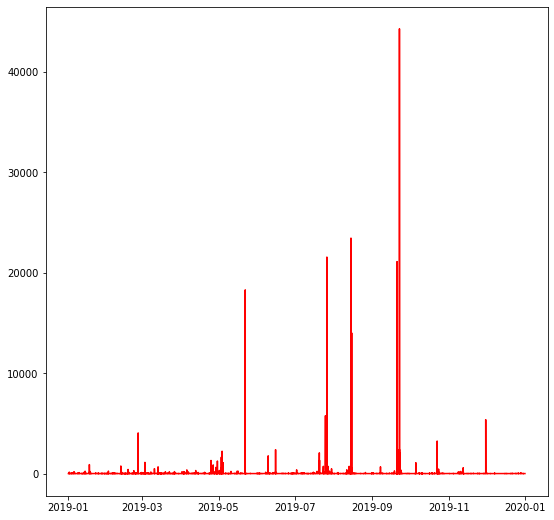

In [154]:
f, ax = plt.subplots(figsize = (9,9))
plt.plot(df19["Datetime"], df19["vitess(m/s)"], color="red")


In [138]:
#Woaaa.... 40000m/s ??
# Regardons de plus près les trajet louches 
df19.to_csv('df19_essai20200119_2253.xls', sep = ';')

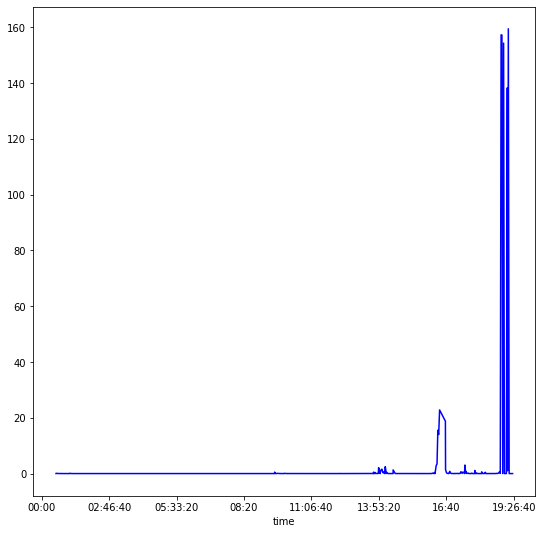

In [158]:
df_to_plot = df19[df19["month"] == 1]
df_to_plot = df_to_plot[df_to_plot["day"] == 13]

f, ax = plt.subplots(figsize = (9,9))
plt.plot(df_to_plot["hour:minute"], df_to_plot["vitess(m/s)"], color="blue")

#Sur une journée sans valeur abhérrante, on voit distinctement un trajet à pied, en tranport puis en avion

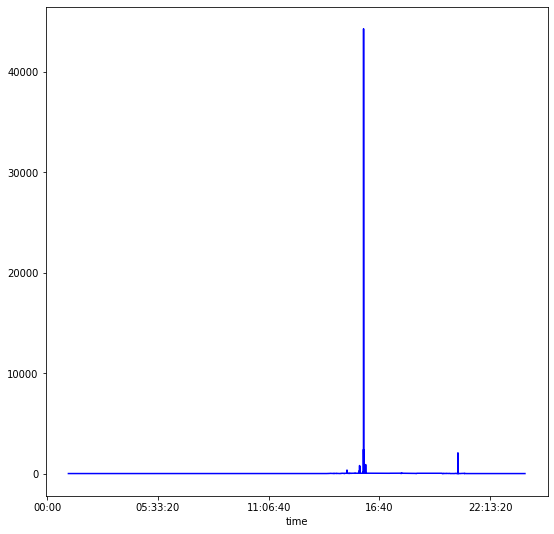

In [167]:
df_to_plot = df19[df19["month"] == 9]
df_to_plot = df_to_plot[df_to_plot["day"] == 22]


f, ax = plt.subplots(figsize = (9,9))
plt.plot(df_to_plot["hour:minute"], df_to_plot["vitess(m/s)"], color="blue")

#Un point avec valeur abhérrante 
#J'étais en voiture sur l'autoroute
# Google timeline ne montre pas de glitch

In [170]:
df_to_plot["hour:minute"].iloc[0]

datetime.time(1, 3, 39, 977000)

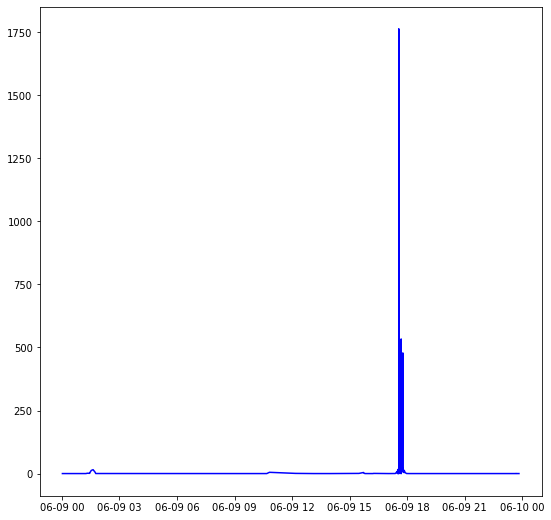

In [174]:
df_to_plot = df19[df19["month"] == 6]
df_to_plot = df_to_plot[df_to_plot["day"] == 9]


f, ax = plt.subplots(figsize = (9,9))
plt.plot(df_to_plot["Datetime"], df_to_plot["vitess(m/s)"], color="blue")

#Un point avec valeur abhérrante 
#J'étais en voiture sur l'autoroute
# Google timeline ne montre pas de glitch
# Semble correspindre à des point où gg a enregistré un temps erroné (très proche du point précédent) pendant un déplacement
# stratégie du correction : remplacer vitesse et acc par celle du point précédent ou supprimer les lignes? voir comment se comportent les point autoir

In [176]:
df19[df19["vitess(m/s)"] > 500]

Latitude  Longitude                Datetime  year    distance(m)  \
614686 -33.987543 -53.560883 2019-01-17 18:21:16.599  2019   21797.864007   
624386 -34.779835 -55.230190 2019-02-11 22:00:56.484  2019   91181.657463   
632062 -15.999495 -48.053500 2019-02-25 18:43:47.504  2019  998008.649125   
632063 -22.969061 -42.018926 2019-02-25 18:47:54.348  2019  997943.250486   
634567 -22.948228 -43.680016 2019-03-03 04:22:02.979  2019   52218.997802   
634568 -22.910531 -43.196726 2019-03-03 04:23:37.969  2019   49749.272204   
634611 -22.948225 -43.680013 2019-03-03 05:48:43.030  2019   49697.721840   
640715 -23.316911 -44.722195 2019-03-13 16:39:21.933  2019   10604.120824   
657695  -1.413406 -48.495934 2019-04-25 00:19:12.514  2019    3995.974490   
657781  -1.803922 -53.441370 2019-04-26 18:07:51.000  2019   18872.641048   
658599  -2.495743 -54.955544 2019-04-28 20:59:15.000  2019   27908.352352   
659141  -1.919915 -55.513632 2019-04-30 02:47:22.522  2019  104012.919027   
660119  -3.556806 -60.204517 2019-05-03 04:59:25.939  2019   29139.307202   
660136  -3.577072 -59.943391 2019-05-03 05:46:38.000  2019   29098.955098   
660274  -3.577587 -59.943104 2019-05-03 16:58:52.515  2019   29135.165737   
660307  -3.577044 -59.943494 2019-05-03 18:30:07.547  2019   28991.404184   
660394  -3.576937 -59.943570 2019-05-03 21:13:53.460  2019   29077.961366   
660569  -3.577018 -59.943452 2019-05-04 18:07:22.923  2019   29091.741835   
660606  -3.616410 -59.909782 2019-05-04 18:55:14.434  2019   16358.425206   
668180  48.070229  -0.000981 2019-05-22 09:21:02.000  2019    1937.360225   
668181  48.066956   0.024552 2019-05-22 09:21:02.106  2019    1937.360225   
668183  48.069449  -0.004737 2019-05-22 09:21:17.000  2019    1911.898117   
668184  48.068478   0.020876 2019-05-22 09:21:17.106  2019    1911.898117   
668186  48.070218  -0.008625 2019-05-22 09:21:32.000  2019    1930.674988   
668187  48.069231   0.017240 2019-05-22 09:21:33.106  2019    1930.674988   
668189  48.069217   0.013450 2019-05-22 09:21:47.786  2019    1882.826629   
674974  43.929081   4.804505 2019-06-09 17:33:50.015  2019      26.459347   
675004  43.949691   4.782447 2019-06-09 17:41:17.640  2019    1409.311109   
677771  49.108834   6.183962 2019-06-15 15:04:06.908  2019  291149.906633   
677772  48.825538   2.230463 2019-06-15 15:06:12.255  2019  291150.048214   
...           ...        ...                     ...   ...            ...   
721865  48.263489   2.721841 2019-09-20 17:21:59.830  2019    2106.839361   
722020  47.856408   3.569964 2019-09-20 17:58:41.113  2019    2134.619328   
722022  47.856522   3.576804 2019-09-20 17:58:58.113  2019    2190.288719   
722024  47.855998   3.583489 2019-09-20 17:59:14.113  2019    2222.544548   
722026  47.854836   3.589853 2019-09-20 17:59:29.113  2019    2383.195119   
722029  47.852628   3.596700 2019-09-20 17:59:46.113  2019    2353.640280   
722030  47.836299   3.618533 2019-09-20 17:59:48.000  2019    2442.692959   
722919  46.160002   5.778942 2019-09-20 21:58:39.000  2019    2123.686280   
724574  46.137815   5.527828 2019-09-22 15:40:10.247  2019     934.860983   
724575  46.127078   5.500837 2019-09-22 15:40:14.000  2019    2403.072379   
724578  46.119555   5.493138 2019-09-22 15:40:44.000  2019    3362.523908   
724634  46.103990   5.290982 2019-09-22 15:51:44.000  2019    2569.399542   
724635  46.080945   5.293576 2019-09-22 15:51:46.535  2019    2569.399542   
724637  46.108561   5.291880 2019-09-22 15:51:59.000  2019    2541.857549   
724638  46.085754   5.289488 2019-09-22 15:52:03.535  2019    2541.857549   
724640  46.113124   5.291565 2019-09-22 15:52:14.000  2019    2478.200571   
724675  46.223379   5.290057 2019-09-22 15:58:32.000  2019    2300.672179   
724676  46.203035   5.295543 2019-09-22 15:58:34.569  2019    2300.672179   
724961  48.810109   2.212398 2019-09-22 20:36:17.000  2019     929.693403   
729612  48.901599   2.301062 2019-10-05 18:37:08.808  2019    6677.300366   
72961

In [177]:
# On sauvegarde le dataframe au format pkl pour y accéder plus rapidement 
df19.to_pickle("df19_save_20200120_0016.pkl")

In [3]:
# Pour récupérer le df19...
df19 = pd.read_pickle("df19_save_20200120_0016.pkl")

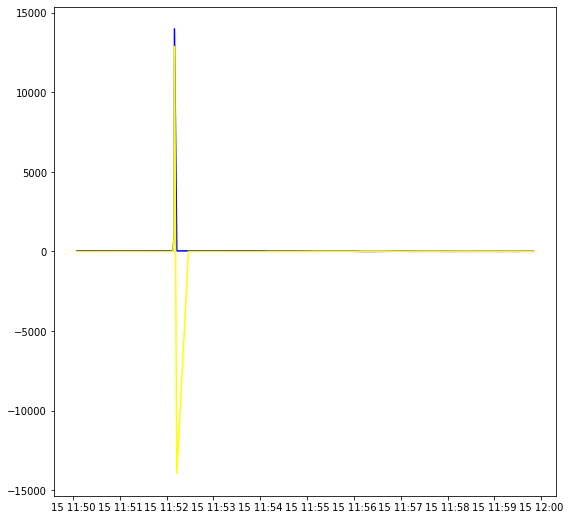

In [39]:
df_to_plot = df19.loc[(df19["month"] == 8) & df19["day"].isin(range(15,16)) \
                      & df19["hour"].isin(range(11,12)) & df19["minute"].isin(range(50,60))]



f, ax = plt.subplots(figsize = (9,9))
plt.plot(df_to_plot["Datetime"], df_to_plot["vitess(m/s)"], color="blue")
plt.plot(df_to_plot["Datetime"], df_to_plot["acceleration(m/s2)"], color="yellow")



In [32]:
df19["hour:minute"].iloc[0]

datetime.time(0, 0, 2, 52000)

In [40]:
df_to_plot.head(50)

Latitude  Longitude                Datetime  year  distance(m)  \
707357  43.770791   4.276681 2019-08-15 11:50:05.000  2019   443.488543   
707358  43.769221   4.272676 2019-08-15 11:50:15.000  2019   366.590745   
707359  43.765877   4.267685 2019-08-15 11:50:30.000  2019   547.346042   
707360  43.761243   4.264438 2019-08-15 11:50:46.000  2019   577.438310   
707361  43.757035   4.260722 2019-08-15 11:51:01.000  2019   555.147880   
707362  43.755939   4.259738 2019-08-15 11:51:05.000  2019   145.302312   
707363  43.755388   4.259240 2019-08-15 11:51:07.000  2019    73.168555   
707364  43.751452   4.255069 2019-08-15 11:51:22.000  2019   551.455763   
707365  43.748860   4.248716 2019-08-15 11:51:38.000  2019   587.114421   
707366  43.748495   4.241962 2019-08-15 11:51:53.000  2019   545.527681   
707367  43.749356   4.235220 2019-08-15 11:52:08.000  2019   551.407004   
707368  43.755388   4.259240 2019-08-15 11:52:09.849  2019  2047.320109   
707369  43.749477   4.234310 2019-08-15 11:52:10.000  2019  2112.506380   
707370  43.749663   4.232954 2019-08-15 11:52:13.000  2019   111.166085   
707371  43.750575   4.226186 2019-08-15 11:52:28.000  2019   554.448502   
707372  43.751158   4.218889 2019-08-15 11:52:44.000  2019   591.252136   
707373  43.750354   4.212092 2019-08-15 11:52:59.000  2019   554.716183   
707374  43.749399   4.208671 2019-08-15 11:53:07.000  2019   295.222168   
707375  43.749252   4.208259 2019-08-15 11:53:08.000  2019    36.936681   
707376  43.746303   4.202231 2019-08-15 11:53:24.000  2019   585.799577   
707377  43.742519   4.197775 2019-08-15 11:53:39.000  2019   552.757147   
707378  43.738242   4.194913 2019-08-15 11:53:54.000  2019   528.249347   
707379  43.735040   4.193508 2019-08-15 11:54:07.000  2019   373.277643   
707380  43.734810   4.193403 2019-08-15 11:54:08.000  2019    26.960948   
707381  43.731490   4.190984 2019-08-15 11:54:24.000  2019   417.116316   
707382  43.729186   4.187539 2019-08-15 11:54:39.000  2019   377.663505   
707383  43.728118   4.184001 2019-08-15 11:54:55.000  2019   308.727601   
707384  43.727815   4.181713 2019-08-15 11:55:08.000  2019   187.440602   
707385  43.727816   4.181533 2019-08-15 11:55:09.000  2019    14.496124   
707386  43.727587   4.178977 2019-08-15 11:55:24.000  2019   207.495001   
707387  43.725490   4.179773 2019-08-15 11:55:40.000  2019   241.619032   
707388  43.723504   4.180810 2019-08-15 11:55:55.000  2019   235.893209   
707389  43.722899   4.180951 2019-08-15 11:56:09.000  2019    68.267404   
707390  43.722884   4.180958 2019-08-15 11:56:10.000  2019     1.664939   
707391  43.722766   4.181055 2019-08-15 11:56:25.000  2019    15.348310   
707392  43.721566   4.181554 2019-08-15 11:56:40.000  2019   139.255752   
707393  43.719248   4.182222 2019-08-15 11:56:56.000  2019   263.025318   
707394  43.717447   4.182246 2019-08-15 11:57:10.000  2019   200.168221   
707395  43.717374   4.182186 2019-08-15 11:57:11.000  2019     9.493204   
707396  43.717422   4.180424 2019-08-15 11:57:26.000  2019   142.111120   
707397  43.718369   4.178687 2019-08-15 11:57:42.000  2019   175.106235   
707398  43.719279   4.177586 2019-08-15 11:57:57.000  2019   134.524651   
707399  43.719253   4.176613 2019-08-15 11:58:10.000  2019    78.397667   
707400  43.719279   4.176319 2019-08-15 11:58:13.000  2019    23.861921   
707401  43.719474   4.174855 2019-08-15 11:58:30.000  2019   119.978464   
707402  43.719611   4.173195 2019-08-15 11:58:45.000  2019   134.660154   
707403  43.719815   4.171566 2019-08-15 11:59:00.000  2019   133.206563   
707404  43.720101   4.170397 2019-08-15 11:59:15.000  2019    99.392147   
707405  43.720041   4.170177 2019-08-15 11:59:17.000  2019    18.945010   
707406  43.719965   4.168982 2019-08-15 11:59:32.000  2019    96.673541   

                    coordonnees          coordonnees_t-1  temps_ecoule  \
707357  (43.7707911, 4.2766809)  (43.7730877, 4.2811861)        12.000   
707358  (43.7692213, 4.2726762)  (4

In [44]:
df19.loc[(df19["acceleration(m/s2)"] > 300) | (df19["acceleration(m/s2)"] < -300)]

Latitude  Longitude                Datetime  year    distance(m)  \
614686 -33.987543 -53.560883 2019-01-17 18:21:16.599  2019   21797.864007   
614687 -33.976557 -53.530194 2019-01-17 18:47:54.810  2019    3086.600601   
624386 -34.779835 -55.230190 2019-02-11 22:00:56.484  2019   91181.657463   
624387 -34.785958 -55.242301 2019-02-11 22:02:43.229  2019    1299.995463   
627699 -22.926058 -43.176660 2019-02-17 17:02:53.717  2019   28805.823282   
632062 -15.999495 -48.053500 2019-02-25 18:43:47.504  2019  998008.649125   
632064 -22.968942 -42.018637 2019-02-25 18:49:17.151  2019      32.470914   
634514 -22.910740 -43.196855 2019-03-03 02:26:10.197  2019   49733.474350   
634515 -22.910381 -43.197049 2019-03-03 02:29:00.181  2019      44.409877   
634567 -22.948228 -43.680016 2019-03-03 04:22:02.979  2019   52218.997802   
634568 -22.910531 -43.196726 2019-03-03 04:23:37.969  2019   49749.272204   
634569 -22.910482 -43.196725 2019-03-03 04:27:41.483  2019       5.416108   
634611 -22.948225 -43.680013 2019-03-03 05:48:43.030  2019   49697.721840   
634612 -22.931075 -43.459593 2019-03-03 05:51:46.545  2019   22687.710956   
634614 -22.910504 -43.197463 2019-03-03 05:54:58.345  2019   26986.179121   
634615 -22.909792 -43.197262 2019-03-03 06:02:22.108  2019      81.431143   
639206 -23.025173 -44.284346 2019-03-10 18:36:29.895  2019    1014.757397   
639207 -23.025744 -44.284234 2019-03-10 18:42:25.000  2019      64.281447   
640715 -23.316911 -44.722195 2019-03-13 16:39:21.933  2019   10604.120824   
640716 -23.318280 -44.721334 2019-03-13 16:40:29.274  2019     175.355315   
653133  -1.291091 -47.986643 2019-04-05 16:15:03.000  2019      12.074361   
653913  -1.291589 -47.995520 2019-04-12 18:48:47.935  2019     686.519586   
653914  -1.291597 -47.995493 2019-04-12 18:50:43.928  2019       3.085456   
657694  -1.449165 -48.501121 2019-04-25 00:19:09.449  2019    3830.703458   
657695  -1.413406 -48.495934 2019-04-25 00:19:12.514  2019    3995.974490   
657696  -1.412272 -48.496008 2019-04-25 00:19:32.525  2019     125.617262   
657781  -1.803922 -53.441370 2019-04-26 18:07:51.000  2019   18872.641048   
657782  -1.818439 -53.493185 2019-04-26 18:51:34.000  2019    5984.403523   
658599  -2.495743 -54.955544 2019-04-28 20:59:15.000  2019   27908.352352   
658600  -2.417934 -54.716832 2019-04-28 21:34:27.602  2019   27908.352352   
...           ...        ...                     ...   ...            ...   
724675  46.223379   5.290057 2019-09-22 15:58:32.000  2019    2300.672179   
724677  46.227422   5.287134 2019-09-22 15:58:47.000  2019    2787.375629   
724961  48.810109   2.212398 2019-09-22 20:36:17.000  2019     929.693403   
724962  48.812266   2.213632 2019-09-22 20:36:33.000  2019     256.311700   
725632  48.880447   2.342222 2019-09-23 19:38:31.912  2019     111.826084   
725633  48.881735   2.334876 2019-09-23 19:43:35.286  2019     557.502412   
729612  48.901599   2.301062 2019-10-05 18:37:08.808  2019    6677.300366   
729613  48.901599   2.301062 2019-10-05 18:37:09.836  2019       0.000000   
729614  48.856267   2.361025 2019-10-05 18:37:17.782  2019    6690.241490   
729615  48.856260   2.361013 2019-10-05 18:37:32.978  2019       1.163354   
735952  43.527662   5.735487 2019-10-22 16:39:04.856  2019     542.710374   
735953  43.533050   5.731198 2019-10-22 16:39:19.000  2019     691.787457   
736143  43.462817   5.826124 2019-10-22 19:21:44.000  2019    1574.301758   
736144  43.457758   5.839588 2019-10-22 19:21:57.250  2019    1225.992756   
736146  43.464958   5.823737 2019-10-22 19:21:59.000  2019    1511.751196   
736147  43.458600   5.835756 2019-10-22 19:22:12.250  2019    1202.128511   
736149  43.466672   5.820935 2019-10-22 19:22:14.000  2019    1497.665416   
736150  43.459451   5.831818 2019-10-22 19:22:28.250  2019    1191.376911   
736151  43.466922   5.817075 2019-10-22 19:22:29.000  2019    1453.420423   
736152  43.459451   5.831818 2019-10-22 19:22:29.449  2019    1453.420423   
73615

# Les Glitchs et comment s'en débarasser
* Pendant un déplacement, 2 points sont pris à un intervalle très court (<5s)
* Se traduit par une vitesse anormale (>> au dessus du possible) pendant 1 ou 2 timestamps
* Egalement un pic d'accélération + suivi par un pic d'accélération-

--> Supprimer les lignes et recalculer les vitesse et accélération sans ces points (comment les repérer?  bug sur le temps ou parfois sur la géoloc ?)
--> Ramener vitesses et accélération à la moyenne des points environnants (quelle fonction rapide ?)

In [1]:
conda install parsel

Solving environment: ...working... done

## Package Plan ##

  environment location: D:\Anaconda

  added / updated specs:
    - parsel


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.8.1                |           py37_0         2.8 MB
    cssselect-1.1.0            |             py_0          18 KB
    parsel-1.5.2               |           py37_0         192 KB
    pytest-runner-5.2          |             py_0          13 KB
    w3lib-1.21.0               |             py_0         163 KB
    ------------------------------------------------------------
                                           Total:         3.2 MB

The following NEW packages will be INSTALLED:

  cssselect          pkgs/main/noarch::cssselect-1.1.0-py_0
  parsel             pkgs/main/win-64::parsel-1.5.2-py37_0
  pytest-runner      pkgs/main/noarch::pytest-runner-5.2-py_0
  w3lib              pkgs/main/noa